# STIS data reduction pipeline
Sai Krishanth Pulikesi Mannan

The functions createmask and combproframes are adapted from Robert M Thompson (https://github.com/douglase/reduce50coron/blob/epseri/stishubble.py)

This has been tested with the following versions of Python(v3.9.12) packages:

<ol>
<li>Pyklip: 2.6</li>
<li>Scipy: 1.7.3</li>
<li>Pandas: 1.4.2</li>
<li>Astropy: 5.0.4</li>
<li>Numpy: 1.21.5</li>
<li>Matplotlib: 3.5.1</li>
<li>Multiprocess: 0.70.14</li>
</ol>

Packages that are not pip installed are available from here:

1. [pyklip](https://pyklip.readthedocs.io/en/latest/install.html)
2. [nmf_imaging](https://github.com/seawander/nmf_imaging)
3. [radonCenter](https://github.com/seawander/centerRadon)

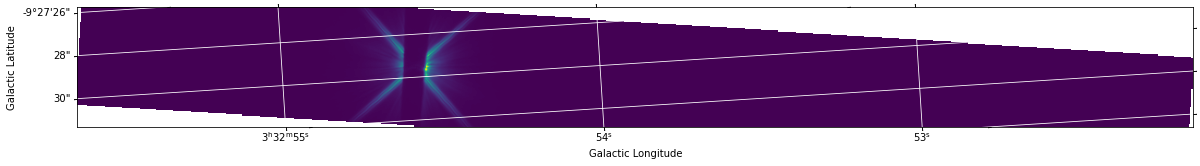

In [49]:
import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

filename = get_pkg_data_filename('A10_110_EPSERI_TRG/odn301010_flt.fits')

hdu = fits.open(filename)[1]
hdu1 = fits.open(filename)[4]
wcs = WCS(hdu.header)
plt.figure(figsize=[20,10])
plt.subplot(projection=wcs)
plt.imshow(nusaFR)
#plt.imshow(hdu1.data)
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

In [45]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.22741867438  -9.458198366162  
CRPIX : 310.505  55.5689  
CD1_1 CD1_2  : -1.40726e-05  -8.91595e-07  
CD2_1 CD2_2  : -8.9135e-07  1.40765e-05  
NAXIS : 1024  110

In [43]:
nusaFR = pyklipRotate (hdu.data, -3.6242386372716737, (310.505,55.5689)) 

In [39]:
with fits.open('A10_110_EPSERI_TRG/odn301010_flt.fits') as hdul:
    exptimes = []
    CRPIX1 = hdul['SCI'].header['CRPIX1']
    CRPIX2 = hdul['SCI'].header['CRPIX2']
    NAXIS1 = hdul['SCI'].header['NAXIS1']
    NAXIS2 = hdul['SCI'].header['NAXIS2']
    CCDGAIN = hdul[0].header['CCDGAIN']
    wcsO = WCS(hdul[1].header)
    rot_angle = np.rad2deg(math.atan2(wcsO.wcs.cd[1][0], wcsO.wcs.cd[0][0]))
    wcspa = 180*np.sign(rot_angle) - rot_angle

In [42]:
CRPIX2

55.5689

In [1]:
import os
import math
import warnings
import radonCenter
import nmf_imaging
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap,SymLogNorm
from multiprocess import Pool
from astropy import wcs
from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy import convolution as conv
from astropy.visualization import astropy_mpl_style
from astropy.utils.exceptions import AstropyWarning
from pyklip.klip import rotate as pyklipRotate

In [2]:
#These are Wedge A1.0 files where the shapes are smaller and centers are off by a lot
badrefs = ['o64w12040_flt.fits',
           'o64w11010_flt.fits',
           'o64w12020_flt.fits',
           'o64wa2030_flt.fits',
           'o64w12010_flt.fits',
           'o64w12030_flt.fits',
           'o64wa2020_flt.fits',
           'o64wa2040_flt.fits',
           'o64w11030_flt.fits',
           'o64wa2010_flt.fits',
           'o64wa1030_flt.fits',
           'o64w11040_flt.fits',
           'o64wa1020_flt.fits',
           'o64wa1040_flt.fits',
           'o64wa1010_flt.fits',
           'o64w11020_flt.fits']

In [3]:
#Set target and reference directories, diskmodel used (to inject disk, optional), number of cores,
#number of NMF components, and maximum iterations
trgdir = '/Users/saikrishanth/Desktop/OneDrive - University of Arizona/STIS/A10_110_EPSERI_TRG'
refdir = '/Users/saikrishanth/Desktop/OneDrive - University of Arizona/STIS/A10_110_DELERI_REF'
trgfiles = [f for f in os.listdir(trgdir)]
reffiles = [f for f in os.listdir(refdir) if f not in trgfiles]
reffiles = [f for f in reffiles if f not in badrefs]

diskmodel = 'sst_backman_model_HST_inc_34.fits'

ncores = 8
n_components = 10
maxiters = 1e3

In [4]:
#Function to create algorithmic mask applied to frames. To chage properties of the mask, it is suggested to start
#with wedgeWarcsF and legWarcsF (they adjust the thickness of the central wedge and 
#the diffraction spikes respectively). The "shift" variables shift the mask left or right.
def createmask(maskshape, voff, hoff, apertureshape):
    """
    Creates the maskFR
    This is presently done by default.
    
    Args:
        maskL       : A list of parameters to make the maskFR
                      Presently, the first is width in arcseconds of the wedge
                      Presently, the second is width in arcseconds of the legs
        maskshape   : The shape to make the maskFR
        
    Attributes:
        returns the maskFR frame
     
    """
    slope = (((3.0-0.5)/2)/50)
    H = maskshape[0]
    W = maskshape[1]
    mvc = int(H/2) # mask vertical center
    mhc = int(W/2) # mask horizontal center
    
    maskFR = np.zeros(maskshape)
    avc = int ( apertureshape[0] / 2 ) # aperture Vertical center
    ahc = int ( apertureshape[1] / 2 ) # aperture Horizontal center
    maskFR[mvc-avc+1+1:mvc+avc-1,mhc-ahc+1:mhc+ahc-1] = 1
        
    wedgeWarcsF   = 1.2 # Float   ; default: 1.0 arcseconds
    legWarcsF     = 0.8 # Float   ; default: 0.2 arcseconds
    wedgeshiftI   = 0 # Integer 
    leghorzshiftI = 0 # Integer 
    legvertshiftI = 0 # Integer 
    wedgeWpix     = round(wedgeWarcsF/0.05) # default: 20 pixels
    legWpix       = round(legWarcsF/0.05) # default: 4 pixels
    halfwedgeWpix = round(wedgeWpix/2)
    mhoff = hoff - 202 - 1
    leghorzshiftI = leghorzshiftI + round(mhoff)
    legvertshiftI = legvertshiftI + round(voff)
    wedgeshiftI = wedgeshiftI + round(mhoff)
            
    # Wedge A
    wedgestartX = mhc + int(wedgeshiftI)
    wedgestartY = mvc
    wedgeX      = wedgestartX
    wedgeY      = wedgestartY
    for row in range(mvc):
        halfwidthtop = int(halfwedgeWpix+((wedgeY+row)*slope))
        for col in range(halfwidthtop):
            maskFR[wedgeY+row][wedgeX+col] = 0
            maskFR[wedgeY+row][wedgeX-col] = 0
        
    for row in range(mvc):        
        halfwidthbottom = int(halfwedgeWpix + ((wedgeY-row)*slope))
        for col in range(halfwidthbottom):
            maskFR[wedgeY-row][wedgeX+col] = 0
            maskFR[wedgeY-row][wedgeX-col] = 0
    
    # Spider legs / Diffraction spikes
    S                = int ( leghorzshiftI )
    legstartX        = mhc   
    legstartY        = mvc
    legX             = legstartX
    legY             = legstartY
    lvs              = int(legvertshiftI)
    
    for row in range ( mvc + abs ( lvs ) ) :
        legY = legY + 1
        legX = legX + 1
        for col in range ( legWpix ) :
            if W - 1 - legX + S - col + int(legWpix/2) < 239 and legY + lvs < H :
                maskFR [   legY-1 + lvs ] [ W - 1 - legX + S - col + int(legWpix/2)] = 0 # UL
            if         legX + S + col - int(legWpix/2) < 239 and legY + lvs < H : 
                maskFR [   legY-1 + lvs ] [         legX + S + col - int(legWpix/2)] = 0 # UR
            if         legX + S + col - int(legWpix/2) < 239 and - legY + lvs > - H - 1 :
                maskFR [ - legY+1 + lvs ] [         legX + S + col - int(legWpix/2)] = 0 # LR
            if W - 1 - legX + S - col + int(legWpix/2) < 239 and - legY + lvs > - H - 1 :
                maskFR [ - legY+1 + lvs ] [ W - 1 - legX + S - col + int(legWpix/2)] = 0 # LL        

    return maskFR

In [5]:
#Function that combines the processed frames. Has 3 output fits files which contain residuals, medians, and 
#standard deviations respectively. 
def combproframes(DC, filenames, PAs) : 
    print("DC.shape       : ", DC.shape)
    print("len(filenames) : ", len(filenames)) 
    print("len(PAs)       : ", len(PAs))
    DCii   = 0  
    FN     = filenames [ DCii ] 
    lastFN = FN
    IHDUii = 1  
    TLbo     = [] 
    for suusaFR in DC : 

        FN = filenames [ DCii ]
        if lastFN != FN : IHDUii = 1
        PA = PAs [ DCii ]
        susaFR = stats.sigma_clip ( suusaFR, sigma = 2, maxiters = 5 )

        frmmsT = stats.sigma_clipped_stats ( susaFR , sigma = 2, maxiters = 5 ) 
        rotationcenter = ( susaFR.shape[1] / 2, susaFR.shape[0] / 2 )
        nusaFR = pyklipRotate ( susaFR, PA, rotationcenter ) 
        TLbo.append (
            (
                DCii,
                nusaFR,
                susaFR,
                FN,
                IHDUii,
                frmmsT[2],
                PA,
            )     
        )
        DCii   = DCii + 1
        IHDUii = IHDUii + 3
        lastFN = FN

    nuFRRAbo = np.array ( [ col[1] for col in TLbo ] ) 
    print("nuFRRAbo.shape : ", nuFRRAbo.shape)
    
    HDU      = fits.PrimaryHDU ( nuFRRAbo )
    HDUL     = fits.HDUList ( [ HDU ] )

    oFN  = "nmf_nuAllResidFRbo.fits"
    HDUL.writeto ( oFN, overwrite = True )
    
    from operator import itemgetter 
    TLbs     = sorted ( TLbo, key = itemgetter ( 5 ) )
    nuFRRAbs = np.array ( [ col[1] for col in TLbs ] )
    print("nuFRRAbs.shape      : ", nuFRRAbs.shape)
    
    nuNanMedianFR = np.nanmedian ( nuFRRAbs, axis = 0 )
    print("nuNanMedianFR       : ", nuNanMedianFR)
    print("nuNanMedianFR.shape : ", nuNanMedianFR.shape)
    HDU      = fits.PrimaryHDU ( nuNanMedianFR )
    HDUL     = fits.HDUList ( [ HDU ] )

    oFN  = "nmf_nuNanMedianFRbs.fits"
    HDUL.writeto ( oFN, overwrite = True )        

    nuNanStddevFR = np.nanstd    ( nuFRRAbs, axis = 0 )
    print("nuNanStddevFR       : ", nuNanStddevFR)
    print("nuNanStddevFR.shape : ", nuNanStddevFR.shape)
    HDU      = fits.PrimaryHDU ( nuNanStddevFR )
    HDUL     = fits.HDUList ( [ HDU ] )

    oFN  = "nmf_nuNanStddevFRbs.fits"
    HDUL.writeto ( oFN, overwrite = True )    

In [6]:
#Processes and target and reference frames. It is written to be parallelizable. Follows 
#"Post-processing of the HST STIS coronagraphic observations" by Ren et al. closely. Changes not advised. 
def prep_frames_parallel(filename):
    
    try:
        trgs = []
        trgs_err = []
        refs = []
        refs_err = []
        PAs = []
        fnames = []
        mask = []
        
        image_data_sc = []
        image_data_er = []
        image_data_dq = []
        
        if filename in trgfiles:
            path = os.path.join(trgdir, filename)
        elif filename in reffiles:
            path = os.path.join(refdir, filename)
            
        with fits.open(path) as hdul:
            exptimes = []
            CRPIX1 = hdul['SCI'].header['CRPIX1']
            CRPIX2 = hdul['SCI'].header['CRPIX2']
            NAXIS1 = hdul['SCI'].header['NAXIS1']
            NAXIS2 = hdul['SCI'].header['NAXIS2']
            CCDGAIN = hdul[0].header['CCDGAIN']
            wcsO = wcs.WCS(hdul[1].header)
            rot_angle = np.rad2deg(math.atan2(wcsO.wcs.cd[1][0], wcsO.wcs.cd[0][0]))
            wcspa = 180*np.sign(rot_angle) - rot_angle
            
            for i in range(1,len(hdul),3):
                exptimes.append(hdul[i].header['EXPTIME'])
                
            exptimes = np.array(exptimes)
            medexp = np.median(exptimes)
            
            for i in range(1,len(hdul),3):
                EXPTIME = hdul[i].header['EXPTIME']
                if EXPTIME > medexp:
                    continue
                image_data_sc.append(hdul[i].data)
                image_data_er.append(hdul[i+1].data)
                image_data_dq.append(hdul[i+2].data)
    
        for x in range(len(image_data_dq)): 
            
            if image_data_sc[x].shape[0] != 110:
                cutframesc = Cutout2D(image_data_sc[x],(CRPIX1,CRPIX2),(110,1500),wcs=None)
                cutframeer = Cutout2D(image_data_er[x],(CRPIX1,CRPIX2),(110,1500),wcs=None)
                cutframedq = Cutout2D(image_data_dq[x],(CRPIX1,CRPIX2),(110,1500),wcs=None)
                image_data_sc[x] = cutframesc.data
                image_data_sc[x] = cutframeer.data
                image_data_sc[x] = cutframedq.data
                CRPIX1,CRPIX2 = cutframesc.position_cutout
            
            dq01 = np.where(image_data_dq[x]==(16 or 256 or 8192),0,1)
            dq10 = np.where(image_data_dq[x]==(16 or 256 or 8192),1,0)
            medsci = scipy.ndimage.median_filter(image_data_sc[x],size=3)
            multsciadd = np.multiply(dq10,medsci)
            multscisub = np.multiply(dq01,image_data_sc[x])
            image_data_sc[x] = np.add(multscisub,multsciadd)
            mederr = scipy.ndimage.median_filter(image_data_er[x],size=3)
            multerradd = np.multiply(dq10,mederr)
            multerrsub = np.multiply(dq01,image_data_er[x])
            image_data_er[x] = np.add(multerrsub,multerradd)
                
            for i in range(len(image_data_dq[x])):
                for j in range(len(image_data_dq[x][i])):
                    vdist  = i - CRPIX2
                    hdist  = j - CRPIX1
                    radius = math.sqrt(pow(vdist, 2) + pow(hdist, 2))
                    image_data_sc[x][i][j] = image_data_sc[x][i][j]*pow(radius, 0.5)
                
            (x_cen, y_cen) = radonCenter.searchCenter(image_data_sc[x], CRPIX1, CRPIX2, size_window = math.floor(NAXIS2/2),size_cost=7,theta=[45, 135]) 
        
            image_data_sc[x] = image_data_sc[x]/EXPTIME
            image_data_er[x] = image_data_er[x]/EXPTIME
            
            voff = image_data_sc[x].shape[0]/2 - y_cen 
            hoff = image_data_sc[x].shape[1]/2 - x_cen 
            
            shiftimage_data_sc = scipy.ndimage.shift(image_data_sc[x], np.array([voff, hoff]))
            shiftimage_data_er = scipy.ndimage.shift(image_data_er[x], np.array([voff, hoff]))     
            
            lh = 110 #for A1.0
            lw = 213 #for A1.0
            
            hypotenuse = math.floor(math.sqrt(pow(lh, 2) + pow(lw, 2)))
        
            sc_data_2d = Cutout2D(shiftimage_data_sc, position=(shiftimage_data_sc.shape[1]/2,shiftimage_data_sc.shape[0]/2), size=(lh,lw), wcs=None)
            er_data_2d = Cutout2D(shiftimage_data_er, position=(shiftimage_data_er.shape[1]/2,shiftimage_data_er.shape[0]/2), size=(lh,lw), wcs=None)
            
            aFR = int(hypotenuse/2 - sc_data_2d.shape[0]/2) 
            aFC = int(hypotenuse/2 - sc_data_2d.shape[1]/2) 
            bb  = 1
            aBR = aFR + bb 
            aTR = aFR - bb + sc_data_2d.shape[0] 
            aLC = aFC + bb 
            aRC = aFC - bb + sc_data_2d.shape[1]  
            
            SCIcanvas = np.zeros((hypotenuse, hypotenuse)) 
            SCIcanvas[aBR:aTR, aLC:aRC] = sc_data_2d.data[bb:-bb,bb:-bb]
            ERRcanvas = np.zeros((hypotenuse, hypotenuse)) 
            ERRcanvas[aBR:aTR,aLC:aRC] = er_data_2d.data[bb:- bb,bb:-bb]
        
            if filename in trgfiles:
                trgs.append(SCIcanvas)
                trgs_err.append(ERRcanvas)
                PAs.append(wcspa)
                fnames.append(filename)
            elif filename in reffiles:
                refs.append(SCIcanvas)
                refs_err.append(ERRcanvas)
                PAs.append(wcspa)
                fnames.append(filename)
                
    except Exception as e:
        print(e,filename)
        
    return trgs, trgs_err, refs, refs_err, PAs, fnames

In [7]:
#Variables that are inputs to the createmask function. Change stisPos for slightly different results.
#Changing scishape not advised. 
scishape = (110, 1024)
stisPos  = (309, 54)
voffstis = scishape[0]/2 - stisPos[1] + 0 
hoffstis = scishape[1]/2 - stisPos[0] + 2 

In [8]:
%%time
#Run prep_frames_parallel in parallel with the number of cores specified. Ignores WCS warnings from astropy
warnings.simplefilter('ignore', AstropyWarning)
with Pool(ncores) as p:
    results1 = list(p.map(prep_frames_parallel, trgfiles))
    results2 = list(p.map(prep_frames_parallel, reffiles))

CPU times: user 236 ms, sys: 1.13 s, total: 1.37 s
Wall time: 1min 48s


In [9]:
#Extracts data we need from results in the previous cell and stores them as arrays
trgs = []
trgs_err = []
refs = []
refs_err = []
PAs = []
fnames = []
mask = createmask((239,239),voffstis,hoffstis,(110,213))

for i in range(len(results1)):
    for j in range(len(results1[i][0])):
        tr = results1[i][0][j]
        trgs.append(tr)
        
for i in range(len(results1)):
    for j in range(len(results1[i][1])):
        tr = results1[i][1][j]
        trgs_err.append(tr)
        
for i in range(len(results1)):
    for j in range(len(results1[i][4])):
        tr = results1[i][4][j]
        PAs.append(tr)
        
for i in range(len(results1)):
    for j in range(len(results1[i][5])):
        tr = results1[i][5][j]
        fnames.append(tr)
        
for i in range(len(results2)):
    for j in range(len(results2[i][2])):
        tr = results2[i][2][j]
        refs.append(tr)
        
for i in range(len(results2)):
    for j in range(len(results2[i][3])):
        tr = results2[i][3][j]
        refs_err.append(tr)
        
for i in range(len(results2)):
    for j in range(len(results2[i][4])):
        tr = results2[i][4][j]
        PAs.append(tr)
        
for i in range(len(results2)):
    for j in range(len(results2[i][5])):
        tr = results2[i][5][j]
        fnames.append(tr)
        
trgs = np.array(trgs)
trgs_err = np.array(trgs_err)
refs = np.array(refs)
refs_err = np.array(refs_err)

In [11]:
#Measure Euclidean distances between reference frames and target frames and selects 10 percent closest reference
#frames to use in NMF subtraction.
best = int(0.1*len(refs))
medians = []
for i in refs:
    norms = []
    for j in range(len(trgs)):
        norm = np.linalg.norm(i - trgs[j])
        norms.append(norm)
    medians.append(np.median(norms))

add = [i for i in range(len(refs))]
best10 = pd.DataFrame(data = medians)
best10['Index'] = add
best10 = best10.sort_values(by=[0])
best10 = best10[0:best]

new_refs = []
new_refs_err = []

for i in best10['Index']:
    new_refs.append(refs[i])
    new_refs_err.append(refs_err[i])

new_refs = np.array(new_refs)
new_refs_err = np.array(new_refs_err)

In [12]:
#Disk injection (optional, comment out this cell if not injecting disk)

trgs = np.array(trgs)*0.1765
trgs_err = np.array(trgs_err)*0.1765
new_refs = np.array(new_refs)*0.1765
new_refs_err = np.array(new_refs_err)*0.1765

image_data = fits.getdata(diskmodel)
image_data_1 = Cutout2D(image_data, position=(128,128), size=(239,239))
disk = (image_data_1.data/0.1765)*100

trgs = np.add(trgs,disk)

In [12]:
%%time
#Build NMF components
components = nmf_imaging.NMFcomponents(new_refs, ref_err = new_refs_err, mask = mask, n_components = n_components, maxiters = maxiters, oneByOne=True)

Building components one by one...
	1 of 10
Current Chi2=56.0722, Previous Chi2=46688.7272, Change=99.8799% @ niters=0
Took 0.000 minutes to reach current solution.
	2 of 10
Current Chi2=55.8664, Previous Chi2=56.6078, Change=1.3097% @ niters=0
Current Chi2=55.6398, Previous Chi2=55.6493, Change=0.0171% @ niters=20
Current Chi2=55.4607, Previous Chi2=55.4695, Change=0.0158% @ niters=40
Current Chi2=55.2818, Previous Chi2=55.2909, Change=0.0165% @ niters=60
Current Chi2=55.0982, Previous Chi2=55.1073, Change=0.0166% @ niters=80
Current Chi2=54.9212, Previous Chi2=54.9297, Change=0.0156% @ niters=100
Current Chi2=54.7577, Previous Chi2=54.7655, Change=0.0143% @ niters=120
Current Chi2=54.6085, Previous Chi2=54.6156, Change=0.0131% @ niters=140
Current Chi2=54.4728, Previous Chi2=54.4792, Change=0.0119% @ niters=160
Current Chi2=54.3492, Previous Chi2=54.3551, Change=0.0109% @ niters=180
Current Chi2=54.2363, Previous Chi2=54.2417, Change=0.0100% @ niters=200
Current Chi2=54.1320, Previous

Current Chi2=46.3467, Previous Chi2=46.3532, Change=0.0140% @ niters=140
Current Chi2=46.2254, Previous Chi2=46.2311, Change=0.0124% @ niters=160
Current Chi2=46.1175, Previous Chi2=46.1226, Change=0.0111% @ niters=180
Current Chi2=46.0206, Previous Chi2=46.0252, Change=0.0100% @ niters=200
Current Chi2=45.9330, Previous Chi2=45.9372, Change=0.0091% @ niters=220
Current Chi2=45.8534, Previous Chi2=45.8572, Change=0.0083% @ niters=240
Current Chi2=45.7803, Previous Chi2=45.7838, Change=0.0077% @ niters=260
Current Chi2=45.7125, Previous Chi2=45.7158, Change=0.0072% @ niters=280
Current Chi2=45.6492, Previous Chi2=45.6523, Change=0.0067% @ niters=300
Current Chi2=45.5896, Previous Chi2=45.5925, Change=0.0064% @ niters=320
Current Chi2=45.5331, Previous Chi2=45.5358, Change=0.0061% @ niters=340
Current Chi2=45.4792, Previous Chi2=45.4818, Change=0.0058% @ niters=360
Current Chi2=45.4277, Previous Chi2=45.4302, Change=0.0056% @ niters=380
Current Chi2=45.3783, Previous Chi2=45.3807, Change

Current Chi2=39.2813, Previous Chi2=39.2836, Change=0.0059% @ niters=340
Current Chi2=39.2371, Previous Chi2=39.2392, Change=0.0054% @ niters=360
Current Chi2=39.1960, Previous Chi2=39.1980, Change=0.0051% @ niters=380
Current Chi2=39.1577, Previous Chi2=39.1595, Change=0.0047% @ niters=400
Current Chi2=39.1217, Previous Chi2=39.1235, Change=0.0045% @ niters=420
Current Chi2=39.0880, Previous Chi2=39.0896, Change=0.0042% @ niters=440
Current Chi2=39.0562, Previous Chi2=39.0577, Change=0.0040% @ niters=460
Current Chi2=39.0261, Previous Chi2=39.0276, Change=0.0038% @ niters=480
Current Chi2=38.9975, Previous Chi2=38.9989, Change=0.0036% @ niters=500
Current Chi2=38.9702, Previous Chi2=38.9715, Change=0.0034% @ niters=520
Current Chi2=38.9441, Previous Chi2=38.9454, Change=0.0033% @ niters=540
Current Chi2=38.9192, Previous Chi2=38.9204, Change=0.0031% @ niters=560
Current Chi2=38.8953, Previous Chi2=38.8965, Change=0.0030% @ niters=580
Current Chi2=38.8723, Previous Chi2=38.8735, Change

Current Chi2=33.3075, Previous Chi2=33.3089, Change=0.0041% @ niters=540
Current Chi2=33.2811, Previous Chi2=33.2824, Change=0.0039% @ niters=560
Current Chi2=33.2556, Previous Chi2=33.2569, Change=0.0037% @ niters=580
Current Chi2=33.2313, Previous Chi2=33.2325, Change=0.0036% @ niters=600
Current Chi2=33.2079, Previous Chi2=33.2090, Change=0.0035% @ niters=620
Current Chi2=33.1853, Previous Chi2=33.1864, Change=0.0033% @ niters=640
Current Chi2=33.1635, Previous Chi2=33.1646, Change=0.0032% @ niters=660
Current Chi2=33.1424, Previous Chi2=33.1434, Change=0.0031% @ niters=680
Current Chi2=33.1219, Previous Chi2=33.1229, Change=0.0030% @ niters=700
Current Chi2=33.1020, Previous Chi2=33.1030, Change=0.0030% @ niters=720
Current Chi2=33.0827, Previous Chi2=33.0837, Change=0.0029% @ niters=740
Current Chi2=33.0639, Previous Chi2=33.0648, Change=0.0028% @ niters=760
Current Chi2=33.0456, Previous Chi2=33.0465, Change=0.0027% @ niters=780
Current Chi2=33.0278, Previous Chi2=33.0287, Change

Current Chi2=27.4878, Previous Chi2=27.4886, Change=0.0031% @ niters=740
Current Chi2=27.4712, Previous Chi2=27.4720, Change=0.0030% @ niters=760
Current Chi2=27.4553, Previous Chi2=27.4560, Change=0.0029% @ niters=780
Current Chi2=27.4398, Previous Chi2=27.4406, Change=0.0028% @ niters=800
Current Chi2=27.4249, Previous Chi2=27.4256, Change=0.0027% @ niters=820
Current Chi2=27.4104, Previous Chi2=27.4111, Change=0.0026% @ niters=840
Current Chi2=27.3964, Previous Chi2=27.3971, Change=0.0025% @ niters=860
Current Chi2=27.3827, Previous Chi2=27.3834, Change=0.0025% @ niters=880
Current Chi2=27.3694, Previous Chi2=27.3701, Change=0.0024% @ niters=900
Current Chi2=27.3564, Previous Chi2=27.3571, Change=0.0023% @ niters=920
Current Chi2=27.3438, Previous Chi2=27.3444, Change=0.0023% @ niters=940
Current Chi2=27.3314, Previous Chi2=27.3320, Change=0.0022% @ niters=960
Current Chi2=27.3192, Previous Chi2=27.3198, Change=0.0022% @ niters=980
Iteration in re-initialization reaches maximum numb

In [13]:
%time
#Use NMF components to model targets and store subtracted results
results = np.zeros(trgs.shape) 

for i in range(trgs.shape[0]):
    print(f"Number {i+1} of {trgs.shape[0]}")
    trg = trgs[i]
    trg_err = trgs_err[i]
    model = nmf_imaging.NMFmodelling(trg = trg, trg_err = trg_err, components = components, n_components = n_components, mask_components = mask, maxiters = maxiters, trgThresh = 0.0)
    best_frac =  nmf_imaging.NMFbff(trg, model, mask) 
    result = nmf_imaging.NMFsubtraction(trg, model, mask, frac = best_frac) 
    results[i] = result

CPU times: user 2 µs, sys: 9 µs, total: 11 µs
Wall time: 4.05 µs
Number 1 of 552
Current Chi2=13951.1915, Previous Chi2=47207.9758, Change=70.4474% @ niters=0
Current Chi2=384.8541, Previous Chi2=410.3282, Change=6.2082% @ niters=20
Current Chi2=207.1431, Previous Chi2=210.1297, Change=1.4213% @ niters=40
Current Chi2=175.4068, Previous Chi2=176.2859, Change=0.4987% @ niters=60
Current Chi2=163.8520, Previous Chi2=164.2424, Change=0.2377% @ niters=80
Current Chi2=158.2171, Previous Chi2=158.4248, Change=0.1311% @ niters=100
Current Chi2=155.0278, Previous Chi2=155.1531, Change=0.0808% @ niters=120
Current Chi2=152.9986, Previous Chi2=153.0827, Change=0.0549% @ niters=140
Current Chi2=151.5784, Previous Chi2=151.6395, Change=0.0403% @ niters=160
Current Chi2=150.5125, Previous Chi2=150.5597, Change=0.0313% @ niters=180
Current Chi2=149.6750, Previous Chi2=149.7126, Change=0.0252% @ niters=200
Current Chi2=148.9976, Previous Chi2=149.0284, Change=0.0206% @ niters=220
Current Chi2=148.440

Current Chi2=185.7407, Previous Chi2=186.3520, Change=0.3280% @ niters=140
Current Chi2=175.3014, Previous Chi2=175.7455, Change=0.2527% @ niters=160
Current Chi2=167.9335, Previous Chi2=168.2391, Change=0.1816% @ niters=180
Current Chi2=162.9457, Previous Chi2=163.1501, Change=0.1253% @ niters=200
Current Chi2=159.6215, Previous Chi2=159.7578, Change=0.0853% @ niters=220
Current Chi2=157.3854, Previous Chi2=157.4782, Change=0.0589% @ niters=240
Current Chi2=155.8371, Previous Chi2=155.9026, Change=0.0420% @ niters=260
Current Chi2=154.7216, Previous Chi2=154.7698, Change=0.0311% @ niters=280
Current Chi2=153.8838, Previous Chi2=153.9207, Change=0.0240% @ niters=300
Current Chi2=153.2315, Previous Chi2=153.2606, Change=0.0190% @ niters=320
Current Chi2=152.7091, Previous Chi2=152.7327, Change=0.0155% @ niters=340
Current Chi2=152.2824, Previous Chi2=152.3019, Change=0.0128% @ niters=360
Current Chi2=151.9293, Previous Chi2=151.9455, Change=0.0106% @ niters=380
Current Chi2=151.6345, Pr

Current Chi2=169.8266, Previous Chi2=169.8440, Change=0.0103% @ niters=320
Current Chi2=169.4993, Previous Chi2=169.5148, Change=0.0091% @ niters=340
Current Chi2=169.2105, Previous Chi2=169.2241, Change=0.0080% @ niters=360
Current Chi2=168.9574, Previous Chi2=168.9693, Change=0.0070% @ niters=380
Current Chi2=168.7372, Previous Chi2=168.7474, Change=0.0061% @ niters=400
Current Chi2=168.5468, Previous Chi2=168.5556, Change=0.0053% @ niters=420
Current Chi2=168.3832, Previous Chi2=168.3908, Change=0.0045% @ niters=440
Current Chi2=168.2433, Previous Chi2=168.2498, Change=0.0038% @ niters=460
Current Chi2=168.1243, Previous Chi2=168.1298, Change=0.0033% @ niters=480
Current Chi2=168.0233, Previous Chi2=168.0280, Change=0.0028% @ niters=500
Current Chi2=167.9378, Previous Chi2=167.9418, Change=0.0023% @ niters=520
Current Chi2=167.8655, Previous Chi2=167.8688, Change=0.0020% @ niters=540
Current Chi2=167.8043, Previous Chi2=167.8072, Change=0.0017% @ niters=560
Current Chi2=167.7526, Pr

Current Chi2=195.1599, Previous Chi2=195.1733, Change=0.0068% @ niters=340
Current Chi2=194.9133, Previous Chi2=194.9248, Change=0.0059% @ niters=360
Current Chi2=194.7009, Previous Chi2=194.7108, Change=0.0051% @ niters=380
Current Chi2=194.5166, Previous Chi2=194.5253, Change=0.0044% @ niters=400
Current Chi2=194.3558, Previous Chi2=194.3634, Change=0.0039% @ niters=420
Current Chi2=194.2148, Previous Chi2=194.2214, Change=0.0034% @ niters=440
Current Chi2=194.0906, Previous Chi2=194.0965, Change=0.0030% @ niters=460
Current Chi2=193.9809, Previous Chi2=193.9861, Change=0.0027% @ niters=480
Current Chi2=193.8836, Previous Chi2=193.8882, Change=0.0024% @ niters=500
Current Chi2=193.7972, Previous Chi2=193.8013, Change=0.0021% @ niters=520
Current Chi2=193.7202, Previous Chi2=193.7239, Change=0.0019% @ niters=540
Current Chi2=193.6515, Previous Chi2=193.6548, Change=0.0017% @ niters=560
Current Chi2=193.5901, Previous Chi2=193.5930, Change=0.0015% @ niters=580
Current Chi2=193.5351, Pr

Current Chi2=199.0415, Previous Chi2=199.0681, Change=0.0134% @ niters=300
Current Chi2=198.5602, Previous Chi2=198.5821, Change=0.0110% @ niters=320
Current Chi2=198.1636, Previous Chi2=198.1817, Change=0.0091% @ niters=340
Current Chi2=197.8370, Previous Chi2=197.8519, Change=0.0075% @ niters=360
Current Chi2=197.5681, Previous Chi2=197.5803, Change=0.0062% @ niters=380
Current Chi2=197.3466, Previous Chi2=197.3567, Change=0.0051% @ niters=400
Current Chi2=197.1641, Previous Chi2=197.1724, Change=0.0042% @ niters=420
Current Chi2=197.0133, Previous Chi2=197.0202, Change=0.0035% @ niters=440
Current Chi2=196.8885, Previous Chi2=196.8942, Change=0.0029% @ niters=460
Current Chi2=196.7848, Previous Chi2=196.7895, Change=0.0024% @ niters=480
Current Chi2=196.6984, Previous Chi2=196.7024, Change=0.0020% @ niters=500
Current Chi2=196.6261, Previous Chi2=196.6295, Change=0.0017% @ niters=520
Current Chi2=196.5654, Previous Chi2=196.5682, Change=0.0014% @ niters=540
Current Chi2=196.5142, Pr

Current Chi2=286.0377, Previous Chi2=287.2422, Change=0.4193% @ niters=60
Current Chi2=265.0129, Previous Chi2=265.9218, Change=0.3418% @ niters=80
Current Chi2=249.8902, Previous Chi2=250.5154, Change=0.2495% @ niters=100
Current Chi2=239.8294, Previous Chi2=240.2337, Change=0.1683% @ niters=120
Current Chi2=233.4152, Previous Chi2=233.6708, Change=0.1094% @ niters=140
Current Chi2=229.3430, Previous Chi2=229.5070, Change=0.0714% @ niters=160
Current Chi2=226.6821, Previous Chi2=226.7917, Change=0.0483% @ niters=180
Current Chi2=224.8560, Previous Chi2=224.9333, Change=0.0344% @ niters=200
Current Chi2=223.5341, Previous Chi2=223.5915, Change=0.0257% @ niters=220
Current Chi2=222.5322, Previous Chi2=222.5765, Change=0.0199% @ niters=240
Current Chi2=221.7468, Previous Chi2=221.7820, Change=0.0159% @ niters=260
Current Chi2=221.1173, Previous Chi2=221.1457, Change=0.0129% @ niters=280
Current Chi2=220.6055, Previous Chi2=220.6287, Change=0.0105% @ niters=300
Current Chi2=220.1858, Prev

Current Chi2=216.2348, Previous Chi2=216.2452, Change=0.0048% @ niters=360
Current Chi2=216.0450, Previous Chi2=216.0537, Change=0.0040% @ niters=380
Current Chi2=215.8859, Previous Chi2=215.8932, Change=0.0034% @ niters=400
Current Chi2=215.7519, Previous Chi2=215.7581, Change=0.0029% @ niters=420
Current Chi2=215.6383, Previous Chi2=215.6436, Change=0.0024% @ niters=440
Current Chi2=215.5415, Previous Chi2=215.5460, Change=0.0021% @ niters=460
Current Chi2=215.4585, Previous Chi2=215.4624, Change=0.0018% @ niters=480
Current Chi2=215.3868, Previous Chi2=215.3902, Change=0.0016% @ niters=500
Current Chi2=215.3246, Previous Chi2=215.3275, Change=0.0014% @ niters=520
Current Chi2=215.2702, Previous Chi2=215.2727, Change=0.0012% @ niters=540
Current Chi2=215.2223, Previous Chi2=215.2245, Change=0.0010% @ niters=560
Took 0.009 minutes to reach current solution.
Number 22 of 552
Current Chi2=14284.6140, Previous Chi2=47224.0301, Change=69.7514% @ niters=0
Current Chi2=905.4502, Previous Ch

Current Chi2=512.3524, Previous Chi2=512.3620, Change=0.0019% @ niters=240
Current Chi2=512.1750, Previous Chi2=512.1832, Change=0.0016% @ niters=260
Current Chi2=512.0218, Previous Chi2=512.0289, Change=0.0014% @ niters=280
Current Chi2=511.8881, Previous Chi2=511.8944, Change=0.0012% @ niters=300
Current Chi2=511.7705, Previous Chi2=511.7760, Change=0.0011% @ niters=320
Took 0.005 minutes to reach current solution.
Number 26 of 552
Current Chi2=12506.3353, Previous Chi2=47020.1198, Change=73.4022% @ niters=0
Current Chi2=540.1273, Previous Chi2=570.5956, Change=5.3397% @ niters=20
Current Chi2=336.5014, Previous Chi2=339.6795, Change=0.9356% @ niters=40
Current Chi2=303.1416, Previous Chi2=304.0793, Change=0.3084% @ niters=60
Current Chi2=290.3144, Previous Chi2=290.7698, Change=0.1566% @ niters=80
Current Chi2=283.4776, Previous Chi2=283.7401, Change=0.0925% @ niters=100
Current Chi2=279.3043, Previous Chi2=279.4744, Change=0.0609% @ niters=120
Current Chi2=276.4484, Previous Chi2=2

Current Chi2=406.6595, Previous Chi2=406.6700, Change=0.0026% @ niters=300
Current Chi2=406.4665, Previous Chi2=406.4754, Change=0.0022% @ niters=320
Current Chi2=406.3035, Previous Chi2=406.3111, Change=0.0019% @ niters=340
Current Chi2=406.1652, Previous Chi2=406.1716, Change=0.0016% @ niters=360
Current Chi2=406.0472, Previous Chi2=406.0526, Change=0.0013% @ niters=380
Current Chi2=405.9460, Previous Chi2=405.9507, Change=0.0012% @ niters=400
Current Chi2=405.8590, Previous Chi2=405.8630, Change=0.0010% @ niters=420
Took 0.006 minutes to reach current solution.
Number 30 of 552
Current Chi2=15749.4499, Previous Chi2=46946.8204, Change=66.4526% @ niters=0
Current Chi2=661.8110, Previous Chi2=687.9953, Change=3.8059% @ niters=20
Current Chi2=481.1807, Previous Chi2=484.0550, Change=0.5938% @ niters=40
Current Chi2=452.5732, Previous Chi2=453.2941, Change=0.1590% @ niters=60
Current Chi2=443.6836, Previous Chi2=443.9645, Change=0.0633% @ niters=80
Current Chi2=439.8036, Previous Chi2=4

Current Chi2=87.1297, Previous Chi2=87.1339, Change=0.0048% @ niters=520
Current Chi2=87.0520, Previous Chi2=87.0556, Change=0.0041% @ niters=540
Current Chi2=86.9855, Previous Chi2=86.9885, Change=0.0035% @ niters=560
Current Chi2=86.9285, Previous Chi2=86.9311, Change=0.0030% @ niters=580
Current Chi2=86.8796, Previous Chi2=86.8818, Change=0.0026% @ niters=600
Current Chi2=86.8376, Previous Chi2=86.8395, Change=0.0022% @ niters=620
Current Chi2=86.8015, Previous Chi2=86.8031, Change=0.0019% @ niters=640
Current Chi2=86.7704, Previous Chi2=86.7718, Change=0.0017% @ niters=660
Current Chi2=86.7436, Previous Chi2=86.7448, Change=0.0014% @ niters=680
Current Chi2=86.7204, Previous Chi2=86.7215, Change=0.0012% @ niters=700
Current Chi2=86.7004, Previous Chi2=86.7014, Change=0.0011% @ niters=720
Took 0.009 minutes to reach current solution.
Number 33 of 552
Current Chi2=17105.0830, Previous Chi2=47748.3942, Change=64.1766% @ niters=0
Current Chi2=1357.4419, Previous Chi2=1464.8230, Change=

Current Chi2=125.8626, Previous Chi2=125.8770, Change=0.0114% @ niters=440
Current Chi2=125.5891, Previous Chi2=125.6022, Change=0.0104% @ niters=460
Current Chi2=125.3415, Previous Chi2=125.3533, Change=0.0094% @ niters=480
Current Chi2=125.1181, Previous Chi2=125.1287, Change=0.0085% @ niters=500
Current Chi2=124.9173, Previous Chi2=124.9268, Change=0.0076% @ niters=520
Current Chi2=124.7375, Previous Chi2=124.7460, Change=0.0068% @ niters=540
Current Chi2=124.5770, Previous Chi2=124.5846, Change=0.0061% @ niters=560
Current Chi2=124.4343, Previous Chi2=124.4410, Change=0.0054% @ niters=580
Current Chi2=124.3077, Previous Chi2=124.3136, Change=0.0048% @ niters=600
Current Chi2=124.1956, Previous Chi2=124.2009, Change=0.0043% @ niters=620
Current Chi2=124.0967, Previous Chi2=124.1014, Change=0.0038% @ niters=640
Current Chi2=124.0095, Previous Chi2=124.0136, Change=0.0033% @ niters=660
Current Chi2=123.9327, Previous Chi2=123.9363, Change=0.0029% @ niters=680
Current Chi2=123.8652, Pr

Current Chi2=151.8189, Previous Chi2=151.8448, Change=0.0171% @ niters=280
Current Chi2=151.3612, Previous Chi2=151.3816, Change=0.0135% @ niters=300
Current Chi2=150.9984, Previous Chi2=151.0146, Change=0.0108% @ niters=320
Current Chi2=150.7085, Previous Chi2=150.7215, Change=0.0086% @ niters=340
Current Chi2=150.4752, Previous Chi2=150.4858, Change=0.0070% @ niters=360
Current Chi2=150.2866, Previous Chi2=150.2951, Change=0.0057% @ niters=380
Current Chi2=150.1334, Previous Chi2=150.1403, Change=0.0046% @ niters=400
Current Chi2=150.0084, Previous Chi2=150.0141, Change=0.0038% @ niters=420
Current Chi2=149.9063, Previous Chi2=149.9109, Change=0.0031% @ niters=440
Current Chi2=149.8225, Previous Chi2=149.8263, Change=0.0025% @ niters=460
Current Chi2=149.7536, Previous Chi2=149.7567, Change=0.0021% @ niters=480
Current Chi2=149.6968, Previous Chi2=149.6994, Change=0.0017% @ niters=500
Current Chi2=149.6498, Previous Chi2=149.6520, Change=0.0014% @ niters=520
Current Chi2=149.6109, Pr

Current Chi2=78.9266, Previous Chi2=78.9293, Change=0.0034% @ niters=640
Current Chi2=78.8770, Previous Chi2=78.8793, Change=0.0029% @ niters=660
Current Chi2=78.8346, Previous Chi2=78.8366, Change=0.0025% @ niters=680
Current Chi2=78.7985, Previous Chi2=78.8002, Change=0.0021% @ niters=700
Current Chi2=78.7678, Previous Chi2=78.7693, Change=0.0018% @ niters=720
Current Chi2=78.7419, Previous Chi2=78.7431, Change=0.0015% @ niters=740
Current Chi2=78.7198, Previous Chi2=78.7209, Change=0.0013% @ niters=760
Current Chi2=78.7012, Previous Chi2=78.7021, Change=0.0011% @ niters=780
Took 0.013 minutes to reach current solution.
Number 42 of 552
Current Chi2=12914.5564, Previous Chi2=47713.4432, Change=72.9331% @ niters=0
Current Chi2=399.6963, Previous Chi2=427.2003, Change=6.4382% @ niters=20
Current Chi2=190.4334, Previous Chi2=194.5842, Change=2.1332% @ niters=40
Current Chi2=141.4667, Previous Chi2=142.9901, Change=1.0654% @ niters=60
Current Chi2=120.1257, Previous Chi2=120.8914, Change

Current Chi2=84.4589, Previous Chi2=84.4669, Change=0.0095% @ niters=400
Current Chi2=84.3092, Previous Chi2=84.3163, Change=0.0084% @ niters=420
Current Chi2=84.1747, Previous Chi2=84.1811, Change=0.0076% @ niters=440
Current Chi2=84.0508, Previous Chi2=84.0568, Change=0.0071% @ niters=460
Current Chi2=83.9338, Previous Chi2=83.9396, Change=0.0068% @ niters=480
Current Chi2=83.8209, Previous Chi2=83.8265, Change=0.0067% @ niters=500
Current Chi2=83.7096, Previous Chi2=83.7151, Change=0.0066% @ niters=520
Current Chi2=83.5978, Previous Chi2=83.6034, Change=0.0067% @ niters=540
Current Chi2=83.4841, Previous Chi2=83.4899, Change=0.0069% @ niters=560
Current Chi2=83.3672, Previous Chi2=83.3732, Change=0.0071% @ niters=580
Current Chi2=83.2461, Previous Chi2=83.2523, Change=0.0074% @ niters=600
Current Chi2=83.1201, Previous Chi2=83.1265, Change=0.0077% @ niters=620
Current Chi2=82.9887, Previous Chi2=82.9954, Change=0.0081% @ niters=640
Current Chi2=82.8520, Previous Chi2=82.8589, Change

Current Chi2=72.3951, Previous Chi2=72.3969, Change=0.0025% @ niters=480
Current Chi2=72.3624, Previous Chi2=72.3639, Change=0.0021% @ niters=500
Current Chi2=72.3350, Previous Chi2=72.3362, Change=0.0017% @ niters=520
Current Chi2=72.3120, Previous Chi2=72.3130, Change=0.0015% @ niters=540
Current Chi2=72.2925, Previous Chi2=72.2934, Change=0.0012% @ niters=560
Current Chi2=72.2761, Previous Chi2=72.2768, Change=0.0011% @ niters=580
Took 0.007 minutes to reach current solution.
Number 48 of 552
Current Chi2=16612.1939, Previous Chi2=47640.1300, Change=65.1298% @ niters=0
Current Chi2=466.9424, Previous Chi2=505.3476, Change=7.5998% @ niters=20
Current Chi2=193.9651, Previous Chi2=198.9167, Change=2.4893% @ niters=40
Current Chi2=137.5481, Previous Chi2=139.2520, Change=1.2236% @ niters=60
Current Chi2=113.9108, Previous Chi2=114.7526, Change=0.7336% @ niters=80
Current Chi2=101.3999, Previous Chi2=101.8720, Change=0.4635% @ niters=100
Current Chi2=94.1200, Previous Chi2=94.4048, Chang

Current Chi2=82.2386, Previous Chi2=82.3816, Change=0.1736% @ niters=140
Current Chi2=79.9553, Previous Chi2=80.0476, Change=0.1154% @ niters=160
Current Chi2=78.4496, Previous Chi2=78.5118, Change=0.0792% @ niters=180
Current Chi2=77.4187, Previous Chi2=77.4620, Change=0.0559% @ niters=200
Current Chi2=76.6904, Previous Chi2=76.7214, Change=0.0404% @ niters=220
Current Chi2=76.1625, Previous Chi2=76.1852, Change=0.0298% @ niters=240
Current Chi2=75.7715, Previous Chi2=75.7885, Change=0.0224% @ niters=260
Current Chi2=75.4768, Previous Chi2=75.4897, Change=0.0171% @ niters=280
Current Chi2=75.2511, Previous Chi2=75.2611, Change=0.0132% @ niters=300
Current Chi2=75.0761, Previous Chi2=75.0839, Change=0.0103% @ niters=320
Current Chi2=74.9388, Previous Chi2=74.9449, Change=0.0082% @ niters=340
Current Chi2=74.8299, Previous Chi2=74.8348, Change=0.0065% @ niters=360
Current Chi2=74.7426, Previous Chi2=74.7465, Change=0.0053% @ niters=380
Current Chi2=74.6720, Previous Chi2=74.6752, Change

Current Chi2=73.0173, Previous Chi2=73.0239, Change=0.0091% @ niters=440
Current Chi2=72.8974, Previous Chi2=72.9028, Change=0.0075% @ niters=460
Current Chi2=72.7990, Previous Chi2=72.8034, Change=0.0061% @ niters=480
Current Chi2=72.7183, Previous Chi2=72.7219, Change=0.0050% @ niters=500
Current Chi2=72.6520, Previous Chi2=72.6551, Change=0.0041% @ niters=520
Current Chi2=72.5977, Previous Chi2=72.6001, Change=0.0034% @ niters=540
Current Chi2=72.5528, Previous Chi2=72.5549, Change=0.0028% @ niters=560
Current Chi2=72.5158, Previous Chi2=72.5175, Change=0.0023% @ niters=580
Current Chi2=72.4851, Previous Chi2=72.4865, Change=0.0019% @ niters=600
Current Chi2=72.4594, Previous Chi2=72.4606, Change=0.0016% @ niters=620
Current Chi2=72.4379, Previous Chi2=72.4389, Change=0.0014% @ niters=640
Current Chi2=72.4198, Previous Chi2=72.4206, Change=0.0012% @ niters=660
Took 0.010 minutes to reach current solution.
Number 55 of 552
Current Chi2=16736.1822, Previous Chi2=47643.6760, Change=64.

Current Chi2=80.1827, Previous Chi2=80.1836, Change=0.0011% @ niters=660
Current Chi2=80.1655, Previous Chi2=80.1663, Change=0.0010% @ niters=680
Took 0.008 minutes to reach current solution.
Number 58 of 552
Current Chi2=18654.5045, Previous Chi2=47560.7455, Change=60.7775% @ niters=0
Current Chi2=321.2899, Previous Chi2=351.3821, Change=8.5640% @ niters=20
Current Chi2=144.5978, Previous Chi2=147.1705, Change=1.7481% @ niters=40
Current Chi2=115.4612, Previous Chi2=116.3746, Change=0.7849% @ niters=60
Current Chi2=102.1325, Previous Chi2=102.6324, Change=0.4871% @ niters=80
Current Chi2=94.4386, Previous Chi2=94.7383, Change=0.3164% @ niters=100
Current Chi2=89.7185, Previous Chi2=89.9067, Change=0.2093% @ niters=120
Current Chi2=86.6931, Previous Chi2=86.8163, Change=0.1419% @ niters=140
Current Chi2=84.6738, Previous Chi2=84.7576, Change=0.0989% @ niters=160
Current Chi2=83.2764, Previous Chi2=83.3354, Change=0.0708% @ niters=180
Current Chi2=82.2780, Previous Chi2=82.3207, Change=

Current Chi2=79.5698, Previous Chi2=79.5730, Change=0.0041% @ niters=840
Current Chi2=79.5056, Previous Chi2=79.5088, Change=0.0040% @ niters=860
Current Chi2=79.4431, Previous Chi2=79.4462, Change=0.0039% @ niters=880
Current Chi2=79.3825, Previous Chi2=79.3855, Change=0.0038% @ niters=900
Current Chi2=79.3241, Previous Chi2=79.3270, Change=0.0036% @ niters=920
Current Chi2=79.2680, Previous Chi2=79.2708, Change=0.0035% @ niters=940
Current Chi2=79.2145, Previous Chi2=79.2171, Change=0.0033% @ niters=960
Current Chi2=79.1636, Previous Chi2=79.1661, Change=0.0031% @ niters=980
Iteration in re-initialization reaches maximum number = 1000
Took 0.020 minutes to reach current solution.
Number 61 of 552
Current Chi2=16760.1156, Previous Chi2=47450.3931, Change=64.6787% @ niters=0
Current Chi2=202.1585, Previous Chi2=216.1293, Change=6.4641% @ niters=20
Current Chi2=119.8570, Previous Chi2=121.0713, Change=1.0030% @ niters=40
Current Chi2=105.8669, Previous Chi2=106.3114, Change=0.4181% @ ni

Current Chi2=89.1576, Previous Chi2=89.1591, Change=0.0017% @ niters=680
Current Chi2=89.1300, Previous Chi2=89.1313, Change=0.0015% @ niters=700
Current Chi2=89.1057, Previous Chi2=89.1068, Change=0.0013% @ niters=720
Current Chi2=89.0842, Previous Chi2=89.0852, Change=0.0011% @ niters=740
Current Chi2=89.0650, Previous Chi2=89.0659, Change=0.0010% @ niters=760
Took 0.010 minutes to reach current solution.
Number 64 of 552
Current Chi2=15553.6482, Previous Chi2=47434.1589, Change=67.2100% @ niters=0
Current Chi2=225.3110, Previous Chi2=239.7981, Change=6.0414% @ niters=20
Current Chi2=130.0120, Previous Chi2=131.6540, Change=1.2472% @ niters=40
Current Chi2=110.8401, Previous Chi2=111.4391, Change=0.5375% @ niters=60
Current Chi2=102.3889, Previous Chi2=102.6936, Change=0.2968% @ niters=80
Current Chi2=97.8400, Previous Chi2=98.0121, Change=0.1756% @ niters=100
Current Chi2=95.1847, Previous Chi2=95.2886, Change=0.1090% @ niters=120
Current Chi2=93.5350, Previous Chi2=93.6015, Change=

Current Chi2=94.7403, Previous Chi2=94.7426, Change=0.0025% @ niters=580
Current Chi2=94.6956, Previous Chi2=94.6977, Change=0.0022% @ niters=600
Current Chi2=94.6557, Previous Chi2=94.6576, Change=0.0020% @ niters=620
Current Chi2=94.6201, Previous Chi2=94.6218, Change=0.0018% @ niters=640
Current Chi2=94.5880, Previous Chi2=94.5895, Change=0.0016% @ niters=660
Current Chi2=94.5591, Previous Chi2=94.5605, Change=0.0015% @ niters=680
Current Chi2=94.5330, Previous Chi2=94.5342, Change=0.0013% @ niters=700
Current Chi2=94.5093, Previous Chi2=94.5104, Change=0.0012% @ niters=720
Current Chi2=94.4877, Previous Chi2=94.4888, Change=0.0011% @ niters=740
Current Chi2=94.4681, Previous Chi2=94.4690, Change=0.0010% @ niters=760
Took 0.010 minutes to reach current solution.
Number 67 of 552
Current Chi2=15973.3975, Previous Chi2=47432.2633, Change=66.3238% @ niters=0
Current Chi2=459.4952, Previous Chi2=498.5152, Change=7.8273% @ niters=20
Current Chi2=191.7208, Previous Chi2=196.2675, Change=2

Current Chi2=87.3382, Previous Chi2=87.3405, Change=0.0026% @ niters=640
Current Chi2=87.2945, Previous Chi2=87.2966, Change=0.0024% @ niters=660
Current Chi2=87.2536, Previous Chi2=87.2556, Change=0.0023% @ niters=680
Current Chi2=87.2152, Previous Chi2=87.2170, Change=0.0021% @ niters=700
Current Chi2=87.1788, Previous Chi2=87.1806, Change=0.0020% @ niters=720
Current Chi2=87.1441, Previous Chi2=87.1458, Change=0.0019% @ niters=740
Current Chi2=87.1109, Previous Chi2=87.1126, Change=0.0019% @ niters=760
Current Chi2=87.0790, Previous Chi2=87.0806, Change=0.0018% @ niters=780
Current Chi2=87.0481, Previous Chi2=87.0497, Change=0.0017% @ niters=800
Current Chi2=87.0182, Previous Chi2=87.0196, Change=0.0017% @ niters=820
Current Chi2=86.9890, Previous Chi2=86.9904, Change=0.0017% @ niters=840
Current Chi2=86.9605, Previous Chi2=86.9619, Change=0.0016% @ niters=860
Current Chi2=86.9325, Previous Chi2=86.9339, Change=0.0016% @ niters=880
Current Chi2=86.9052, Previous Chi2=86.9065, Change

Current Chi2=107.2779, Previous Chi2=107.4540, Change=0.1638% @ niters=100
Current Chi2=104.4591, Previous Chi2=104.5740, Change=0.1099% @ niters=120
Current Chi2=102.5587, Previous Chi2=102.6386, Change=0.0778% @ niters=140
Current Chi2=101.2043, Previous Chi2=101.2625, Change=0.0575% @ niters=160
Current Chi2=100.1978, Previous Chi2=100.2418, Change=0.0439% @ niters=180
Current Chi2=99.4264, Previous Chi2=99.4605, Change=0.0344% @ niters=200
Current Chi2=98.8213, Previous Chi2=98.8483, Change=0.0274% @ niters=220
Current Chi2=98.3381, Previous Chi2=98.3599, Change=0.0221% @ niters=240
Current Chi2=97.9468, Previous Chi2=97.9645, Change=0.0181% @ niters=260
Current Chi2=97.6259, Previous Chi2=97.6405, Change=0.0150% @ niters=280
Current Chi2=97.3599, Previous Chi2=97.3721, Change=0.0125% @ niters=300
Current Chi2=97.1372, Previous Chi2=97.1475, Change=0.0106% @ niters=320
Current Chi2=96.9490, Previous Chi2=96.9577, Change=0.0090% @ niters=340
Current Chi2=96.7885, Previous Chi2=96.79

Current Chi2=150.3309, Previous Chi2=151.5003, Change=0.7719% @ niters=60
Current Chi2=133.9009, Previous Chi2=134.4914, Change=0.4390% @ niters=80
Current Chi2=125.1285, Previous Chi2=125.4583, Change=0.2629% @ niters=100
Current Chi2=120.0750, Previous Chi2=120.2712, Change=0.1632% @ niters=120
Current Chi2=116.9807, Previous Chi2=117.1045, Change=0.1057% @ niters=140
Current Chi2=114.9746, Previous Chi2=115.0571, Change=0.0717% @ niters=160
Current Chi2=113.6055, Previous Chi2=113.6631, Change=0.0507% @ niters=180
Current Chi2=112.6281, Previous Chi2=112.6701, Change=0.0373% @ niters=200
Current Chi2=111.9030, Previous Chi2=111.9347, Change=0.0283% @ niters=220
Current Chi2=111.3473, Previous Chi2=111.3719, Change=0.0221% @ niters=240
Current Chi2=110.9096, Previous Chi2=110.9293, Change=0.0177% @ niters=260
Current Chi2=110.5571, Previous Chi2=110.5731, Change=0.0144% @ niters=280
Current Chi2=110.2680, Previous Chi2=110.2812, Change=0.0120% @ niters=300
Current Chi2=110.0272, Prev

Current Chi2=124.2752, Previous Chi2=124.4816, Change=0.1658% @ niters=100
Current Chi2=120.7287, Previous Chi2=120.8838, Change=0.1283% @ niters=120
Current Chi2=117.9918, Previous Chi2=118.1141, Change=0.1035% @ niters=140
Current Chi2=115.8056, Previous Chi2=115.9042, Change=0.0851% @ niters=160
Current Chi2=114.0337, Previous Chi2=114.1139, Change=0.0703% @ niters=180
Current Chi2=112.5911, Previous Chi2=112.6565, Change=0.0580% @ niters=200
Current Chi2=111.4146, Previous Chi2=111.4680, Change=0.0479% @ niters=220
Current Chi2=110.4519, Previous Chi2=110.4957, Change=0.0396% @ niters=240
Current Chi2=109.6593, Previous Chi2=109.6955, Change=0.0330% @ niters=260
Current Chi2=109.0007, Previous Chi2=109.0310, Change=0.0277% @ niters=280
Current Chi2=108.4472, Previous Chi2=108.4727, Change=0.0236% @ niters=300
Current Chi2=107.9761, Previous Chi2=107.9980, Change=0.0203% @ niters=320
Current Chi2=107.5701, Previous Chi2=107.5891, Change=0.0176% @ niters=340
Current Chi2=107.2162, Pr

Current Chi2=103.7714, Previous Chi2=103.7730, Change=0.0015% @ niters=680
Current Chi2=103.7412, Previous Chi2=103.7426, Change=0.0014% @ niters=700
Current Chi2=103.7143, Previous Chi2=103.7155, Change=0.0012% @ niters=720
Current Chi2=103.6902, Previous Chi2=103.6913, Change=0.0011% @ niters=740
Took 0.010 minutes to reach current solution.
Number 81 of 552
Current Chi2=17819.1177, Previous Chi2=47390.2920, Change=62.3992% @ niters=0
Current Chi2=997.2811, Previous Chi2=1077.1914, Change=7.4184% @ niters=20
Current Chi2=319.6145, Previous Chi2=332.4051, Change=3.8479% @ niters=40
Current Chi2=190.4389, Previous Chi2=193.6674, Change=1.6670% @ niters=60
Current Chi2=151.9029, Previous Chi2=153.0599, Change=0.7559% @ niters=80
Current Chi2=136.7775, Previous Chi2=137.2752, Change=0.3626% @ niters=100
Current Chi2=129.8659, Previous Chi2=130.1092, Change=0.1870% @ niters=120
Current Chi2=126.2860, Previous Chi2=126.4206, Change=0.1064% @ niters=140
Current Chi2=124.1828, Previous Chi2=

Current Chi2=146.6509, Previous Chi2=146.6588, Change=0.0054% @ niters=320
Current Chi2=146.5065, Previous Chi2=146.5131, Change=0.0045% @ niters=340
Current Chi2=146.3848, Previous Chi2=146.3904, Change=0.0038% @ niters=360
Current Chi2=146.2815, Previous Chi2=146.2863, Change=0.0033% @ niters=380
Current Chi2=146.1931, Previous Chi2=146.1972, Change=0.0028% @ niters=400
Current Chi2=146.1171, Previous Chi2=146.1207, Change=0.0024% @ niters=420
Current Chi2=146.0514, Previous Chi2=146.0544, Change=0.0021% @ niters=440
Current Chi2=145.9942, Previous Chi2=145.9969, Change=0.0018% @ niters=460
Current Chi2=145.9444, Previous Chi2=145.9467, Change=0.0016% @ niters=480
Current Chi2=145.9007, Previous Chi2=145.9028, Change=0.0014% @ niters=500
Current Chi2=145.8623, Previous Chi2=145.8641, Change=0.0012% @ niters=520
Current Chi2=145.8285, Previous Chi2=145.8300, Change=0.0011% @ niters=540
Took 0.008 minutes to reach current solution.
Number 87 of 552
Current Chi2=18198.3226, Previous Chi

Current Chi2=136.9770, Previous Chi2=136.9803, Change=0.0024% @ niters=460
Current Chi2=136.9151, Previous Chi2=136.9180, Change=0.0021% @ niters=480
Current Chi2=136.8612, Previous Chi2=136.8637, Change=0.0018% @ niters=500
Current Chi2=136.8142, Previous Chi2=136.8164, Change=0.0016% @ niters=520
Current Chi2=136.7731, Previous Chi2=136.7750, Change=0.0014% @ niters=540
Current Chi2=136.7371, Previous Chi2=136.7388, Change=0.0012% @ niters=560
Current Chi2=136.7054, Previous Chi2=136.7069, Change=0.0011% @ niters=580
Took 0.009 minutes to reach current solution.
Number 90 of 552
Current Chi2=14967.6484, Previous Chi2=47288.1420, Change=68.3480% @ niters=0
Current Chi2=410.8316, Previous Chi2=438.5242, Change=6.3149% @ niters=20
Current Chi2=209.4392, Previous Chi2=213.0631, Change=1.7008% @ niters=40
Current Chi2=169.5509, Previous Chi2=170.6981, Change=0.6720% @ niters=60
Current Chi2=154.2398, Previous Chi2=154.7631, Change=0.3381% @ niters=80
Current Chi2=146.6815, Previous Chi2=1

Current Chi2=178.8710, Previous Chi2=178.8788, Change=0.0044% @ niters=480
Current Chi2=178.7250, Previous Chi2=178.7318, Change=0.0038% @ niters=500
Current Chi2=178.5971, Previous Chi2=178.6031, Change=0.0034% @ niters=520
Current Chi2=178.4850, Previous Chi2=178.4903, Change=0.0030% @ niters=540
Current Chi2=178.3864, Previous Chi2=178.3910, Change=0.0026% @ niters=560
Current Chi2=178.2994, Previous Chi2=178.3035, Change=0.0023% @ niters=580
Current Chi2=178.2226, Previous Chi2=178.2262, Change=0.0020% @ niters=600
Current Chi2=178.1546, Previous Chi2=178.1578, Change=0.0018% @ niters=620
Current Chi2=178.0943, Previous Chi2=178.0971, Change=0.0016% @ niters=640
Current Chi2=178.0406, Previous Chi2=178.0431, Change=0.0014% @ niters=660
Current Chi2=177.9928, Previous Chi2=177.9951, Change=0.0013% @ niters=680
Current Chi2=177.9502, Previous Chi2=177.9522, Change=0.0011% @ niters=700
Current Chi2=177.9120, Previous Chi2=177.9138, Change=0.0010% @ niters=720
Took 0.015 minutes to rea

Current Chi2=81.7461, Previous Chi2=81.7663, Change=0.0247% @ niters=280
Current Chi2=81.3777, Previous Chi2=81.3947, Change=0.0208% @ niters=300
Current Chi2=81.0677, Previous Chi2=81.0820, Change=0.0176% @ niters=320
Current Chi2=80.8047, Previous Chi2=80.8169, Change=0.0151% @ niters=340
Current Chi2=80.5802, Previous Chi2=80.5906, Change=0.0129% @ niters=360
Current Chi2=80.3875, Previous Chi2=80.3964, Change=0.0111% @ niters=380
Current Chi2=80.2215, Previous Chi2=80.2292, Change=0.0096% @ niters=400
Current Chi2=80.0780, Previous Chi2=80.0847, Change=0.0084% @ niters=420
Current Chi2=79.9537, Previous Chi2=79.9595, Change=0.0073% @ niters=440
Current Chi2=79.8459, Previous Chi2=79.8509, Change=0.0063% @ niters=460
Current Chi2=79.7521, Previous Chi2=79.7565, Change=0.0055% @ niters=480
Current Chi2=79.6705, Previous Chi2=79.6743, Change=0.0048% @ niters=500
Current Chi2=79.5993, Previous Chi2=79.6026, Change=0.0042% @ niters=520
Current Chi2=79.5372, Previous Chi2=79.5401, Change

Current Chi2=75.8076, Previous Chi2=75.9675, Change=0.2104% @ niters=120
Current Chi2=73.2223, Previous Chi2=73.3281, Change=0.1443% @ niters=140
Current Chi2=71.4815, Previous Chi2=71.5540, Change=0.1012% @ niters=160
Current Chi2=70.2730, Previous Chi2=70.3240, Change=0.0725% @ niters=180
Current Chi2=69.4116, Previous Chi2=69.4484, Change=0.0530% @ niters=200
Current Chi2=68.7836, Previous Chi2=68.8107, Change=0.0394% @ niters=220
Current Chi2=68.3167, Previous Chi2=68.3370, Change=0.0298% @ niters=240
Current Chi2=67.9633, Previous Chi2=67.9788, Change=0.0228% @ niters=260
Current Chi2=67.6919, Previous Chi2=67.7039, Change=0.0177% @ niters=280
Current Chi2=67.4805, Previous Chi2=67.4899, Change=0.0139% @ niters=300
Current Chi2=67.3139, Previous Chi2=67.3214, Change=0.0111% @ niters=320
Current Chi2=67.1813, Previous Chi2=67.1873, Change=0.0089% @ niters=340
Current Chi2=67.0748, Previous Chi2=67.0796, Change=0.0072% @ niters=360
Current Chi2=66.9885, Previous Chi2=66.9924, Change

Current Chi2=84.5185, Previous Chi2=84.6882, Change=0.2004% @ niters=120
Current Chi2=81.7534, Previous Chi2=81.8675, Change=0.1394% @ niters=140
Current Chi2=79.8596, Previous Chi2=79.9392, Change=0.0995% @ niters=160
Current Chi2=78.5197, Previous Chi2=78.5768, Change=0.0727% @ niters=180
Current Chi2=77.5458, Previous Chi2=77.5878, Change=0.0541% @ niters=200
Current Chi2=76.8221, Previous Chi2=76.8536, Change=0.0410% @ niters=220
Current Chi2=76.2740, Previous Chi2=76.2980, Change=0.0315% @ niters=240
Current Chi2=75.8521, Previous Chi2=75.8708, Change=0.0246% @ niters=260
Current Chi2=75.5230, Previous Chi2=75.5377, Change=0.0194% @ niters=280
Current Chi2=75.2632, Previous Chi2=75.2748, Change=0.0154% @ niters=300
Current Chi2=75.0559, Previous Chi2=75.0652, Change=0.0124% @ niters=320
Current Chi2=74.8889, Previous Chi2=74.8964, Change=0.0101% @ niters=340
Current Chi2=74.7533, Previous Chi2=74.7594, Change=0.0082% @ niters=360
Current Chi2=74.6423, Previous Chi2=74.6473, Change

Current Chi2=68.4272, Previous Chi2=68.4858, Change=0.0856% @ niters=200
Current Chi2=67.4223, Previous Chi2=67.4659, Change=0.0646% @ niters=220
Current Chi2=66.6681, Previous Chi2=66.7011, Change=0.0494% @ niters=240
Current Chi2=66.0928, Previous Chi2=66.1181, Change=0.0383% @ niters=260
Current Chi2=65.6483, Previous Chi2=65.6680, Change=0.0300% @ niters=280
Current Chi2=65.3014, Previous Chi2=65.3169, Change=0.0236% @ niters=300
Current Chi2=65.0285, Previous Chi2=65.0407, Change=0.0187% @ niters=320
Current Chi2=64.8122, Previous Chi2=64.8219, Change=0.0149% @ niters=340
Current Chi2=64.6399, Previous Chi2=64.6476, Change=0.0120% @ niters=360
Current Chi2=64.5018, Previous Chi2=64.5080, Change=0.0096% @ niters=380
Current Chi2=64.3907, Previous Chi2=64.3957, Change=0.0078% @ niters=400
Current Chi2=64.3009, Previous Chi2=64.3050, Change=0.0063% @ niters=420
Current Chi2=64.2280, Previous Chi2=64.2313, Change=0.0051% @ niters=440
Current Chi2=64.1686, Previous Chi2=64.1713, Change

Current Chi2=72.2414, Previous Chi2=72.2433, Change=0.0025% @ niters=520
Current Chi2=72.2083, Previous Chi2=72.2098, Change=0.0021% @ niters=540
Current Chi2=72.1814, Previous Chi2=72.1826, Change=0.0017% @ niters=560
Current Chi2=72.1593, Previous Chi2=72.1603, Change=0.0014% @ niters=580
Current Chi2=72.1412, Previous Chi2=72.1420, Change=0.0011% @ niters=600
Took 0.009 minutes to reach current solution.
Number 108 of 552
Current Chi2=12076.3311, Previous Chi2=47772.1468, Change=74.7210% @ niters=0
Current Chi2=330.3256, Previous Chi2=350.3319, Change=5.7107% @ niters=20
Current Chi2=169.9359, Previous Chi2=173.4025, Change=1.9991% @ niters=40
Current Chi2=127.4568, Previous Chi2=128.8178, Change=1.0565% @ niters=60
Current Chi2=108.2776, Previous Chi2=108.9674, Change=0.6330% @ niters=80
Current Chi2=97.9711, Previous Chi2=98.3626, Change=0.3980% @ niters=100
Current Chi2=91.8832, Previous Chi2=92.1238, Change=0.2611% @ niters=120
Current Chi2=88.0218, Previous Chi2=88.1792, Change

Current Chi2=93.4161, Previous Chi2=93.6382, Change=0.2372% @ niters=140
Current Chi2=89.8107, Previous Chi2=89.9594, Change=0.1653% @ niters=160
Current Chi2=87.3348, Previous Chi2=87.4394, Change=0.1196% @ niters=180
Current Chi2=85.5569, Previous Chi2=85.6335, Change=0.0894% @ niters=200
Current Chi2=84.2354, Previous Chi2=84.2931, Change=0.0685% @ niters=220
Current Chi2=83.2272, Previous Chi2=83.2717, Change=0.0534% @ niters=240
Current Chi2=82.4437, Previous Chi2=82.4785, Change=0.0422% @ niters=260
Current Chi2=81.8272, Previous Chi2=81.8547, Change=0.0336% @ niters=280
Current Chi2=81.3383, Previous Chi2=81.3602, Change=0.0269% @ niters=300
Current Chi2=80.9489, Previous Chi2=80.9664, Change=0.0216% @ niters=320
Current Chi2=80.6381, Previous Chi2=80.6521, Change=0.0173% @ niters=340
Current Chi2=80.3899, Previous Chi2=80.4011, Change=0.0138% @ niters=360
Current Chi2=80.1918, Previous Chi2=80.2006, Change=0.0111% @ niters=380
Current Chi2=80.0336, Previous Chi2=80.0407, Change

Current Chi2=76.6257, Previous Chi2=76.6287, Change=0.0038% @ niters=560
Current Chi2=76.5720, Previous Chi2=76.5745, Change=0.0032% @ niters=580
Current Chi2=76.5269, Previous Chi2=76.5290, Change=0.0027% @ niters=600
Current Chi2=76.4889, Previous Chi2=76.4907, Change=0.0023% @ niters=620
Current Chi2=76.4568, Previous Chi2=76.4583, Change=0.0019% @ niters=640
Current Chi2=76.4295, Previous Chi2=76.4308, Change=0.0017% @ niters=660
Current Chi2=76.4062, Previous Chi2=76.4073, Change=0.0014% @ niters=680
Current Chi2=76.3863, Previous Chi2=76.3872, Change=0.0012% @ niters=700
Current Chi2=76.3692, Previous Chi2=76.3700, Change=0.0010% @ niters=720
Took 0.012 minutes to reach current solution.
Number 115 of 552
Current Chi2=15899.6216, Previous Chi2=47715.2909, Change=66.6781% @ niters=0
Current Chi2=302.4469, Previous Chi2=322.8817, Change=6.3289% @ niters=20
Current Chi2=147.3480, Previous Chi2=150.5194, Change=2.1069% @ niters=40
Current Chi2=109.1331, Previous Chi2=110.3390, Change

Current Chi2=80.9573, Previous Chi2=80.9593, Change=0.0024% @ niters=840
Current Chi2=80.9201, Previous Chi2=80.9219, Change=0.0022% @ niters=860
Current Chi2=80.8870, Previous Chi2=80.8886, Change=0.0019% @ niters=880
Current Chi2=80.8577, Previous Chi2=80.8591, Change=0.0017% @ niters=900
Current Chi2=80.8318, Previous Chi2=80.8330, Change=0.0015% @ niters=920
Current Chi2=80.8090, Previous Chi2=80.8101, Change=0.0013% @ niters=940
Current Chi2=80.7889, Previous Chi2=80.7898, Change=0.0012% @ niters=960
Current Chi2=80.7713, Previous Chi2=80.7721, Change=0.0010% @ niters=980
Took 0.013 minutes to reach current solution.
Number 118 of 552
Current Chi2=11997.1323, Previous Chi2=47715.7753, Change=74.8571% @ niters=0
Current Chi2=257.4063, Previous Chi2=274.5564, Change=6.2465% @ niters=20
Current Chi2=146.3399, Previous Chi2=148.2420, Change=1.2831% @ niters=40
Current Chi2=122.9829, Previous Chi2=123.7709, Change=0.6366% @ niters=60
Current Chi2=111.1119, Previous Chi2=111.5699, Chang

Current Chi2=84.5935, Previous Chi2=84.5989, Change=0.0064% @ niters=600
Current Chi2=84.4885, Previous Chi2=84.4936, Change=0.0061% @ niters=620
Current Chi2=84.3889, Previous Chi2=84.3938, Change=0.0057% @ niters=640
Current Chi2=84.2952, Previous Chi2=84.2997, Change=0.0054% @ niters=660
Current Chi2=84.2073, Previous Chi2=84.2116, Change=0.0050% @ niters=680
Current Chi2=84.1255, Previous Chi2=84.1294, Change=0.0047% @ niters=700
Current Chi2=84.0497, Previous Chi2=84.0534, Change=0.0043% @ niters=720
Current Chi2=83.9800, Previous Chi2=83.9833, Change=0.0040% @ niters=740
Current Chi2=83.9161, Previous Chi2=83.9192, Change=0.0036% @ niters=760
Current Chi2=83.8579, Previous Chi2=83.8607, Change=0.0033% @ niters=780
Current Chi2=83.8052, Previous Chi2=83.8077, Change=0.0030% @ niters=800
Current Chi2=83.7576, Previous Chi2=83.7599, Change=0.0027% @ niters=820
Current Chi2=83.7148, Previous Chi2=83.7169, Change=0.0024% @ niters=840
Current Chi2=83.6765, Previous Chi2=83.6784, Change

Current Chi2=71.2255, Previous Chi2=71.2279, Change=0.0034% @ niters=800
Current Chi2=71.1788, Previous Chi2=71.1811, Change=0.0032% @ niters=820
Current Chi2=71.1352, Previous Chi2=71.1373, Change=0.0030% @ niters=840
Current Chi2=71.0946, Previous Chi2=71.0965, Change=0.0028% @ niters=860
Current Chi2=71.0565, Previous Chi2=71.0583, Change=0.0026% @ niters=880
Current Chi2=71.0208, Previous Chi2=71.0226, Change=0.0024% @ niters=900
Current Chi2=70.9874, Previous Chi2=70.9890, Change=0.0023% @ niters=920
Current Chi2=70.9560, Previous Chi2=70.9575, Change=0.0022% @ niters=940
Current Chi2=70.9264, Previous Chi2=70.9278, Change=0.0020% @ niters=960
Current Chi2=70.8985, Previous Chi2=70.8999, Change=0.0019% @ niters=980
Iteration in re-initialization reaches maximum number = 1000
Took 0.014 minutes to reach current solution.
Number 123 of 552
Current Chi2=21052.6224, Previous Chi2=48289.5518, Change=56.4034% @ niters=0
Current Chi2=792.9946, Previous Chi2=858.4433, Change=7.6241% @ nit

Current Chi2=68.1893, Previous Chi2=68.1904, Change=0.0016% @ niters=980
Iteration in re-initialization reaches maximum number = 1000
Took 0.015 minutes to reach current solution.
Number 125 of 552
Current Chi2=18429.1611, Previous Chi2=48247.9137, Change=61.8032% @ niters=0
Current Chi2=511.6291, Previous Chi2=548.7145, Change=6.7586% @ niters=20
Current Chi2=223.5481, Previous Chi2=229.4874, Change=2.5881% @ niters=40
Current Chi2=152.8517, Previous Chi2=155.0539, Change=1.4203% @ niters=60
Current Chi2=122.1560, Previous Chi2=123.2522, Change=0.8895% @ niters=80
Current Chi2=105.7801, Previous Chi2=106.4033, Change=0.5856% @ niters=100
Current Chi2=96.0532, Previous Chi2=96.4395, Change=0.4006% @ niters=120
Current Chi2=89.8150, Previous Chi2=90.0710, Change=0.2842% @ niters=140
Current Chi2=85.5669, Previous Chi2=85.7458, Change=0.2087% @ niters=160
Current Chi2=82.5328, Previous Chi2=82.6632, Change=0.1578% @ niters=180
Current Chi2=80.2817, Previous Chi2=80.3801, Change=0.1224% @

Current Chi2=85.0278, Previous Chi2=85.2660, Change=0.2793% @ niters=120
Current Chi2=81.0490, Previous Chi2=81.2176, Change=0.2076% @ niters=140
Current Chi2=78.1777, Previous Chi2=78.3016, Change=0.1582% @ niters=160
Current Chi2=76.0351, Previous Chi2=76.1289, Change=0.1232% @ niters=180
Current Chi2=74.3921, Previous Chi2=74.4649, Change=0.0977% @ niters=200
Current Chi2=73.1041, Previous Chi2=73.1617, Change=0.0787% @ niters=220
Current Chi2=72.0756, Previous Chi2=72.1220, Change=0.0643% @ niters=240
Current Chi2=71.2417, Previous Chi2=71.2795, Change=0.0531% @ niters=260
Current Chi2=70.5566, Previous Chi2=70.5879, Change=0.0443% @ niters=280
Current Chi2=69.9875, Previous Chi2=70.0136, Change=0.0373% @ niters=300
Current Chi2=69.5100, Previous Chi2=69.5320, Change=0.0316% @ niters=320
Current Chi2=69.1059, Previous Chi2=69.1246, Change=0.0270% @ niters=340
Current Chi2=68.7611, Previous Chi2=68.7771, Change=0.0233% @ niters=360
Current Chi2=68.4649, Previous Chi2=68.4787, Change

Current Chi2=66.1948, Previous Chi2=66.2373, Change=0.0642% @ niters=300
Current Chi2=65.4277, Previous Chi2=65.4626, Change=0.0533% @ niters=320
Current Chi2=64.7944, Previous Chi2=64.8234, Change=0.0447% @ niters=340
Current Chi2=64.2659, Previous Chi2=64.2902, Change=0.0378% @ niters=360
Current Chi2=63.8206, Previous Chi2=63.8412, Change=0.0322% @ niters=380
Current Chi2=63.4425, Previous Chi2=63.4600, Change=0.0276% @ niters=400
Current Chi2=63.1189, Previous Chi2=63.1339, Change=0.0238% @ niters=420
Current Chi2=62.8403, Previous Chi2=62.8533, Change=0.0207% @ niters=440
Current Chi2=62.5991, Previous Chi2=62.6104, Change=0.0180% @ niters=460
Current Chi2=62.3891, Previous Chi2=62.3990, Change=0.0158% @ niters=480
Current Chi2=62.2055, Previous Chi2=62.2141, Change=0.0139% @ niters=500
Current Chi2=62.0442, Previous Chi2=62.0518, Change=0.0122% @ niters=520
Current Chi2=61.9020, Previous Chi2=61.9087, Change=0.0108% @ niters=540
Current Chi2=61.7761, Previous Chi2=61.7820, Change

Current Chi2=63.1951, Previous Chi2=63.2012, Change=0.0095% @ niters=480
Current Chi2=63.0830, Previous Chi2=63.0882, Change=0.0083% @ niters=500
Current Chi2=62.9851, Previous Chi2=62.9897, Change=0.0073% @ niters=520
Current Chi2=62.8995, Previous Chi2=62.9035, Change=0.0064% @ niters=540
Current Chi2=62.8241, Previous Chi2=62.8276, Change=0.0056% @ niters=560
Current Chi2=62.7575, Previous Chi2=62.7607, Change=0.0050% @ niters=580
Current Chi2=62.6985, Previous Chi2=62.7013, Change=0.0044% @ niters=600
Current Chi2=62.6460, Previous Chi2=62.6485, Change=0.0040% @ niters=620
Current Chi2=62.5991, Previous Chi2=62.6013, Change=0.0036% @ niters=640
Current Chi2=62.5571, Previous Chi2=62.5591, Change=0.0032% @ niters=660
Current Chi2=62.5194, Previous Chi2=62.5212, Change=0.0029% @ niters=680
Current Chi2=62.4854, Previous Chi2=62.4870, Change=0.0026% @ niters=700
Current Chi2=62.4547, Previous Chi2=62.4562, Change=0.0023% @ niters=720
Current Chi2=62.4269, Previous Chi2=62.4282, Change

Current Chi2=65.5199, Previous Chi2=65.5223, Change=0.0036% @ niters=880
Current Chi2=65.4740, Previous Chi2=65.4762, Change=0.0034% @ niters=900
Current Chi2=65.4301, Previous Chi2=65.4322, Change=0.0033% @ niters=920
Current Chi2=65.3882, Previous Chi2=65.3903, Change=0.0031% @ niters=940
Current Chi2=65.3485, Previous Chi2=65.3504, Change=0.0030% @ niters=960
Current Chi2=65.3109, Previous Chi2=65.3127, Change=0.0028% @ niters=980
Iteration in re-initialization reaches maximum number = 1000
Took 0.016 minutes to reach current solution.
Number 134 of 552
Current Chi2=18767.4619, Previous Chi2=48184.9796, Change=61.0512% @ niters=0
Current Chi2=932.8371, Previous Chi2=1005.0841, Change=7.1882% @ niters=20
Current Chi2=314.4498, Previous Chi2=327.1548, Change=3.8835% @ niters=40
Current Chi2=173.9994, Previous Chi2=177.9686, Change=2.2302% @ niters=60
Current Chi2=122.3647, Previous Chi2=124.0794, Change=1.3819% @ niters=80
Current Chi2=98.0802, Previous Chi2=98.9552, Change=0.8843% @ 

Current Chi2=105.3524, Previous Chi2=113.6580, Change=7.3075% @ niters=20
Current Chi2=67.6548, Previous Chi2=67.9504, Change=0.4350% @ niters=40
Current Chi2=64.8221, Previous Chi2=64.9072, Change=0.1311% @ niters=60
Current Chi2=63.4681, Previous Chi2=63.5242, Change=0.0885% @ niters=80
Current Chi2=62.5185, Previous Chi2=62.5591, Change=0.0649% @ niters=100
Current Chi2=61.8232, Previous Chi2=61.8533, Change=0.0486% @ niters=120
Current Chi2=61.3035, Previous Chi2=61.3262, Change=0.0370% @ niters=140
Current Chi2=60.9078, Previous Chi2=60.9252, Change=0.0286% @ niters=160
Current Chi2=60.6012, Previous Chi2=60.6148, Change=0.0225% @ niters=180
Current Chi2=60.3596, Previous Chi2=60.3704, Change=0.0179% @ niters=200
Current Chi2=60.1660, Previous Chi2=60.1747, Change=0.0145% @ niters=220
Current Chi2=60.0083, Previous Chi2=60.0155, Change=0.0120% @ niters=240
Current Chi2=59.8778, Previous Chi2=59.8838, Change=0.0100% @ niters=260
Current Chi2=59.7679, Previous Chi2=59.7730, Change=0

Current Chi2=60.6437, Previous Chi2=60.6716, Change=0.0459% @ niters=200
Current Chi2=60.1486, Previous Chi2=60.1708, Change=0.0369% @ niters=220
Current Chi2=59.7515, Previous Chi2=59.7695, Change=0.0300% @ niters=240
Current Chi2=59.4293, Previous Chi2=59.4439, Change=0.0246% @ niters=260
Current Chi2=59.1650, Previous Chi2=59.1771, Change=0.0204% @ niters=280
Current Chi2=58.9462, Previous Chi2=58.9562, Change=0.0170% @ niters=300
Current Chi2=58.7635, Previous Chi2=58.7719, Change=0.0143% @ niters=320
Current Chi2=58.6095, Previous Chi2=58.6166, Change=0.0121% @ niters=340
Current Chi2=58.4784, Previous Chi2=58.4845, Change=0.0104% @ niters=360
Current Chi2=58.3658, Previous Chi2=58.3711, Change=0.0090% @ niters=380
Current Chi2=58.2679, Previous Chi2=58.2725, Change=0.0079% @ niters=400
Current Chi2=58.1817, Previous Chi2=58.1857, Change=0.0070% @ niters=420
Current Chi2=58.1046, Previous Chi2=58.1083, Change=0.0063% @ niters=440
Current Chi2=58.0346, Previous Chi2=58.0379, Change

Current Chi2=60.3138, Previous Chi2=60.3145, Change=0.0011% @ niters=660
Took 0.010 minutes to reach current solution.
Number 141 of 552
Current Chi2=13084.1634, Previous Chi2=48030.3357, Change=72.7585% @ niters=0
Current Chi2=387.3793, Previous Chi2=414.1170, Change=6.4566% @ niters=20
Current Chi2=170.6352, Previous Chi2=175.2629, Change=2.6405% @ niters=40
Current Chi2=115.0832, Previous Chi2=116.8242, Change=1.4903% @ niters=60
Current Chi2=90.8297, Previous Chi2=91.6930, Change=0.9415% @ niters=80
Current Chi2=78.0233, Previous Chi2=78.5060, Change=0.6148% @ niters=100
Current Chi2=70.5802, Previous Chi2=70.8715, Change=0.4111% @ niters=120
Current Chi2=65.9537, Previous Chi2=66.1400, Change=0.2817% @ niters=140
Current Chi2=62.9252, Previous Chi2=63.0499, Change=0.1978% @ niters=160
Current Chi2=60.8601, Previous Chi2=60.9467, Change=0.1420% @ niters=180
Current Chi2=59.4048, Previous Chi2=59.4667, Change=0.1041% @ niters=200
Current Chi2=58.3510, Previous Chi2=58.3964, Change=0

Current Chi2=59.8854, Previous Chi2=59.9148, Change=0.0490% @ niters=260
Current Chi2=59.3759, Previous Chi2=59.3983, Change=0.0376% @ niters=280
Current Chi2=58.9853, Previous Chi2=59.0025, Change=0.0292% @ niters=300
Current Chi2=58.6825, Previous Chi2=58.6959, Change=0.0229% @ niters=320
Current Chi2=58.4456, Previous Chi2=58.4561, Change=0.0180% @ niters=340
Current Chi2=58.2588, Previous Chi2=58.2672, Change=0.0143% @ niters=360
Current Chi2=58.1106, Previous Chi2=58.1172, Change=0.0114% @ niters=380
Current Chi2=57.9923, Previous Chi2=57.9976, Change=0.0092% @ niters=400
Current Chi2=57.8974, Previous Chi2=57.9017, Change=0.0074% @ niters=420
Current Chi2=57.8209, Previous Chi2=57.8244, Change=0.0060% @ niters=440
Current Chi2=57.7590, Previous Chi2=57.7618, Change=0.0048% @ niters=460
Current Chi2=57.7088, Previous Chi2=57.7111, Change=0.0039% @ niters=480
Current Chi2=57.6678, Previous Chi2=57.6696, Change=0.0032% @ niters=500
Current Chi2=57.6342, Previous Chi2=57.6358, Change

Current Chi2=56.2602, Previous Chi2=56.2633, Change=0.0054% @ niters=520
Current Chi2=56.2036, Previous Chi2=56.2062, Change=0.0047% @ niters=540
Current Chi2=56.1544, Previous Chi2=56.1567, Change=0.0041% @ niters=560
Current Chi2=56.1117, Previous Chi2=56.1137, Change=0.0036% @ niters=580
Current Chi2=56.0746, Previous Chi2=56.0763, Change=0.0031% @ niters=600
Current Chi2=56.0421, Previous Chi2=56.0436, Change=0.0027% @ niters=620
Current Chi2=56.0136, Previous Chi2=56.0150, Change=0.0024% @ niters=640
Current Chi2=55.9887, Previous Chi2=55.9898, Change=0.0021% @ niters=660
Current Chi2=55.9667, Previous Chi2=55.9678, Change=0.0018% @ niters=680
Current Chi2=55.9475, Previous Chi2=55.9484, Change=0.0016% @ niters=700
Current Chi2=55.9304, Previous Chi2=55.9312, Change=0.0014% @ niters=720
Current Chi2=55.9154, Previous Chi2=55.9161, Change=0.0013% @ niters=740
Current Chi2=55.9022, Previous Chi2=55.9028, Change=0.0011% @ niters=760
Took 0.010 minutes to reach current solution.
Numbe

Current Chi2=62.9035, Previous Chi2=62.9982, Change=0.1504% @ niters=180
Current Chi2=61.3585, Previous Chi2=61.4222, Change=0.1037% @ niters=200
Current Chi2=60.3064, Previous Chi2=60.3503, Change=0.0728% @ niters=220
Current Chi2=59.5730, Previous Chi2=59.6040, Change=0.0519% @ niters=240
Current Chi2=59.0519, Previous Chi2=59.0741, Change=0.0375% @ niters=260
Current Chi2=58.6757, Previous Chi2=58.6918, Change=0.0275% @ niters=280
Current Chi2=58.4002, Previous Chi2=58.4121, Change=0.0203% @ niters=300
Current Chi2=58.1962, Previous Chi2=58.2050, Change=0.0152% @ niters=320
Current Chi2=58.0435, Previous Chi2=58.0501, Change=0.0115% @ niters=340
Current Chi2=57.9281, Previous Chi2=57.9332, Change=0.0087% @ niters=360
Current Chi2=57.8402, Previous Chi2=57.8440, Change=0.0067% @ niters=380
Current Chi2=57.7726, Previous Chi2=57.7756, Change=0.0052% @ niters=400
Current Chi2=57.7203, Previous Chi2=57.7226, Change=0.0040% @ niters=420
Current Chi2=57.6794, Previous Chi2=57.6813, Change

Current Chi2=58.0607, Previous Chi2=58.0622, Change=0.0026% @ niters=520
Current Chi2=58.0328, Previous Chi2=58.0341, Change=0.0022% @ niters=540
Current Chi2=58.0089, Previous Chi2=58.0101, Change=0.0019% @ niters=560
Current Chi2=57.9885, Previous Chi2=57.9894, Change=0.0016% @ niters=580
Current Chi2=57.9708, Previous Chi2=57.9716, Change=0.0014% @ niters=600
Current Chi2=57.9555, Previous Chi2=57.9562, Change=0.0012% @ niters=620
Current Chi2=57.9422, Previous Chi2=57.9428, Change=0.0011% @ niters=640
Took 0.009 minutes to reach current solution.
Number 157 of 552
Current Chi2=15286.1818, Previous Chi2=47973.8106, Change=68.1364% @ niters=0
Current Chi2=306.5267, Previous Chi2=330.6815, Change=7.3046% @ niters=20
Current Chi2=138.8829, Previous Chi2=141.9581, Change=2.1662% @ niters=40
Current Chi2=102.2338, Previous Chi2=103.4036, Change=1.1313% @ niters=60
Current Chi2=85.5006, Previous Chi2=86.1119, Change=0.7099% @ niters=80
Current Chi2=76.3042, Previous Chi2=76.6545, Change=0

Current Chi2=57.0852, Previous Chi2=57.0871, Change=0.0032% @ niters=500
Current Chi2=57.0510, Previous Chi2=57.0526, Change=0.0028% @ niters=520
Current Chi2=57.0216, Previous Chi2=57.0230, Change=0.0024% @ niters=540
Current Chi2=56.9963, Previous Chi2=56.9974, Change=0.0021% @ niters=560
Current Chi2=56.9743, Previous Chi2=56.9753, Change=0.0018% @ niters=580
Current Chi2=56.9552, Previous Chi2=56.9561, Change=0.0016% @ niters=600
Current Chi2=56.9386, Previous Chi2=56.9394, Change=0.0014% @ niters=620
Current Chi2=56.9240, Previous Chi2=56.9247, Change=0.0012% @ niters=640
Current Chi2=56.9113, Previous Chi2=56.9119, Change=0.0011% @ niters=660
Took 0.010 minutes to reach current solution.
Number 160 of 552
Current Chi2=10564.4041, Previous Chi2=47944.1252, Change=77.9652% @ niters=0
Current Chi2=575.7079, Previous Chi2=620.3877, Change=7.2019% @ niters=20
Current Chi2=215.3557, Previous Chi2=222.5021, Change=3.2118% @ niters=40
Current Chi2=134.8971, Previous Chi2=137.2537, Change

Current Chi2=61.0147, Previous Chi2=61.0167, Change=0.0034% @ niters=460
Current Chi2=60.9766, Previous Chi2=60.9784, Change=0.0029% @ niters=480
Current Chi2=60.9438, Previous Chi2=60.9453, Change=0.0025% @ niters=500
Current Chi2=60.9153, Previous Chi2=60.9166, Change=0.0022% @ niters=520
Current Chi2=60.8905, Previous Chi2=60.8917, Change=0.0019% @ niters=540
Current Chi2=60.8689, Previous Chi2=60.8699, Change=0.0017% @ niters=560
Current Chi2=60.8500, Previous Chi2=60.8509, Change=0.0015% @ niters=580
Current Chi2=60.8333, Previous Chi2=60.8341, Change=0.0013% @ niters=600
Current Chi2=60.8187, Previous Chi2=60.8194, Change=0.0011% @ niters=620
Current Chi2=60.8057, Previous Chi2=60.8063, Change=0.0010% @ niters=640
Took 0.010 minutes to reach current solution.
Number 163 of 552
Current Chi2=11175.4884, Previous Chi2=47824.8594, Change=76.6325% @ niters=0
Current Chi2=309.0582, Previous Chi2=330.2565, Change=6.4187% @ niters=20
Current Chi2=141.3525, Previous Chi2=144.8167, Change=

Current Chi2=67.3904, Previous Chi2=67.3999, Change=0.0141% @ niters=360
Current Chi2=67.2095, Previous Chi2=67.2182, Change=0.0129% @ niters=380
Current Chi2=67.0453, Previous Chi2=67.0531, Change=0.0117% @ niters=400
Current Chi2=66.8973, Previous Chi2=66.9043, Change=0.0105% @ niters=420
Current Chi2=66.7656, Previous Chi2=66.7718, Change=0.0093% @ niters=440
Current Chi2=66.6499, Previous Chi2=66.6553, Change=0.0081% @ niters=460
Current Chi2=66.5495, Previous Chi2=66.5542, Change=0.0070% @ niters=480
Current Chi2=66.4637, Previous Chi2=66.4677, Change=0.0060% @ niters=500
Current Chi2=66.3913, Previous Chi2=66.3946, Change=0.0050% @ niters=520
Current Chi2=66.3310, Previous Chi2=66.3337, Change=0.0042% @ niters=540
Current Chi2=66.2812, Previous Chi2=66.2835, Change=0.0034% @ niters=560
Current Chi2=66.2406, Previous Chi2=66.2424, Change=0.0028% @ niters=580
Current Chi2=66.2077, Previous Chi2=66.2092, Change=0.0022% @ niters=600
Current Chi2=66.1812, Previous Chi2=66.1824, Change

Current Chi2=92.2343, Previous Chi2=92.3816, Change=0.1594% @ niters=180
Current Chi2=89.3778, Previous Chi2=89.5165, Change=0.1549% @ niters=200
Current Chi2=86.7058, Previous Chi2=86.8346, Change=0.1483% @ niters=220
Current Chi2=84.2445, Previous Chi2=84.3622, Change=0.1395% @ niters=240
Current Chi2=82.0177, Previous Chi2=82.1232, Change=0.1284% @ niters=260
Current Chi2=80.0415, Previous Chi2=80.1342, Change=0.1157% @ niters=280
Current Chi2=78.3214, Previous Chi2=78.4014, Change=0.1020% @ niters=300
Current Chi2=76.8517, Previous Chi2=76.9194, Change=0.0881% @ niters=320
Current Chi2=75.6170, Previous Chi2=75.6735, Change=0.0746% @ niters=340
Current Chi2=74.5950, Previous Chi2=74.6415, Change=0.0622% @ niters=360
Current Chi2=73.7593, Previous Chi2=73.7971, Change=0.0512% @ niters=380
Current Chi2=73.0821, Previous Chi2=73.1126, Change=0.0417% @ niters=400
Current Chi2=72.5368, Previous Chi2=72.5613, Change=0.0338% @ niters=420
Current Chi2=72.0990, Previous Chi2=72.1187, Change

Current Chi2=68.2195, Previous Chi2=68.2202, Change=0.0010% @ niters=640
Took 0.009 minutes to reach current solution.
Number 171 of 552
Current Chi2=19686.8728, Previous Chi2=47747.2991, Change=58.7686% @ niters=0
Current Chi2=2211.0489, Previous Chi2=2371.4652, Change=6.7644% @ niters=20
Current Chi2=555.4140, Previous Chi2=589.4109, Change=5.7679% @ niters=40
Current Chi2=231.5321, Previous Chi2=238.9387, Change=3.0998% @ niters=60
Current Chi2=146.3231, Previous Chi2=148.8188, Change=1.6770% @ niters=80
Current Chi2=113.6530, Previous Chi2=114.7342, Change=0.9424% @ niters=100
Current Chi2=98.5768, Previous Chi2=99.1084, Change=0.5364% @ niters=120
Current Chi2=90.8062, Previous Chi2=91.0945, Change=0.3165% @ niters=140
Current Chi2=86.4076, Previous Chi2=86.5783, Change=0.1971% @ niters=160
Current Chi2=83.7021, Previous Chi2=83.8113, Change=0.1302% @ niters=180
Current Chi2=81.9146, Previous Chi2=81.9890, Change=0.0908% @ niters=200
Current Chi2=80.6610, Previous Chi2=80.7146, Ch

Current Chi2=84.7321, Previous Chi2=84.7655, Change=0.0394% @ niters=340
Current Chi2=84.0634, Previous Chi2=84.0968, Change=0.0397% @ niters=360
Current Chi2=83.3989, Previous Chi2=83.4319, Change=0.0395% @ niters=380
Current Chi2=82.7475, Previous Chi2=82.7796, Change=0.0388% @ niters=400
Current Chi2=82.1195, Previous Chi2=82.1502, Change=0.0374% @ niters=420
Current Chi2=81.5247, Previous Chi2=81.5535, Change=0.0353% @ niters=440
Current Chi2=80.9715, Previous Chi2=80.9980, Change=0.0328% @ niters=460
Current Chi2=80.4659, Previous Chi2=80.4900, Change=0.0299% @ niters=480
Current Chi2=80.0115, Previous Chi2=80.0330, Change=0.0268% @ niters=500
Current Chi2=79.6090, Previous Chi2=79.6279, Change=0.0237% @ niters=520
Current Chi2=79.2571, Previous Chi2=79.2735, Change=0.0207% @ niters=540
Current Chi2=78.9526, Previous Chi2=78.9668, Change=0.0179% @ niters=560
Current Chi2=78.6915, Previous Chi2=78.7036, Change=0.0154% @ niters=580
Current Chi2=78.4688, Previous Chi2=78.4791, Change

Current Chi2=521.1304, Previous Chi2=562.3743, Change=7.3339% @ niters=20
Current Chi2=201.9036, Previous Chi2=207.9787, Change=2.9211% @ niters=40
Current Chi2=134.9701, Previous Chi2=136.8707, Change=1.3886% @ niters=60
Current Chi2=110.1707, Previous Chi2=110.9932, Change=0.7411% @ niters=80
Current Chi2=98.6281, Previous Chi2=99.0383, Change=0.4142% @ niters=100
Current Chi2=92.5929, Previous Chi2=92.8183, Change=0.2428% @ niters=120
Current Chi2=89.1417, Previous Chi2=89.2760, Change=0.1505% @ niters=140
Current Chi2=87.0109, Previous Chi2=87.0968, Change=0.0986% @ niters=160
Current Chi2=85.6071, Previous Chi2=85.6654, Change=0.0680% @ niters=180
Current Chi2=84.6308, Previous Chi2=84.6723, Change=0.0490% @ niters=200
Current Chi2=83.9211, Previous Chi2=83.9518, Change=0.0366% @ niters=220
Current Chi2=83.3867, Previous Chi2=83.4102, Change=0.0282% @ niters=240
Current Chi2=82.9729, Previous Chi2=82.9913, Change=0.0222% @ niters=260
Current Chi2=82.6451, Previous Chi2=82.6599, Ch

Current Chi2=83.9577, Previous Chi2=83.9589, Change=0.0015% @ niters=680
Current Chi2=83.9340, Previous Chi2=83.9351, Change=0.0013% @ niters=700
Current Chi2=83.9127, Previous Chi2=83.9137, Change=0.0012% @ niters=720
Current Chi2=83.8934, Previous Chi2=83.8944, Change=0.0011% @ niters=740
Took 0.011 minutes to reach current solution.
Number 179 of 552
Current Chi2=16113.5285, Previous Chi2=47780.5892, Change=66.2760% @ niters=0
Current Chi2=152.5367, Previous Chi2=158.8947, Change=4.0014% @ niters=20
Current Chi2=119.0745, Previous Chi2=119.5623, Change=0.4080% @ niters=40
Current Chi2=112.3117, Previous Chi2=112.5761, Change=0.2349% @ niters=60
Current Chi2=107.8620, Previous Chi2=108.0528, Change=0.1766% @ niters=80
Current Chi2=104.5656, Previous Chi2=104.7100, Change=0.1379% @ niters=100
Current Chi2=102.0212, Previous Chi2=102.1348, Change=0.1113% @ niters=120
Current Chi2=99.9784, Previous Chi2=100.0714, Change=0.0929% @ niters=140
Current Chi2=98.2749, Previous Chi2=98.3538, C

Current Chi2=91.8437, Previous Chi2=91.8494, Change=0.0062% @ niters=540
Current Chi2=91.7381, Previous Chi2=91.7430, Change=0.0053% @ niters=560
Current Chi2=91.6473, Previous Chi2=91.6515, Change=0.0046% @ niters=580
Current Chi2=91.5688, Previous Chi2=91.5724, Change=0.0040% @ niters=600
Current Chi2=91.5007, Previous Chi2=91.5039, Change=0.0035% @ niters=620
Current Chi2=91.4413, Previous Chi2=91.4441, Change=0.0030% @ niters=640
Current Chi2=91.3893, Previous Chi2=91.3918, Change=0.0027% @ niters=660
Current Chi2=91.3437, Previous Chi2=91.3458, Change=0.0024% @ niters=680
Current Chi2=91.3034, Previous Chi2=91.3053, Change=0.0021% @ niters=700
Current Chi2=91.2677, Previous Chi2=91.2694, Change=0.0018% @ niters=720
Current Chi2=91.2360, Previous Chi2=91.2375, Change=0.0016% @ niters=740
Current Chi2=91.2078, Previous Chi2=91.2092, Change=0.0015% @ niters=760
Current Chi2=91.1826, Previous Chi2=91.1838, Change=0.0013% @ niters=780
Current Chi2=91.1600, Previous Chi2=91.1611, Change

Current Chi2=100.9928, Previous Chi2=101.0018, Change=0.0089% @ niters=460
Current Chi2=100.8282, Previous Chi2=100.8358, Change=0.0076% @ niters=480
Current Chi2=100.6876, Previous Chi2=100.6941, Change=0.0065% @ niters=500
Current Chi2=100.5673, Previous Chi2=100.5729, Change=0.0056% @ niters=520
Current Chi2=100.4639, Previous Chi2=100.4687, Change=0.0048% @ niters=540
Current Chi2=100.3749, Previous Chi2=100.3790, Change=0.0041% @ niters=560
Current Chi2=100.2980, Previous Chi2=100.3016, Change=0.0036% @ niters=580
Current Chi2=100.2313, Previous Chi2=100.2344, Change=0.0031% @ niters=600
Current Chi2=100.1734, Previous Chi2=100.1761, Change=0.0027% @ niters=620
Current Chi2=100.1229, Previous Chi2=100.1253, Change=0.0024% @ niters=640
Current Chi2=100.0788, Previous Chi2=100.0809, Change=0.0021% @ niters=660
Current Chi2=100.0402, Previous Chi2=100.0420, Change=0.0018% @ niters=680
Current Chi2=100.0063, Previous Chi2=100.0079, Change=0.0016% @ niters=700
Current Chi2=99.9764, Pre

Current Chi2=99.8511, Previous Chi2=99.8561, Change=0.0050% @ niters=420
Current Chi2=99.7588, Previous Chi2=99.7631, Change=0.0043% @ niters=440
Current Chi2=99.6779, Previous Chi2=99.6817, Change=0.0038% @ niters=460
Current Chi2=99.6069, Previous Chi2=99.6102, Change=0.0034% @ niters=480
Current Chi2=99.5443, Previous Chi2=99.5472, Change=0.0030% @ niters=500
Current Chi2=99.4890, Previous Chi2=99.4916, Change=0.0026% @ niters=520
Current Chi2=99.4399, Previous Chi2=99.4422, Change=0.0023% @ niters=540
Current Chi2=99.3963, Previous Chi2=99.3984, Change=0.0021% @ niters=560
Current Chi2=99.3574, Previous Chi2=99.3592, Change=0.0019% @ niters=580
Current Chi2=99.3226, Previous Chi2=99.3243, Change=0.0017% @ niters=600
Current Chi2=99.2915, Previous Chi2=99.2929, Change=0.0015% @ niters=620
Current Chi2=99.2635, Previous Chi2=99.2648, Change=0.0013% @ niters=640
Current Chi2=99.2382, Previous Chi2=99.2394, Change=0.0012% @ niters=660
Current Chi2=99.2155, Previous Chi2=99.2165, Change

Current Chi2=123.4299, Previous Chi2=123.4329, Change=0.0025% @ niters=520
Current Chi2=123.3734, Previous Chi2=123.3760, Change=0.0022% @ niters=540
Current Chi2=123.3237, Previous Chi2=123.3260, Change=0.0019% @ niters=560
Current Chi2=123.2798, Previous Chi2=123.2818, Change=0.0017% @ niters=580
Current Chi2=123.2409, Previous Chi2=123.2427, Change=0.0015% @ niters=600
Current Chi2=123.2064, Previous Chi2=123.2080, Change=0.0013% @ niters=620
Current Chi2=123.1756, Previous Chi2=123.1771, Change=0.0012% @ niters=640
Current Chi2=123.1481, Previous Chi2=123.1494, Change=0.0011% @ niters=660
Took 0.008 minutes to reach current solution.
Number 191 of 552
Current Chi2=16735.6820, Previous Chi2=47655.0866, Change=64.8816% @ niters=0
Current Chi2=174.7770, Previous Chi2=181.1783, Change=3.5331% @ niters=20
Current Chi2=141.4028, Previous Chi2=141.8974, Change=0.3485% @ niters=40
Current Chi2=134.3836, Previous Chi2=134.6633, Change=0.2077% @ niters=60
Current Chi2=129.6305, Previous Chi2

Current Chi2=115.2510, Previous Chi2=115.2547, Change=0.0033% @ niters=560
Current Chi2=115.1789, Previous Chi2=115.1824, Change=0.0030% @ niters=580
Current Chi2=115.1124, Previous Chi2=115.1156, Change=0.0028% @ niters=600
Current Chi2=115.0510, Previous Chi2=115.0539, Change=0.0026% @ niters=620
Current Chi2=114.9941, Previous Chi2=114.9968, Change=0.0024% @ niters=640
Current Chi2=114.9412, Previous Chi2=114.9438, Change=0.0022% @ niters=660
Current Chi2=114.8922, Previous Chi2=114.8945, Change=0.0021% @ niters=680
Current Chi2=114.8465, Previous Chi2=114.8487, Change=0.0019% @ niters=700
Current Chi2=114.8041, Previous Chi2=114.8061, Change=0.0018% @ niters=720
Current Chi2=114.7645, Previous Chi2=114.7664, Change=0.0017% @ niters=740
Current Chi2=114.7276, Previous Chi2=114.7294, Change=0.0016% @ niters=760
Current Chi2=114.6933, Previous Chi2=114.6949, Change=0.0014% @ niters=780
Current Chi2=114.6612, Previous Chi2=114.6628, Change=0.0014% @ niters=800
Current Chi2=114.6314, Pr

Current Chi2=121.2799, Previous Chi2=121.3075, Change=0.0227% @ niters=340
Current Chi2=120.7755, Previous Chi2=120.7987, Change=0.0192% @ niters=360
Current Chi2=120.3509, Previous Chi2=120.3704, Change=0.0162% @ niters=380
Current Chi2=119.9941, Previous Chi2=120.0105, Change=0.0137% @ niters=400
Current Chi2=119.6944, Previous Chi2=119.7082, Change=0.0115% @ niters=420
Current Chi2=119.4425, Previous Chi2=119.4541, Change=0.0097% @ niters=440
Current Chi2=119.2305, Previous Chi2=119.2403, Change=0.0082% @ niters=460
Current Chi2=119.0517, Previous Chi2=119.0600, Change=0.0069% @ niters=480
Current Chi2=118.9005, Previous Chi2=118.9075, Change=0.0059% @ niters=500
Current Chi2=118.7722, Previous Chi2=118.7782, Change=0.0050% @ niters=520
Current Chi2=118.6629, Previous Chi2=118.6680, Change=0.0043% @ niters=540
Current Chi2=118.5695, Previous Chi2=118.5738, Change=0.0037% @ niters=560
Current Chi2=118.4892, Previous Chi2=118.4930, Change=0.0032% @ niters=580
Current Chi2=118.4200, Pr

Current Chi2=145.3629, Previous Chi2=145.4055, Change=0.0293% @ niters=200
Current Chi2=144.6016, Previous Chi2=144.6359, Change=0.0237% @ niters=220
Current Chi2=143.9866, Previous Chi2=144.0145, Change=0.0193% @ niters=240
Current Chi2=143.4854, Previous Chi2=143.5082, Change=0.0159% @ niters=260
Current Chi2=143.0739, Previous Chi2=143.0926, Change=0.0131% @ niters=280
Current Chi2=142.7336, Previous Chi2=142.7491, Change=0.0109% @ niters=300
Current Chi2=142.4504, Previous Chi2=142.4634, Change=0.0091% @ niters=320
Current Chi2=142.2134, Previous Chi2=142.2243, Change=0.0077% @ niters=340
Current Chi2=142.0139, Previous Chi2=142.0231, Change=0.0065% @ niters=360
Current Chi2=141.8450, Previous Chi2=141.8528, Change=0.0055% @ niters=380
Current Chi2=141.7013, Previous Chi2=141.7079, Change=0.0047% @ niters=400
Current Chi2=141.5782, Previous Chi2=141.5840, Change=0.0040% @ niters=420
Current Chi2=141.4724, Previous Chi2=141.4773, Change=0.0035% @ niters=440
Current Chi2=141.3808, Pr

Current Chi2=134.4728, Previous Chi2=134.4926, Change=0.0147% @ niters=300
Current Chi2=134.1142, Previous Chi2=134.1305, Change=0.0122% @ niters=320
Current Chi2=133.8183, Previous Chi2=133.8318, Change=0.0101% @ niters=340
Current Chi2=133.5732, Previous Chi2=133.5844, Change=0.0084% @ niters=360
Current Chi2=133.3694, Previous Chi2=133.3787, Change=0.0070% @ niters=380
Current Chi2=133.1992, Previous Chi2=133.2070, Change=0.0059% @ niters=400
Current Chi2=133.0564, Previous Chi2=133.0630, Change=0.0049% @ niters=420
Current Chi2=132.9362, Previous Chi2=132.9418, Change=0.0042% @ niters=440
Current Chi2=132.8346, Previous Chi2=132.8393, Change=0.0035% @ niters=460
Current Chi2=132.7482, Previous Chi2=132.7522, Change=0.0030% @ niters=480
Current Chi2=132.6745, Previous Chi2=132.6779, Change=0.0026% @ niters=500
Current Chi2=132.6113, Previous Chi2=132.6142, Change=0.0022% @ niters=520
Current Chi2=132.5568, Previous Chi2=132.5593, Change=0.0019% @ niters=540
Current Chi2=132.5095, Pr

Current Chi2=173.3381, Previous Chi2=173.9120, Change=0.3300% @ niters=100
Current Chi2=164.9102, Previous Chi2=165.2256, Change=0.1909% @ niters=120
Current Chi2=160.0211, Previous Chi2=160.2150, Change=0.1210% @ niters=140
Current Chi2=156.8572, Previous Chi2=156.9892, Change=0.0841% @ niters=160
Current Chi2=154.6092, Previous Chi2=154.7067, Change=0.0631% @ niters=180
Current Chi2=152.8962, Previous Chi2=152.9725, Change=0.0499% @ niters=200
Current Chi2=151.5289, Previous Chi2=151.5908, Change=0.0409% @ niters=220
Current Chi2=150.4071, Previous Chi2=150.4584, Change=0.0341% @ niters=240
Current Chi2=149.4736, Previous Chi2=149.5164, Change=0.0286% @ niters=260
Current Chi2=148.6920, Previous Chi2=148.7279, Change=0.0241% @ niters=280
Current Chi2=148.0367, Previous Chi2=148.0668, Change=0.0203% @ niters=300
Current Chi2=147.4878, Previous Chi2=147.5130, Change=0.0171% @ niters=320
Current Chi2=147.0286, Previous Chi2=147.0497, Change=0.0143% @ niters=340
Current Chi2=146.6450, Pr

Current Chi2=182.1913, Previous Chi2=182.2312, Change=0.0218% @ niters=240
Current Chi2=181.4765, Previous Chi2=181.5088, Change=0.0178% @ niters=260
Current Chi2=180.8936, Previous Chi2=180.9200, Change=0.0146% @ niters=280
Current Chi2=180.4155, Previous Chi2=180.4373, Change=0.0121% @ niters=300
Current Chi2=180.0217, Previous Chi2=180.0397, Change=0.0100% @ niters=320
Current Chi2=179.6959, Previous Chi2=179.7108, Change=0.0083% @ niters=340
Current Chi2=179.4253, Previous Chi2=179.4377, Change=0.0069% @ niters=360
Current Chi2=179.1994, Previous Chi2=179.2098, Change=0.0058% @ niters=380
Current Chi2=179.0101, Previous Chi2=179.0188, Change=0.0049% @ niters=400
Current Chi2=178.8505, Previous Chi2=178.8579, Change=0.0041% @ niters=420
Current Chi2=178.7154, Previous Chi2=178.7216, Change=0.0035% @ niters=440
Current Chi2=178.6002, Previous Chi2=178.6055, Change=0.0030% @ niters=460
Current Chi2=178.5015, Previous Chi2=178.5061, Change=0.0026% @ niters=480
Current Chi2=178.4165, Pr

Current Chi2=80.4338, Previous Chi2=80.4366, Change=0.0035% @ niters=560
Current Chi2=80.3812, Previous Chi2=80.3837, Change=0.0031% @ niters=580
Current Chi2=80.3342, Previous Chi2=80.3364, Change=0.0028% @ niters=600
Current Chi2=80.2920, Previous Chi2=80.2940, Change=0.0025% @ niters=620
Current Chi2=80.2541, Previous Chi2=80.2559, Change=0.0022% @ niters=640
Current Chi2=80.2199, Previous Chi2=80.2215, Change=0.0020% @ niters=660
Current Chi2=80.1889, Previous Chi2=80.1904, Change=0.0018% @ niters=680
Current Chi2=80.1609, Previous Chi2=80.1622, Change=0.0017% @ niters=700
Current Chi2=80.1354, Previous Chi2=80.1366, Change=0.0015% @ niters=720
Current Chi2=80.1122, Previous Chi2=80.1133, Change=0.0014% @ niters=740
Current Chi2=80.0910, Previous Chi2=80.0920, Change=0.0013% @ niters=760
Current Chi2=80.0716, Previous Chi2=80.0725, Change=0.0012% @ niters=780
Current Chi2=80.0538, Previous Chi2=80.0547, Change=0.0011% @ niters=800
Took 0.013 minutes to reach current solution.
Numbe

Current Chi2=86.3167, Previous Chi2=86.3301, Change=0.0155% @ niters=260
Current Chi2=86.0811, Previous Chi2=86.0915, Change=0.0121% @ niters=280
Current Chi2=85.8965, Previous Chi2=85.9047, Change=0.0096% @ niters=300
Current Chi2=85.7508, Previous Chi2=85.7573, Change=0.0076% @ niters=320
Current Chi2=85.6350, Previous Chi2=85.6402, Change=0.0061% @ niters=340
Current Chi2=85.5423, Previous Chi2=85.5465, Change=0.0049% @ niters=360
Current Chi2=85.4677, Previous Chi2=85.4711, Change=0.0039% @ niters=380
Current Chi2=85.4073, Previous Chi2=85.4101, Change=0.0032% @ niters=400
Current Chi2=85.3581, Previous Chi2=85.3603, Change=0.0026% @ niters=420
Current Chi2=85.3176, Previous Chi2=85.3195, Change=0.0022% @ niters=440
Current Chi2=85.2842, Previous Chi2=85.2857, Change=0.0018% @ niters=460
Current Chi2=85.2563, Previous Chi2=85.2576, Change=0.0015% @ niters=480
Current Chi2=85.2330, Previous Chi2=85.2341, Change=0.0013% @ niters=500
Current Chi2=85.2132, Previous Chi2=85.2141, Change

Current Chi2=118.2345, Previous Chi2=118.2587, Change=0.0204% @ niters=240
Current Chi2=117.8069, Previous Chi2=117.8261, Change=0.0163% @ niters=260
Current Chi2=117.4635, Previous Chi2=117.4791, Change=0.0132% @ niters=280
Current Chi2=117.1825, Previous Chi2=117.1953, Change=0.0109% @ niters=300
Current Chi2=116.9488, Previous Chi2=116.9595, Change=0.0092% @ niters=320
Current Chi2=116.7520, Previous Chi2=116.7611, Change=0.0078% @ niters=340
Current Chi2=116.5845, Previous Chi2=116.5923, Change=0.0067% @ niters=360
Current Chi2=116.4407, Previous Chi2=116.4474, Change=0.0058% @ niters=380
Current Chi2=116.3162, Previous Chi2=116.3220, Change=0.0050% @ niters=400
Current Chi2=116.2078, Previous Chi2=116.2129, Change=0.0044% @ niters=420
Current Chi2=116.1128, Previous Chi2=116.1173, Change=0.0038% @ niters=440
Current Chi2=116.0292, Previous Chi2=116.0332, Change=0.0034% @ niters=460
Current Chi2=115.9554, Previous Chi2=115.9589, Change=0.0030% @ niters=480
Current Chi2=115.8898, Pr

Current Chi2=99.1025, Previous Chi2=99.1159, Change=0.0135% @ niters=360
Current Chi2=98.8543, Previous Chi2=98.8659, Change=0.0117% @ niters=380
Current Chi2=98.6383, Previous Chi2=98.6484, Change=0.0102% @ niters=400
Current Chi2=98.4501, Previous Chi2=98.4589, Change=0.0089% @ niters=420
Current Chi2=98.2862, Previous Chi2=98.2939, Change=0.0078% @ niters=440
Current Chi2=98.1435, Previous Chi2=98.1502, Change=0.0068% @ niters=460
Current Chi2=98.0191, Previous Chi2=98.0249, Change=0.0059% @ niters=480
Current Chi2=97.9107, Previous Chi2=97.9158, Change=0.0052% @ niters=500
Current Chi2=97.8161, Previous Chi2=97.8206, Change=0.0045% @ niters=520
Current Chi2=97.7336, Previous Chi2=97.7374, Change=0.0040% @ niters=540
Current Chi2=97.6614, Previous Chi2=97.6648, Change=0.0035% @ niters=560
Current Chi2=97.5982, Previous Chi2=97.6011, Change=0.0030% @ niters=580
Current Chi2=97.5427, Previous Chi2=97.5453, Change=0.0027% @ niters=600
Current Chi2=97.4939, Previous Chi2=97.4962, Change

Current Chi2=142.7832, Previous Chi2=143.7440, Change=0.6684% @ niters=40
Current Chi2=130.7082, Previous Chi2=131.1409, Change=0.3300% @ niters=60
Current Chi2=123.7921, Previous Chi2=124.0746, Change=0.2277% @ niters=80
Current Chi2=119.1328, Previous Chi2=119.3274, Change=0.1631% @ niters=100
Current Chi2=115.8682, Previous Chi2=116.0069, Change=0.1195% @ niters=120
Current Chi2=113.5046, Previous Chi2=113.6066, Change=0.0898% @ niters=140
Current Chi2=111.7422, Previous Chi2=111.8192, Change=0.0689% @ niters=160
Current Chi2=110.3938, Previous Chi2=110.4534, Change=0.0540% @ niters=180
Current Chi2=109.3393, Previous Chi2=109.3864, Change=0.0431% @ niters=200
Current Chi2=108.4989, Previous Chi2=108.5368, Change=0.0349% @ niters=220
Current Chi2=107.8180, Previous Chi2=107.8489, Change=0.0286% @ niters=240
Current Chi2=107.2584, Previous Chi2=107.2840, Change=0.0238% @ niters=260
Current Chi2=106.7926, Previous Chi2=106.8140, Change=0.0200% @ niters=280
Current Chi2=106.4005, Previ

Current Chi2=104.0973, Previous Chi2=104.0989, Change=0.0015% @ niters=660
Current Chi2=104.0685, Previous Chi2=104.0699, Change=0.0013% @ niters=680
Current Chi2=104.0427, Previous Chi2=104.0439, Change=0.0012% @ niters=700
Current Chi2=104.0194, Previous Chi2=104.0205, Change=0.0011% @ niters=720
Took 0.015 minutes to reach current solution.
Number 230 of 552
Current Chi2=21137.4636, Previous Chi2=47579.5799, Change=55.5745% @ niters=0
Current Chi2=383.0031, Previous Chi2=425.1090, Change=9.9047% @ niters=20
Current Chi2=188.5649, Previous Chi2=190.5210, Change=1.0267% @ niters=40
Current Chi2=166.9562, Previous Chi2=167.6630, Change=0.4215% @ niters=60
Current Chi2=155.9531, Previous Chi2=156.3933, Change=0.2815% @ niters=80
Current Chi2=148.8172, Previous Chi2=149.1101, Change=0.1965% @ niters=100
Current Chi2=143.9764, Previous Chi2=144.1791, Change=0.1406% @ niters=120
Current Chi2=140.5595, Previous Chi2=140.7054, Change=0.1037% @ niters=140
Current Chi2=138.0572, Previous Chi2=

Current Chi2=116.5177, Previous Chi2=116.5425, Change=0.0213% @ niters=340
Current Chi2=116.0708, Previous Chi2=116.0911, Change=0.0175% @ niters=360
Current Chi2=115.7049, Previous Chi2=115.7216, Change=0.0144% @ niters=380
Current Chi2=115.4044, Previous Chi2=115.4181, Change=0.0119% @ niters=400
Current Chi2=115.1566, Previous Chi2=115.1679, Change=0.0098% @ niters=420
Current Chi2=114.9512, Previous Chi2=114.9606, Change=0.0082% @ niters=440
Current Chi2=114.7800, Previous Chi2=114.7879, Change=0.0068% @ niters=460
Current Chi2=114.6366, Previous Chi2=114.6432, Change=0.0058% @ niters=480
Current Chi2=114.5156, Previous Chi2=114.5212, Change=0.0049% @ niters=500
Current Chi2=114.4131, Previous Chi2=114.4179, Change=0.0041% @ niters=520
Current Chi2=114.3257, Previous Chi2=114.3297, Change=0.0035% @ niters=540
Current Chi2=114.2507, Previous Chi2=114.2542, Change=0.0031% @ niters=560
Current Chi2=114.1862, Previous Chi2=114.1892, Change=0.0026% @ niters=580
Current Chi2=114.1303, Pr

Current Chi2=139.4980, Previous Chi2=139.5014, Change=0.0024% @ niters=460
Current Chi2=139.4353, Previous Chi2=139.4383, Change=0.0021% @ niters=480
Current Chi2=139.3808, Previous Chi2=139.3833, Change=0.0018% @ niters=500
Current Chi2=139.3331, Previous Chi2=139.3353, Change=0.0016% @ niters=520
Current Chi2=139.2912, Previous Chi2=139.2932, Change=0.0014% @ niters=540
Current Chi2=139.2544, Previous Chi2=139.2561, Change=0.0012% @ niters=560
Current Chi2=139.2218, Previous Chi2=139.2234, Change=0.0011% @ niters=580
Took 0.019 minutes to reach current solution.
Number 236 of 552
Current Chi2=14867.5684, Previous Chi2=47493.9259, Change=68.6959% @ niters=0
Current Chi2=691.4455, Previous Chi2=743.6796, Change=7.0237% @ niters=20
Current Chi2=276.4053, Previous Chi2=284.2232, Change=2.7506% @ niters=40
Current Chi2=192.3637, Previous Chi2=194.6918, Change=1.1958% @ niters=60
Current Chi2=162.0806, Previous Chi2=163.0892, Change=0.6184% @ niters=80
Current Chi2=147.7328, Previous Chi2=

Current Chi2=128.4008, Previous Chi2=128.4189, Change=0.0141% @ niters=320
Current Chi2=128.0711, Previous Chi2=128.0862, Change=0.0118% @ niters=340
Current Chi2=127.7955, Previous Chi2=127.8081, Change=0.0099% @ niters=360
Current Chi2=127.5646, Previous Chi2=127.5752, Change=0.0083% @ niters=380
Current Chi2=127.3708, Previous Chi2=127.3797, Change=0.0070% @ niters=400
Current Chi2=127.2075, Previous Chi2=127.2151, Change=0.0059% @ niters=420
Current Chi2=127.0695, Previous Chi2=127.0759, Change=0.0050% @ niters=440
Current Chi2=126.9524, Previous Chi2=126.9579, Change=0.0043% @ niters=460
Current Chi2=126.8527, Previous Chi2=126.8573, Change=0.0036% @ niters=480
Current Chi2=126.7672, Previous Chi2=126.7712, Change=0.0031% @ niters=500
Current Chi2=126.6938, Previous Chi2=126.6972, Change=0.0027% @ niters=520
Current Chi2=126.6303, Previous Chi2=126.6332, Change=0.0023% @ niters=540
Current Chi2=126.5752, Previous Chi2=126.5778, Change=0.0020% @ niters=560
Current Chi2=126.5271, Pr

Current Chi2=161.1069, Previous Chi2=161.1153, Change=0.0052% @ niters=360
Current Chi2=160.9510, Previous Chi2=160.9583, Change=0.0045% @ niters=380
Current Chi2=160.8150, Previous Chi2=160.8214, Change=0.0040% @ niters=400
Current Chi2=160.6958, Previous Chi2=160.7014, Change=0.0035% @ niters=420
Current Chi2=160.5910, Previous Chi2=160.5959, Change=0.0031% @ niters=440
Current Chi2=160.4985, Previous Chi2=160.5028, Change=0.0027% @ niters=460
Current Chi2=160.4165, Previous Chi2=160.4203, Change=0.0024% @ niters=480
Current Chi2=160.3436, Previous Chi2=160.3470, Change=0.0022% @ niters=500
Current Chi2=160.2786, Previous Chi2=160.2817, Change=0.0019% @ niters=520
Current Chi2=160.2204, Previous Chi2=160.2232, Change=0.0017% @ niters=540
Current Chi2=160.1683, Previous Chi2=160.1708, Change=0.0015% @ niters=560
Current Chi2=160.1213, Previous Chi2=160.1236, Change=0.0014% @ niters=580
Current Chi2=160.0790, Previous Chi2=160.0810, Change=0.0013% @ niters=600
Current Chi2=160.0407, Pr

Current Chi2=170.8738, Previous Chi2=170.8811, Change=0.0043% @ niters=380
Current Chi2=170.7407, Previous Chi2=170.7468, Change=0.0036% @ niters=400
Current Chi2=170.6279, Previous Chi2=170.6331, Change=0.0031% @ niters=420
Current Chi2=170.5316, Previous Chi2=170.5361, Change=0.0026% @ niters=440
Current Chi2=170.4489, Previous Chi2=170.4527, Change=0.0023% @ niters=460
Current Chi2=170.3773, Previous Chi2=170.3807, Change=0.0020% @ niters=480
Current Chi2=170.3151, Previous Chi2=170.3180, Change=0.0017% @ niters=500
Current Chi2=170.2607, Previous Chi2=170.2633, Change=0.0015% @ niters=520
Current Chi2=170.2128, Previous Chi2=170.2151, Change=0.0013% @ niters=540
Current Chi2=170.1704, Previous Chi2=170.1724, Change=0.0012% @ niters=560
Current Chi2=170.1328, Previous Chi2=170.1346, Change=0.0010% @ niters=580
Took 0.010 minutes to reach current solution.
Number 245 of 552
Current Chi2=20062.0645, Previous Chi2=47770.3333, Change=58.0031% @ niters=0
Current Chi2=720.8678, Previous C

Current Chi2=106.7871, Previous Chi2=107.5085, Change=0.6711% @ niters=80
Current Chi2=95.9375, Previous Chi2=96.3522, Change=0.4303% @ niters=100
Current Chi2=89.4688, Previous Chi2=89.7251, Change=0.2856% @ niters=120
Current Chi2=85.3531, Previous Chi2=85.5208, Change=0.1962% @ niters=140
Current Chi2=82.5918, Previous Chi2=82.7071, Change=0.1394% @ niters=160
Current Chi2=80.6548, Previous Chi2=80.7373, Change=0.1022% @ niters=180
Current Chi2=79.2434, Previous Chi2=79.3045, Change=0.0771% @ niters=200
Current Chi2=78.1810, Previous Chi2=78.2277, Change=0.0597% @ niters=220
Current Chi2=77.3594, Previous Chi2=77.3960, Change=0.0472% @ niters=240
Current Chi2=76.7096, Previous Chi2=76.7388, Change=0.0380% @ niters=260
Current Chi2=76.1865, Previous Chi2=76.2102, Change=0.0311% @ niters=280
Current Chi2=75.7595, Previous Chi2=75.7789, Change=0.0256% @ niters=300
Current Chi2=75.4075, Previous Chi2=75.4236, Change=0.0213% @ niters=320
Current Chi2=75.1152, Previous Chi2=75.1286, Chang

Current Chi2=74.8066, Previous Chi2=74.8078, Change=0.0017% @ niters=700
Current Chi2=74.7836, Previous Chi2=74.7847, Change=0.0014% @ niters=720
Current Chi2=74.7637, Previous Chi2=74.7647, Change=0.0012% @ niters=740
Current Chi2=74.7464, Previous Chi2=74.7472, Change=0.0011% @ niters=760
Took 0.011 minutes to reach current solution.
Number 254 of 552
Current Chi2=13760.8293, Previous Chi2=47627.9037, Change=71.1076% @ niters=0
Current Chi2=197.4993, Previous Chi2=213.1455, Change=7.3406% @ niters=20
Current Chi2=109.7594, Previous Chi2=110.9605, Change=1.0824% @ niters=40
Current Chi2=95.5468, Previous Chi2=96.0259, Change=0.4989% @ niters=60
Current Chi2=88.1618, Previous Chi2=88.4534, Change=0.3297% @ niters=80
Current Chi2=83.4954, Previous Chi2=83.6844, Change=0.2258% @ niters=100
Current Chi2=80.4200, Previous Chi2=80.5467, Change=0.1573% @ niters=120
Current Chi2=78.3219, Previous Chi2=78.4098, Change=0.1122% @ niters=140
Current Chi2=76.8427, Previous Chi2=76.9056, Change=0.0

Current Chi2=77.5020, Previous Chi2=77.5534, Change=0.0664% @ niters=240
Current Chi2=76.5955, Previous Chi2=76.6359, Change=0.0526% @ niters=260
Current Chi2=75.8785, Previous Chi2=75.9107, Change=0.0424% @ niters=280
Current Chi2=75.3033, Previous Chi2=75.3292, Change=0.0344% @ niters=300
Current Chi2=74.8374, Previous Chi2=74.8585, Change=0.0282% @ niters=320
Current Chi2=74.4579, Previous Chi2=74.4751, Change=0.0231% @ niters=340
Current Chi2=74.1478, Previous Chi2=74.1618, Change=0.0190% @ niters=360
Current Chi2=73.8941, Previous Chi2=73.9056, Change=0.0156% @ niters=380
Current Chi2=73.6867, Previous Chi2=73.6961, Change=0.0128% @ niters=400
Current Chi2=73.5173, Previous Chi2=73.5250, Change=0.0104% @ niters=420
Current Chi2=73.3792, Previous Chi2=73.3854, Change=0.0085% @ niters=440
Current Chi2=73.2667, Previous Chi2=73.2718, Change=0.0069% @ niters=460
Current Chi2=73.1754, Previous Chi2=73.1796, Change=0.0056% @ niters=480
Current Chi2=73.1014, Previous Chi2=73.1047, Change

Current Chi2=75.4514, Previous Chi2=75.4745, Change=0.0306% @ niters=240
Current Chi2=75.0548, Previous Chi2=75.0720, Change=0.0229% @ niters=260
Current Chi2=74.7569, Previous Chi2=74.7700, Change=0.0174% @ niters=280
Current Chi2=74.5300, Previous Chi2=74.5400, Change=0.0134% @ niters=300
Current Chi2=74.3550, Previous Chi2=74.3627, Change=0.0104% @ niters=320
Current Chi2=74.2183, Previous Chi2=74.2244, Change=0.0082% @ niters=340
Current Chi2=74.1103, Previous Chi2=74.1152, Change=0.0065% @ niters=360
Current Chi2=74.0241, Previous Chi2=74.0280, Change=0.0052% @ niters=380
Current Chi2=73.9546, Previous Chi2=73.9578, Change=0.0043% @ niters=400
Current Chi2=73.8979, Previous Chi2=73.9005, Change=0.0035% @ niters=420
Current Chi2=73.8513, Previous Chi2=73.8534, Change=0.0029% @ niters=440
Current Chi2=73.8125, Previous Chi2=73.8143, Change=0.0024% @ niters=460
Current Chi2=73.7801, Previous Chi2=73.7816, Change=0.0020% @ niters=480
Current Chi2=73.7526, Previous Chi2=73.7539, Change

Current Chi2=71.1799, Previous Chi2=71.1957, Change=0.0222% @ niters=280
Current Chi2=70.9049, Previous Chi2=70.9170, Change=0.0170% @ niters=300
Current Chi2=70.6944, Previous Chi2=70.7037, Change=0.0131% @ niters=320
Current Chi2=70.5315, Previous Chi2=70.5387, Change=0.0102% @ niters=340
Current Chi2=70.4044, Previous Chi2=70.4100, Change=0.0080% @ niters=360
Current Chi2=70.3041, Previous Chi2=70.3086, Change=0.0064% @ niters=380
Current Chi2=70.2242, Previous Chi2=70.2278, Change=0.0051% @ niters=400
Current Chi2=70.1599, Previous Chi2=70.1628, Change=0.0041% @ niters=420
Current Chi2=70.1075, Previous Chi2=70.1099, Change=0.0034% @ niters=440
Current Chi2=70.0644, Previous Chi2=70.0664, Change=0.0028% @ niters=460
Current Chi2=70.0286, Previous Chi2=70.0302, Change=0.0023% @ niters=480
Current Chi2=69.9985, Previous Chi2=69.9999, Change=0.0020% @ niters=500
Current Chi2=69.9729, Previous Chi2=69.9741, Change=0.0017% @ niters=520
Current Chi2=69.9511, Previous Chi2=69.9521, Change

Current Chi2=132.9561, Previous Chi2=141.2445, Change=5.8681% @ niters=20
Current Chi2=89.4430, Previous Chi2=89.9879, Change=0.6055% @ niters=40
Current Chi2=83.0684, Previous Chi2=83.2818, Change=0.2562% @ niters=60
Current Chi2=79.7857, Previous Chi2=79.9154, Change=0.1623% @ niters=80
Current Chi2=77.6986, Previous Chi2=77.7838, Change=0.1094% @ niters=100
Current Chi2=76.3017, Previous Chi2=76.3598, Change=0.0760% @ niters=120
Current Chi2=75.3346, Previous Chi2=75.3753, Change=0.0541% @ niters=140
Current Chi2=74.6460, Previous Chi2=74.6754, Change=0.0394% @ niters=160
Current Chi2=74.1442, Previous Chi2=74.1658, Change=0.0292% @ niters=180
Current Chi2=73.7713, Previous Chi2=73.7876, Change=0.0220% @ niters=200
Current Chi2=73.4897, Previous Chi2=73.5020, Change=0.0168% @ niters=220
Current Chi2=73.2739, Previous Chi2=73.2835, Change=0.0130% @ niters=240
Current Chi2=73.1067, Previous Chi2=73.1141, Change=0.0101% @ niters=260
Current Chi2=72.9757, Previous Chi2=72.9815, Change=0

Current Chi2=71.9970, Previous Chi2=71.9997, Change=0.0037% @ niters=540
Current Chi2=71.9477, Previous Chi2=71.9500, Change=0.0032% @ niters=560
Current Chi2=71.9061, Previous Chi2=71.9080, Change=0.0027% @ niters=580
Current Chi2=71.8707, Previous Chi2=71.8724, Change=0.0023% @ niters=600
Current Chi2=71.8407, Previous Chi2=71.8421, Change=0.0019% @ niters=620
Current Chi2=71.8150, Previous Chi2=71.8162, Change=0.0017% @ niters=640
Current Chi2=71.7931, Previous Chi2=71.7941, Change=0.0014% @ niters=660
Current Chi2=71.7742, Previous Chi2=71.7751, Change=0.0012% @ niters=680
Current Chi2=71.7579, Previous Chi2=71.7586, Change=0.0011% @ niters=700
Took 0.009 minutes to reach current solution.
Number 271 of 552
Current Chi2=13451.3333, Previous Chi2=47492.0072, Change=71.6766% @ niters=0
Current Chi2=160.0631, Previous Chi2=168.8689, Change=5.2146% @ niters=20
Current Chi2=112.5982, Previous Chi2=113.2076, Change=0.5383% @ niters=40
Current Chi2=105.1020, Previous Chi2=105.3745, Change

Current Chi2=193.7462, Previous Chi2=198.9659, Change=2.6234% @ niters=40
Current Chi2=134.6389, Previous Chi2=136.4052, Change=1.2948% @ niters=60
Current Chi2=110.3784, Previous Chi2=111.2327, Change=0.7681% @ niters=80
Current Chi2=97.7990, Previous Chi2=98.2691, Change=0.4784% @ niters=100
Current Chi2=90.6032, Previous Chi2=90.8828, Change=0.3076% @ niters=120
Current Chi2=86.1865, Previous Chi2=86.3637, Change=0.2052% @ niters=140
Current Chi2=83.3093, Previous Chi2=83.4278, Change=0.1421% @ niters=160
Current Chi2=81.3382, Previous Chi2=81.4213, Change=0.1021% @ niters=180
Current Chi2=79.9295, Previous Chi2=79.9900, Change=0.0756% @ niters=200
Current Chi2=78.8867, Previous Chi2=78.9322, Change=0.0576% @ niters=220
Current Chi2=78.0920, Previous Chi2=78.1271, Change=0.0449% @ niters=240
Current Chi2=77.4720, Previous Chi2=77.4997, Change=0.0357% @ niters=260
Current Chi2=76.9793, Previous Chi2=77.0014, Change=0.0288% @ niters=280
Current Chi2=76.5818, Previous Chi2=76.5998, Cha

Current Chi2=165.1863, Previous Chi2=165.3482, Change=0.0979% @ niters=120
Current Chi2=162.7154, Previous Chi2=162.8119, Change=0.0592% @ niters=140
Current Chi2=161.1613, Previous Chi2=161.2254, Change=0.0397% @ niters=160
Current Chi2=160.0819, Previous Chi2=160.1283, Change=0.0290% @ niters=180
Current Chi2=159.2745, Previous Chi2=159.3102, Change=0.0224% @ niters=200
Current Chi2=158.6393, Previous Chi2=158.6679, Change=0.0180% @ niters=220
Current Chi2=158.1230, Previous Chi2=158.1466, Change=0.0149% @ niters=240
Current Chi2=157.6947, Previous Chi2=157.7144, Change=0.0125% @ niters=260
Current Chi2=157.3345, Previous Chi2=157.3511, Change=0.0106% @ niters=280
Current Chi2=157.0289, Previous Chi2=157.0430, Change=0.0090% @ niters=300
Current Chi2=156.7678, Previous Chi2=156.7799, Change=0.0077% @ niters=320
Current Chi2=156.5435, Previous Chi2=156.5539, Change=0.0067% @ niters=340
Current Chi2=156.3499, Previous Chi2=156.3590, Change=0.0058% @ niters=360
Current Chi2=156.1822, Pr

Current Chi2=202.8959, Previous Chi2=202.9024, Change=0.0032% @ niters=400
Current Chi2=202.7705, Previous Chi2=202.7765, Change=0.0030% @ niters=420
Current Chi2=202.6541, Previous Chi2=202.6598, Change=0.0028% @ niters=440
Current Chi2=202.5457, Previous Chi2=202.5509, Change=0.0026% @ niters=460
Current Chi2=202.4442, Previous Chi2=202.4492, Change=0.0024% @ niters=480
Current Chi2=202.3491, Previous Chi2=202.3537, Change=0.0023% @ niters=500
Current Chi2=202.2597, Previous Chi2=202.2641, Change=0.0021% @ niters=520
Current Chi2=202.1756, Previous Chi2=202.1797, Change=0.0020% @ niters=540
Current Chi2=202.0964, Previous Chi2=202.1003, Change=0.0019% @ niters=560
Current Chi2=202.0218, Previous Chi2=202.0255, Change=0.0018% @ niters=580
Current Chi2=201.9516, Previous Chi2=201.9550, Change=0.0017% @ niters=600
Current Chi2=201.8855, Previous Chi2=201.8887, Change=0.0016% @ niters=620
Current Chi2=201.8232, Previous Chi2=201.8262, Change=0.0015% @ niters=640
Current Chi2=201.7647, Pr

Current Chi2=282.1458, Previous Chi2=292.8139, Change=3.6433% @ niters=20
Current Chi2=216.3864, Previous Chi2=217.3643, Change=0.4499% @ niters=40
Current Chi2=205.7225, Previous Chi2=206.0376, Change=0.1529% @ niters=60
Current Chi2=201.3176, Previous Chi2=201.4769, Change=0.0790% @ niters=80
Current Chi2=198.8944, Previous Chi2=198.9888, Change=0.0474% @ niters=100
Current Chi2=197.3836, Previous Chi2=197.4454, Change=0.0313% @ niters=120
Current Chi2=196.3544, Previous Chi2=196.3980, Change=0.0222% @ niters=140
Current Chi2=195.6053, Previous Chi2=195.6379, Change=0.0167% @ niters=160
Current Chi2=195.0338, Previous Chi2=195.0591, Change=0.0130% @ niters=180
Current Chi2=194.5829, Previous Chi2=194.6032, Change=0.0104% @ niters=200
Current Chi2=194.2187, Previous Chi2=194.2352, Change=0.0085% @ niters=220
Current Chi2=193.9191, Previous Chi2=193.9328, Change=0.0071% @ niters=240
Current Chi2=193.6693, Previous Chi2=193.6808, Change=0.0059% @ niters=260
Current Chi2=193.4585, Previo

Current Chi2=177.2110, Previous Chi2=177.2334, Change=0.0127% @ niters=260
Current Chi2=176.8077, Previous Chi2=176.8260, Change=0.0103% @ niters=280
Current Chi2=176.4778, Previous Chi2=176.4928, Change=0.0085% @ niters=300
Current Chi2=176.2055, Previous Chi2=176.2180, Change=0.0071% @ niters=320
Current Chi2=175.9789, Previous Chi2=175.9893, Change=0.0059% @ niters=340
Current Chi2=175.7887, Previous Chi2=175.7975, Change=0.0050% @ niters=360
Current Chi2=175.6281, Previous Chi2=175.6355, Change=0.0042% @ niters=380
Current Chi2=175.4914, Previous Chi2=175.4977, Change=0.0036% @ niters=400
Current Chi2=175.3744, Previous Chi2=175.3798, Change=0.0031% @ niters=420
Current Chi2=175.2736, Previous Chi2=175.2783, Change=0.0027% @ niters=440
Current Chi2=175.1864, Previous Chi2=175.1904, Change=0.0023% @ niters=460
Current Chi2=175.1104, Previous Chi2=175.1140, Change=0.0020% @ niters=480
Current Chi2=175.0440, Previous Chi2=175.0471, Change=0.0018% @ niters=500
Current Chi2=174.9856, Pr

Current Chi2=173.9579, Previous Chi2=173.9611, Change=0.0018% @ niters=520
Current Chi2=173.8961, Previous Chi2=173.8991, Change=0.0017% @ niters=540
Current Chi2=173.8384, Previous Chi2=173.8412, Change=0.0016% @ niters=560
Current Chi2=173.7843, Previous Chi2=173.7870, Change=0.0015% @ niters=580
Current Chi2=173.7333, Previous Chi2=173.7358, Change=0.0014% @ niters=600
Current Chi2=173.6848, Previous Chi2=173.6872, Change=0.0014% @ niters=620
Current Chi2=173.6387, Previous Chi2=173.6409, Change=0.0013% @ niters=640
Current Chi2=173.5946, Previous Chi2=173.5968, Change=0.0012% @ niters=660
Current Chi2=173.5524, Previous Chi2=173.5544, Change=0.0012% @ niters=680
Current Chi2=173.5118, Previous Chi2=173.5138, Change=0.0011% @ niters=700
Current Chi2=173.4729, Previous Chi2=173.4748, Change=0.0011% @ niters=720
Current Chi2=173.4354, Previous Chi2=173.4373, Change=0.0011% @ niters=740
Current Chi2=173.3994, Previous Chi2=173.4012, Change=0.0010% @ niters=760
Took 0.011 minutes to rea

Current Chi2=392.6194, Previous Chi2=412.3766, Change=4.7911% @ niters=20
Current Chi2=262.7551, Previous Chi2=264.7733, Change=0.7622% @ niters=40
Current Chi2=241.6690, Previous Chi2=242.2496, Change=0.2397% @ niters=60
Current Chi2=233.9693, Previous Chi2=234.2328, Change=0.1125% @ niters=80
Current Chi2=230.1208, Previous Chi2=230.2645, Change=0.0624% @ niters=100
Current Chi2=227.8953, Previous Chi2=227.9835, Change=0.0387% @ niters=120
Current Chi2=226.4611, Previous Chi2=226.5206, Change=0.0263% @ niters=140
Current Chi2=225.4550, Previous Chi2=225.4982, Change=0.0192% @ niters=160
Current Chi2=224.7056, Previous Chi2=224.7385, Change=0.0147% @ niters=180
Current Chi2=224.1247, Previous Chi2=224.1506, Change=0.0116% @ niters=200
Current Chi2=223.6628, Previous Chi2=223.6836, Change=0.0093% @ niters=220
Current Chi2=223.2893, Previous Chi2=223.3063, Change=0.0076% @ niters=240
Current Chi2=222.9837, Previous Chi2=222.9976, Change=0.0062% @ niters=260
Current Chi2=222.7314, Previo

Current Chi2=159.5366, Previous Chi2=159.5506, Change=0.0088% @ niters=500
Current Chi2=159.2788, Previous Chi2=159.2907, Change=0.0075% @ niters=520
Current Chi2=159.0611, Previous Chi2=159.0711, Change=0.0063% @ niters=540
Current Chi2=158.8779, Previous Chi2=158.8863, Change=0.0053% @ niters=560
Current Chi2=158.7240, Previous Chi2=158.7311, Change=0.0045% @ niters=580
Current Chi2=158.5948, Previous Chi2=158.6007, Change=0.0037% @ niters=600
Current Chi2=158.4862, Previous Chi2=158.4912, Change=0.0032% @ niters=620
Current Chi2=158.3948, Previous Chi2=158.3990, Change=0.0027% @ niters=640
Current Chi2=158.3176, Previous Chi2=158.3211, Change=0.0023% @ niters=660
Current Chi2=158.2521, Previous Chi2=158.2551, Change=0.0019% @ niters=680
Current Chi2=158.1963, Previous Chi2=158.1989, Change=0.0016% @ niters=700
Current Chi2=158.1485, Previous Chi2=158.1508, Change=0.0014% @ niters=720
Current Chi2=158.1075, Previous Chi2=158.1094, Change=0.0012% @ niters=740
Current Chi2=158.0720, Pr

Current Chi2=187.7243, Previous Chi2=187.7918, Change=0.0360% @ niters=160
Current Chi2=186.5534, Previous Chi2=186.6048, Change=0.0276% @ niters=180
Current Chi2=185.6491, Previous Chi2=185.6893, Change=0.0216% @ niters=200
Current Chi2=184.9354, Previous Chi2=184.9673, Change=0.0173% @ niters=220
Current Chi2=184.3636, Previous Chi2=184.3893, Change=0.0140% @ niters=240
Current Chi2=183.9008, Previous Chi2=183.9218, Change=0.0114% @ niters=260
Current Chi2=183.5235, Previous Chi2=183.5406, Change=0.0093% @ niters=280
Current Chi2=183.2140, Previous Chi2=183.2281, Change=0.0077% @ niters=300
Current Chi2=182.9589, Previous Chi2=182.9705, Change=0.0064% @ niters=320
Current Chi2=182.7476, Previous Chi2=182.7572, Change=0.0053% @ niters=340
Current Chi2=182.5719, Previous Chi2=182.5799, Change=0.0044% @ niters=360
Current Chi2=182.4252, Previous Chi2=182.4320, Change=0.0037% @ niters=380
Current Chi2=182.3023, Previous Chi2=182.3080, Change=0.0031% @ niters=400
Current Chi2=182.1989, Pr

Took 0.013 minutes to reach current solution.
Number 307 of 552
Current Chi2=18689.8065, Previous Chi2=48363.4816, Change=61.3555% @ niters=0
Current Chi2=546.0891, Previous Chi2=577.3670, Change=5.4173% @ niters=20
Current Chi2=298.4544, Previous Chi2=303.8263, Change=1.7681% @ niters=40
Current Chi2=231.5905, Previous Chi2=233.7857, Change=0.9389% @ niters=60
Current Chi2=199.7592, Previous Chi2=200.9448, Change=0.5900% @ niters=80
Current Chi2=181.4282, Previous Chi2=182.1508, Change=0.3967% @ niters=100
Current Chi2=169.8113, Previous Chi2=170.2862, Change=0.2789% @ niters=120
Current Chi2=161.9598, Previous Chi2=162.2893, Change=0.2030% @ niters=140
Current Chi2=156.3954, Previous Chi2=156.6336, Change=0.1520% @ niters=160
Current Chi2=152.3057, Previous Chi2=152.4835, Change=0.1166% @ niters=180
Current Chi2=149.2118, Previous Chi2=149.3480, Change=0.0912% @ niters=200
Current Chi2=146.8151, Previous Chi2=146.9217, Change=0.0725% @ niters=220
Current Chi2=144.9214, Previous Chi2=

Current Chi2=154.6125, Previous Chi2=154.6769, Change=0.0416% @ niters=300
Current Chi2=153.4501, Previous Chi2=153.5031, Change=0.0345% @ niters=320
Current Chi2=152.4859, Previous Chi2=152.5302, Change=0.0290% @ niters=340
Current Chi2=151.6761, Previous Chi2=151.7135, Change=0.0246% @ niters=360
Current Chi2=150.9881, Previous Chi2=151.0200, Change=0.0211% @ niters=380
Current Chi2=150.3974, Previous Chi2=150.4249, Change=0.0183% @ niters=400
Current Chi2=149.8854, Previous Chi2=149.9094, Change=0.0160% @ niters=420
Current Chi2=149.4380, Previous Chi2=149.4590, Change=0.0141% @ niters=440
Current Chi2=149.0439, Previous Chi2=149.0625, Change=0.0125% @ niters=460
Current Chi2=148.6943, Previous Chi2=148.7108, Change=0.0111% @ niters=480
Current Chi2=148.3820, Previous Chi2=148.3968, Change=0.0100% @ niters=500
Current Chi2=148.1013, Previous Chi2=148.1146, Change=0.0090% @ niters=520
Current Chi2=147.8474, Previous Chi2=147.8595, Change=0.0082% @ niters=540
Current Chi2=147.6164, Pr

Current Chi2=124.5166, Previous Chi2=124.5219, Change=0.0042% @ niters=440
Current Chi2=124.4172, Previous Chi2=124.4219, Change=0.0038% @ niters=460
Current Chi2=124.3282, Previous Chi2=124.3324, Change=0.0034% @ niters=480
Current Chi2=124.2481, Previous Chi2=124.2519, Change=0.0031% @ niters=500
Current Chi2=124.1759, Previous Chi2=124.1794, Change=0.0028% @ niters=520
Current Chi2=124.1106, Previous Chi2=124.1137, Change=0.0025% @ niters=540
Current Chi2=124.0514, Previous Chi2=124.0542, Change=0.0023% @ niters=560
Current Chi2=123.9976, Previous Chi2=124.0002, Change=0.0021% @ niters=580
Current Chi2=123.9486, Previous Chi2=123.9509, Change=0.0019% @ niters=600
Current Chi2=123.9038, Previous Chi2=123.9059, Change=0.0017% @ niters=620
Current Chi2=123.8628, Previous Chi2=123.8648, Change=0.0016% @ niters=640
Current Chi2=123.8252, Previous Chi2=123.8270, Change=0.0015% @ niters=660
Current Chi2=123.7908, Previous Chi2=123.7924, Change=0.0013% @ niters=680
Current Chi2=123.7591, Pr

Current Chi2=113.7405, Previous Chi2=113.7431, Change=0.0023% @ niters=820
Current Chi2=113.6897, Previous Chi2=113.6922, Change=0.0022% @ niters=840
Current Chi2=113.6427, Previous Chi2=113.6450, Change=0.0020% @ niters=860
Current Chi2=113.5991, Previous Chi2=113.6012, Change=0.0019% @ niters=880
Current Chi2=113.5586, Previous Chi2=113.5606, Change=0.0017% @ niters=900
Current Chi2=113.5210, Previous Chi2=113.5228, Change=0.0016% @ niters=920
Current Chi2=113.4860, Previous Chi2=113.4877, Change=0.0015% @ niters=940
Current Chi2=113.4534, Previous Chi2=113.4550, Change=0.0014% @ niters=960
Current Chi2=113.4231, Previous Chi2=113.4246, Change=0.0013% @ niters=980
Iteration in re-initialization reaches maximum number = 1000
Took 0.014 minutes to reach current solution.
Number 314 of 552
Current Chi2=17610.6436, Previous Chi2=48237.1710, Change=63.4915% @ niters=0
Current Chi2=345.5254, Previous Chi2=367.4090, Change=5.9562% @ niters=20
Current Chi2=201.2444, Previous Chi2=203.8721, C

Current Chi2=108.8272, Previous Chi2=108.8296, Change=0.0023% @ niters=940
Current Chi2=108.7800, Previous Chi2=108.7823, Change=0.0021% @ niters=960
Current Chi2=108.7365, Previous Chi2=108.7386, Change=0.0019% @ niters=980
Iteration in re-initialization reaches maximum number = 1000
Took 0.013 minutes to reach current solution.
Number 316 of 552
Current Chi2=18403.5277, Previous Chi2=48183.0443, Change=61.8050% @ niters=0
Current Chi2=748.5800, Previous Chi2=797.0727, Change=6.0839% @ niters=20
Current Chi2=343.5849, Previous Chi2=352.2329, Change=2.4552% @ niters=40
Current Chi2=242.0274, Previous Chi2=245.1310, Change=1.2661% @ niters=60
Current Chi2=199.2007, Previous Chi2=200.7212, Change=0.7575% @ niters=80
Current Chi2=176.3474, Previous Chi2=177.2287, Change=0.4973% @ niters=100
Current Chi2=162.2403, Previous Chi2=162.8192, Change=0.3556% @ niters=120
Current Chi2=152.4819, Previous Chi2=152.9023, Change=0.2749% @ niters=140
Current Chi2=145.1145, Previous Chi2=145.4429, Chan

Current Chi2=227.4443, Previous Chi2=231.5638, Change=1.7790% @ niters=40
Current Chi2=175.8876, Previous Chi2=177.5853, Change=0.9560% @ niters=60
Current Chi2=151.3268, Previous Chi2=152.2375, Change=0.5982% @ niters=80
Current Chi2=137.3307, Previous Chi2=137.8786, Change=0.3973% @ niters=100
Current Chi2=128.5853, Previous Chi2=128.9402, Change=0.2752% @ niters=120
Current Chi2=122.7571, Previous Chi2=123.0001, Change=0.1975% @ niters=140
Current Chi2=118.6783, Previous Chi2=118.8518, Change=0.1460% @ niters=160
Current Chi2=115.7125, Previous Chi2=115.8408, Change=0.1107% @ niters=180
Current Chi2=113.4894, Previous Chi2=113.5868, Change=0.0858% @ niters=200
Current Chi2=111.7806, Previous Chi2=111.8563, Change=0.0677% @ niters=220
Current Chi2=110.4394, Previous Chi2=110.4994, Change=0.0543% @ niters=240
Current Chi2=109.3676, Previous Chi2=109.4160, Change=0.0442% @ niters=260
Current Chi2=108.4977, Previous Chi2=108.5372, Change=0.0364% @ niters=280
Current Chi2=107.7817, Previ

Current Chi2=88.2486, Previous Chi2=88.2566, Change=0.0090% @ niters=420
Current Chi2=88.0998, Previous Chi2=88.1068, Change=0.0080% @ niters=440
Current Chi2=87.9680, Previous Chi2=87.9742, Change=0.0071% @ niters=460
Current Chi2=87.8507, Previous Chi2=87.8562, Change=0.0063% @ niters=480
Current Chi2=87.7458, Previous Chi2=87.7508, Change=0.0057% @ niters=500
Current Chi2=87.6517, Previous Chi2=87.6562, Change=0.0051% @ niters=520
Current Chi2=87.5669, Previous Chi2=87.5710, Change=0.0046% @ niters=540
Current Chi2=87.4903, Previous Chi2=87.4940, Change=0.0042% @ niters=560
Current Chi2=87.4208, Previous Chi2=87.4241, Change=0.0038% @ niters=580
Current Chi2=87.3575, Previous Chi2=87.3606, Change=0.0035% @ niters=600
Current Chi2=87.2998, Previous Chi2=87.3026, Change=0.0032% @ niters=620
Current Chi2=87.2469, Previous Chi2=87.2495, Change=0.0029% @ niters=640
Current Chi2=87.1984, Previous Chi2=87.2007, Change=0.0027% @ niters=660
Current Chi2=87.1537, Previous Chi2=87.1559, Change

Current Chi2=100.3810, Previous Chi2=100.3847, Change=0.0036% @ niters=620
Current Chi2=100.3116, Previous Chi2=100.3149, Change=0.0033% @ niters=640
Current Chi2=100.2484, Previous Chi2=100.2514, Change=0.0030% @ niters=660
Current Chi2=100.1906, Previous Chi2=100.1934, Change=0.0028% @ niters=680
Current Chi2=100.1377, Previous Chi2=100.1403, Change=0.0025% @ niters=700
Current Chi2=100.0891, Previous Chi2=100.0915, Change=0.0023% @ niters=720
Current Chi2=100.0444, Previous Chi2=100.0465, Change=0.0022% @ niters=740
Current Chi2=100.0031, Previous Chi2=100.0051, Change=0.0020% @ niters=760
Current Chi2=99.9649, Previous Chi2=99.9667, Change=0.0018% @ niters=780
Current Chi2=99.9294, Previous Chi2=99.9312, Change=0.0017% @ niters=800
Current Chi2=99.8965, Previous Chi2=99.8981, Change=0.0016% @ niters=820
Current Chi2=99.8659, Previous Chi2=99.8674, Change=0.0015% @ niters=840
Current Chi2=99.8373, Previous Chi2=99.8387, Change=0.0014% @ niters=860
Current Chi2=99.8106, Previous Chi2

Current Chi2=88.1244, Previous Chi2=88.1254, Change=0.0012% @ niters=880
Current Chi2=88.1045, Previous Chi2=88.1054, Change=0.0011% @ niters=900
Current Chi2=88.0860, Previous Chi2=88.0869, Change=0.0010% @ niters=920
Took 0.013 minutes to reach current solution.
Number 325 of 552
Current Chi2=19674.0141, Previous Chi2=48007.8956, Change=59.0192% @ niters=0
Current Chi2=406.7966, Previous Chi2=433.9121, Change=6.2491% @ niters=20
Current Chi2=203.9807, Previous Chi2=208.0980, Change=1.9785% @ niters=40
Current Chi2=154.1458, Previous Chi2=155.7355, Change=1.0207% @ niters=60
Current Chi2=131.5709, Previous Chi2=132.3927, Change=0.6207% @ niters=80
Current Chi2=119.1244, Previous Chi2=119.6043, Change=0.4012% @ niters=100
Current Chi2=111.5647, Previous Chi2=111.8673, Change=0.2705% @ niters=120
Current Chi2=106.6546, Previous Chi2=106.8568, Change=0.1892% @ niters=140
Current Chi2=103.2973, Previous Chi2=103.4387, Change=0.1366% @ niters=160
Current Chi2=100.9071, Previous Chi2=101.00

Current Chi2=102.2260, Previous Chi2=102.3521, Change=0.1232% @ niters=180
Current Chi2=100.0526, Previous Chi2=100.1473, Change=0.0946% @ niters=200
Current Chi2=98.4027, Previous Chi2=98.4753, Change=0.0737% @ niters=220
Current Chi2=97.1261, Previous Chi2=97.1828, Change=0.0583% @ niters=240
Current Chi2=96.1227, Previous Chi2=96.1675, Change=0.0466% @ niters=260
Current Chi2=95.3233, Previous Chi2=95.3592, Change=0.0377% @ niters=280
Current Chi2=94.6789, Previous Chi2=94.7080, Change=0.0308% @ niters=300
Current Chi2=94.1540, Previous Chi2=94.1778, Change=0.0253% @ niters=320
Current Chi2=93.7224, Previous Chi2=93.7421, Change=0.0210% @ niters=340
Current Chi2=93.3645, Previous Chi2=93.3809, Change=0.0175% @ niters=360
Current Chi2=93.0655, Previous Chi2=93.0792, Change=0.0148% @ niters=380
Current Chi2=92.8139, Previous Chi2=92.8255, Change=0.0125% @ niters=400
Current Chi2=92.6008, Previous Chi2=92.6106, Change=0.0106% @ niters=420
Current Chi2=92.4192, Previous Chi2=92.4276, Ch

Current Chi2=88.4763, Previous Chi2=88.4776, Change=0.0015% @ niters=740
Current Chi2=88.4522, Previous Chi2=88.4534, Change=0.0013% @ niters=760
Current Chi2=88.4313, Previous Chi2=88.4322, Change=0.0011% @ niters=780
Took 0.010 minutes to reach current solution.
Number 330 of 552
Current Chi2=17535.1686, Previous Chi2=48021.1087, Change=63.4845% @ niters=0
Current Chi2=129.9490, Previous Chi2=140.2149, Change=7.3216% @ niters=20
Current Chi2=84.4361, Previous Chi2=84.7462, Change=0.3658% @ niters=40
Current Chi2=81.9461, Previous Chi2=82.0060, Change=0.0730% @ niters=60
Current Chi2=81.0537, Previous Chi2=81.0894, Change=0.0440% @ niters=80
Current Chi2=80.4569, Previous Chi2=80.4823, Change=0.0316% @ niters=100
Current Chi2=80.0205, Previous Chi2=80.0395, Change=0.0237% @ niters=120
Current Chi2=79.6874, Previous Chi2=79.7022, Change=0.0186% @ niters=140
Current Chi2=79.4233, Previous Chi2=79.4352, Change=0.0150% @ niters=160
Current Chi2=79.2072, Previous Chi2=79.2171, Change=0.012

Current Chi2=84.3835, Previous Chi2=84.3846, Change=0.0013% @ niters=600
Current Chi2=84.3629, Previous Chi2=84.3638, Change=0.0011% @ niters=620
Took 0.009 minutes to reach current solution.
Number 333 of 552
Current Chi2=18605.7098, Previous Chi2=47934.8822, Change=61.1854% @ niters=0
Current Chi2=3457.7530, Previous Chi2=3622.4836, Change=4.5475% @ niters=20
Current Chi2=998.7386, Previous Chi2=1065.1249, Change=6.2327% @ niters=40
Current Chi2=359.2988, Previous Chi2=373.5364, Change=3.8116% @ niters=60
Current Chi2=200.2219, Previous Chi2=204.7462, Change=2.2097% @ niters=80
Current Chi2=141.4190, Previous Chi2=143.3640, Change=1.3567% @ niters=100
Current Chi2=114.0821, Previous Chi2=115.0570, Change=0.8473% @ niters=120
Current Chi2=99.6692, Previous Chi2=100.2103, Change=0.5399% @ niters=140
Current Chi2=91.3503, Previous Chi2=91.6750, Change=0.3542% @ niters=160
Current Chi2=86.2035, Previous Chi2=86.4105, Change=0.2395% @ niters=180
Current Chi2=82.8442, Previous Chi2=82.9824

Current Chi2=126.2810, Previous Chi2=127.6102, Change=1.0416% @ niters=60
Current Chi2=107.6139, Previous Chi2=108.2851, Change=0.6199% @ niters=80
Current Chi2=97.5822, Previous Chi2=97.9628, Change=0.3885% @ niters=100
Current Chi2=91.6891, Previous Chi2=91.9206, Change=0.2518% @ niters=120
Current Chi2=88.0017, Previous Chi2=88.1507, Change=0.1690% @ niters=140
Current Chi2=85.5693, Previous Chi2=85.6700, Change=0.1175% @ niters=160
Current Chi2=83.8899, Previous Chi2=83.9609, Change=0.0846% @ niters=180
Current Chi2=82.6836, Previous Chi2=82.7356, Change=0.0628% @ niters=200
Current Chi2=81.7864, Previous Chi2=81.8256, Change=0.0480% @ niters=220
Current Chi2=81.0982, Previous Chi2=81.1287, Change=0.0376% @ niters=240
Current Chi2=80.5559, Previous Chi2=80.5803, Change=0.0302% @ niters=260
Current Chi2=80.1185, Previous Chi2=80.1383, Change=0.0248% @ niters=280
Current Chi2=79.7583, Previous Chi2=79.7748, Change=0.0207% @ niters=300
Current Chi2=79.4565, Previous Chi2=79.4704, Chan

Current Chi2=76.0444, Previous Chi2=76.0455, Change=0.0015% @ niters=540
Current Chi2=76.0233, Previous Chi2=76.0243, Change=0.0013% @ niters=560
Current Chi2=76.0054, Previous Chi2=76.0062, Change=0.0011% @ niters=580
Took 0.008 minutes to reach current solution.
Number 339 of 552
Current Chi2=16704.7290, Previous Chi2=47855.6865, Change=65.0935% @ niters=0
Current Chi2=899.8467, Previous Chi2=970.2786, Change=7.2589% @ niters=20
Current Chi2=303.7169, Previous Chi2=315.6642, Change=3.7848% @ niters=40
Current Chi2=174.0776, Previous Chi2=177.6603, Change=2.0166% @ niters=60
Current Chi2=128.1266, Previous Chi2=129.6279, Change=1.1582% @ niters=80
Current Chi2=107.1763, Previous Chi2=107.9178, Change=0.6871% @ niters=100
Current Chi2=96.2866, Previous Chi2=96.6923, Change=0.4196% @ niters=120
Current Chi2=90.0955, Previous Chi2=90.3352, Change=0.2654% @ niters=140
Current Chi2=86.3243, Previous Chi2=86.4748, Change=0.1740% @ niters=160
Current Chi2=83.8988, Previous Chi2=83.9979, Chan

Current Chi2=80.9898, Previous Chi2=80.9916, Change=0.0022% @ niters=480
Current Chi2=80.9575, Previous Chi2=80.9590, Change=0.0019% @ niters=500
Current Chi2=80.9294, Previous Chi2=80.9307, Change=0.0016% @ niters=520
Current Chi2=80.9051, Previous Chi2=80.9062, Change=0.0014% @ niters=540
Current Chi2=80.8841, Previous Chi2=80.8851, Change=0.0012% @ niters=560
Current Chi2=80.8659, Previous Chi2=80.8667, Change=0.0010% @ niters=580
Took 0.007 minutes to reach current solution.
Number 342 of 552
Current Chi2=15902.9901, Previous Chi2=47803.4890, Change=66.7326% @ niters=0
Current Chi2=600.6714, Previous Chi2=644.2750, Change=6.7678% @ niters=20
Current Chi2=234.5014, Previous Chi2=242.1114, Change=3.1432% @ niters=40
Current Chi2=148.6922, Previous Chi2=151.1687, Change=1.6382% @ niters=60
Current Chi2=116.2497, Previous Chi2=117.3308, Change=0.9214% @ niters=80
Current Chi2=100.9835, Previous Chi2=101.5305, Change=0.5388% @ niters=100
Current Chi2=92.8710, Previous Chi2=93.1764, Chan

Current Chi2=85.4165, Previous Chi2=85.4528, Change=0.0424% @ niters=180
Current Chi2=84.7910, Previous Chi2=84.8183, Change=0.0322% @ niters=200
Current Chi2=84.3138, Previous Chi2=84.3349, Change=0.0250% @ niters=220
Current Chi2=83.9418, Previous Chi2=83.9584, Change=0.0198% @ niters=240
Current Chi2=83.6461, Previous Chi2=83.6594, Change=0.0159% @ niters=260
Current Chi2=83.4073, Previous Chi2=83.4182, Change=0.0130% @ niters=280
Current Chi2=83.2117, Previous Chi2=83.2206, Change=0.0107% @ niters=300
Current Chi2=83.0493, Previous Chi2=83.0568, Change=0.0090% @ niters=320
Current Chi2=82.9128, Previous Chi2=82.9191, Change=0.0076% @ niters=340
Current Chi2=82.7965, Previous Chi2=82.8019, Change=0.0065% @ niters=360
Current Chi2=82.6963, Previous Chi2=82.7010, Change=0.0057% @ niters=380
Current Chi2=82.6088, Previous Chi2=82.6129, Change=0.0050% @ niters=400
Current Chi2=82.5313, Previous Chi2=82.5350, Change=0.0044% @ niters=420
Current Chi2=82.4619, Previous Chi2=82.4652, Change

Number 347 of 552
Current Chi2=21037.3173, Previous Chi2=47762.6069, Change=55.9544% @ niters=0
Current Chi2=239.0281, Previous Chi2=263.1287, Change=9.1592% @ niters=20
Current Chi2=111.6943, Previous Chi2=113.2446, Change=1.3691% @ niters=40
Current Chi2=95.0023, Previous Chi2=95.5084, Change=0.5299% @ niters=60
Current Chi2=87.6458, Previous Chi2=87.9216, Change=0.3137% @ niters=80
Current Chi2=83.3985, Previous Chi2=83.5639, Change=0.1980% @ niters=100
Current Chi2=80.7989, Previous Chi2=80.9021, Change=0.1276% @ niters=120
Current Chi2=79.1518, Previous Chi2=79.2183, Change=0.0839% @ niters=140
Current Chi2=78.0759, Previous Chi2=78.1199, Change=0.0564% @ niters=160
Current Chi2=77.3536, Previous Chi2=77.3835, Change=0.0387% @ niters=180
Current Chi2=76.8570, Previous Chi2=76.8778, Change=0.0271% @ niters=200
Current Chi2=76.5081, Previous Chi2=76.5229, Change=0.0193% @ niters=220
Current Chi2=76.2585, Previous Chi2=76.2691, Change=0.0140% @ niters=240
Current Chi2=76.0768, Previo

Current Chi2=76.3821, Previous Chi2=76.3832, Change=0.0014% @ niters=600
Current Chi2=76.3623, Previous Chi2=76.3632, Change=0.0012% @ niters=620
Current Chi2=76.3455, Previous Chi2=76.3463, Change=0.0010% @ niters=640
Took 0.011 minutes to reach current solution.
Number 351 of 552
Current Chi2=16441.2025, Previous Chi2=47681.0632, Change=65.5184% @ niters=0
Current Chi2=823.2631, Previous Chi2=893.8748, Change=7.8995% @ niters=20
Current Chi2=266.5992, Previous Chi2=276.9570, Change=3.7399% @ niters=40
Current Chi2=156.4471, Previous Chi2=159.4513, Change=1.8841% @ niters=60
Current Chi2=117.8151, Previous Chi2=119.0838, Change=1.0654% @ niters=80
Current Chi2=100.0898, Previous Chi2=100.7159, Change=0.6216% @ niters=100
Current Chi2=90.9702, Previous Chi2=91.3059, Change=0.3677% @ niters=120
Current Chi2=85.9225, Previous Chi2=86.1145, Change=0.2229% @ niters=140
Current Chi2=82.9604, Previous Chi2=83.0761, Change=0.1392% @ niters=160
Current Chi2=81.1374, Previous Chi2=81.2101, Chan

Current Chi2=88.4435, Previous Chi2=88.5429, Change=0.1123% @ niters=140
Current Chi2=86.8311, Previous Chi2=86.8976, Change=0.0765% @ niters=160
Current Chi2=85.7190, Previous Chi2=85.7664, Change=0.0552% @ niters=180
Current Chi2=84.9011, Previous Chi2=84.9370, Change=0.0423% @ niters=200
Current Chi2=84.2607, Previous Chi2=84.2897, Change=0.0344% @ niters=220
Current Chi2=83.7302, Previous Chi2=83.7548, Change=0.0294% @ niters=240
Current Chi2=83.2697, Previous Chi2=83.2915, Change=0.0261% @ niters=260
Current Chi2=82.8555, Previous Chi2=82.8754, Change=0.0240% @ niters=280
Current Chi2=82.4737, Previous Chi2=82.4921, Change=0.0224% @ niters=300
Current Chi2=82.1160, Previous Chi2=82.1333, Change=0.0212% @ niters=320
Current Chi2=81.7779, Previous Chi2=81.7944, Change=0.0201% @ niters=340
Current Chi2=81.4575, Previous Chi2=81.4731, Change=0.0192% @ niters=360
Current Chi2=81.1538, Previous Chi2=81.1686, Change=0.0182% @ niters=380
Current Chi2=80.8669, Previous Chi2=80.8809, Change

Current Chi2=87.5079, Previous Chi2=87.5095, Change=0.0019% @ niters=600
Current Chi2=87.4769, Previous Chi2=87.4784, Change=0.0017% @ niters=620
Current Chi2=87.4498, Previous Chi2=87.4510, Change=0.0015% @ niters=640
Current Chi2=87.4258, Previous Chi2=87.4270, Change=0.0013% @ niters=660
Current Chi2=87.4047, Previous Chi2=87.4057, Change=0.0011% @ niters=680
Current Chi2=87.3860, Previous Chi2=87.3869, Change=0.0010% @ niters=700
Took 0.012 minutes to reach current solution.
Number 361 of 552
Current Chi2=17297.6294, Previous Chi2=47659.5752, Change=63.7059% @ niters=0
Current Chi2=683.8653, Previous Chi2=741.4606, Change=7.7678% @ niters=20
Current Chi2=237.5445, Previous Chi2=245.7904, Change=3.3549% @ niters=40
Current Chi2=149.5932, Previous Chi2=152.0010, Change=1.5840% @ niters=60
Current Chi2=118.6370, Previous Chi2=119.6510, Change=0.8475% @ niters=80
Current Chi2=104.5431, Previous Chi2=105.0374, Change=0.4706% @ niters=100
Current Chi2=97.3949, Previous Chi2=97.6559, Chan

Current Chi2=92.7577, Previous Chi2=92.7595, Change=0.0020% @ niters=580
Current Chi2=92.7232, Previous Chi2=92.7248, Change=0.0018% @ niters=600
Current Chi2=92.6920, Previous Chi2=92.6935, Change=0.0016% @ niters=620
Current Chi2=92.6636, Previous Chi2=92.6650, Change=0.0015% @ niters=640
Current Chi2=92.6378, Previous Chi2=92.6391, Change=0.0013% @ niters=660
Current Chi2=92.6143, Previous Chi2=92.6155, Change=0.0012% @ niters=680
Current Chi2=92.5928, Previous Chi2=92.5939, Change=0.0011% @ niters=700
Current Chi2=92.5732, Previous Chi2=92.5741, Change=0.0010% @ niters=720
Took 0.011 minutes to reach current solution.
Number 364 of 552
Current Chi2=17389.1260, Previous Chi2=47667.0749, Change=63.5196% @ niters=0
Current Chi2=886.2911, Previous Chi2=958.8191, Change=7.5643% @ niters=20
Current Chi2=283.1371, Previous Chi2=294.5806, Change=3.8847% @ niters=40
Current Chi2=165.0632, Previous Chi2=168.1111, Change=1.8131% @ niters=60
Current Chi2=127.8483, Previous Chi2=128.9945, Chang

Current Chi2=127.9651, Previous Chi2=129.0945, Change=0.8748% @ niters=60
Current Chi2=113.0707, Previous Chi2=113.5695, Change=0.4392% @ niters=80
Current Chi2=105.9982, Previous Chi2=106.2534, Change=0.2402% @ niters=100
Current Chi2=102.1587, Previous Chi2=102.3065, Change=0.1444% @ niters=120
Current Chi2=99.8063, Previous Chi2=99.9022, Change=0.0960% @ niters=140
Current Chi2=98.2002, Previous Chi2=98.2689, Change=0.0699% @ niters=160
Current Chi2=97.0061, Previous Chi2=97.0589, Change=0.0544% @ niters=180
Current Chi2=96.0663, Previous Chi2=96.1087, Change=0.0441% @ niters=200
Current Chi2=95.3024, Previous Chi2=95.3372, Change=0.0365% @ niters=220
Current Chi2=94.6725, Previous Chi2=94.7013, Change=0.0304% @ niters=240
Current Chi2=94.1511, Previous Chi2=94.1749, Change=0.0253% @ niters=260
Current Chi2=93.7201, Previous Chi2=93.7397, Change=0.0209% @ niters=280
Current Chi2=93.3649, Previous Chi2=93.3811, Change=0.0173% @ niters=300
Current Chi2=93.0732, Previous Chi2=93.0864, 

Current Chi2=89.5783, Previous Chi2=89.5812, Change=0.0032% @ niters=600
Current Chi2=89.5244, Previous Chi2=89.5270, Change=0.0029% @ niters=620
Current Chi2=89.4762, Previous Chi2=89.4785, Change=0.0026% @ niters=640
Current Chi2=89.4328, Previous Chi2=89.4349, Change=0.0023% @ niters=660
Current Chi2=89.3938, Previous Chi2=89.3957, Change=0.0021% @ niters=680
Current Chi2=89.3585, Previous Chi2=89.3602, Change=0.0019% @ niters=700
Current Chi2=89.3265, Previous Chi2=89.3280, Change=0.0017% @ niters=720
Current Chi2=89.2974, Previous Chi2=89.2988, Change=0.0016% @ niters=740
Current Chi2=89.2710, Previous Chi2=89.2722, Change=0.0014% @ niters=760
Current Chi2=89.2468, Previous Chi2=89.2480, Change=0.0013% @ niters=780
Current Chi2=89.2247, Previous Chi2=89.2258, Change=0.0012% @ niters=800
Current Chi2=89.2044, Previous Chi2=89.2054, Change=0.0011% @ niters=820
Current Chi2=89.1858, Previous Chi2=89.1867, Change=0.0010% @ niters=840
Took 0.012 minutes to reach current solution.
Numbe

Current Chi2=96.5085, Previous Chi2=96.5144, Change=0.0061% @ niters=420
Current Chi2=96.3983, Previous Chi2=96.4035, Change=0.0054% @ niters=440
Current Chi2=96.3019, Previous Chi2=96.3065, Change=0.0047% @ niters=460
Current Chi2=96.2174, Previous Chi2=96.2214, Change=0.0041% @ niters=480
Current Chi2=96.1430, Previous Chi2=96.1465, Change=0.0036% @ niters=500
Current Chi2=96.0773, Previous Chi2=96.0804, Change=0.0032% @ niters=520
Current Chi2=96.0191, Previous Chi2=96.0218, Change=0.0029% @ niters=540
Current Chi2=95.9673, Previous Chi2=95.9697, Change=0.0026% @ niters=560
Current Chi2=95.9211, Previous Chi2=95.9233, Change=0.0023% @ niters=580
Current Chi2=95.8797, Previous Chi2=95.8817, Change=0.0020% @ niters=600
Current Chi2=95.8426, Previous Chi2=95.8444, Change=0.0018% @ niters=620
Current Chi2=95.8092, Previous Chi2=95.8108, Change=0.0017% @ niters=640
Current Chi2=95.7789, Previous Chi2=95.7804, Change=0.0015% @ niters=660
Current Chi2=95.7515, Previous Chi2=95.7528, Change

Current Chi2=100.0219, Previous Chi2=100.0340, Change=0.0121% @ niters=320
Current Chi2=99.7995, Previous Chi2=99.8098, Change=0.0103% @ niters=340
Current Chi2=99.6094, Previous Chi2=99.6182, Change=0.0089% @ niters=360
Current Chi2=99.4458, Previous Chi2=99.4534, Change=0.0077% @ niters=380
Current Chi2=99.3044, Previous Chi2=99.3110, Change=0.0067% @ niters=400
Current Chi2=99.1815, Previous Chi2=99.1872, Change=0.0058% @ niters=420
Current Chi2=99.0742, Previous Chi2=99.0792, Change=0.0051% @ niters=440
Current Chi2=98.9801, Previous Chi2=98.9845, Change=0.0045% @ niters=460
Current Chi2=98.8972, Previous Chi2=98.9011, Change=0.0039% @ niters=480
Current Chi2=98.8240, Previous Chi2=98.8275, Change=0.0035% @ niters=500
Current Chi2=98.7591, Previous Chi2=98.7622, Change=0.0031% @ niters=520
Current Chi2=98.7013, Previous Chi2=98.7041, Change=0.0028% @ niters=540
Current Chi2=98.6498, Previous Chi2=98.6523, Change=0.0025% @ niters=560
Current Chi2=98.6038, Previous Chi2=98.6060, Chan

Current Chi2=108.9902, Previous Chi2=109.0610, Change=0.0649% @ niters=160
Current Chi2=107.8130, Previous Chi2=107.8628, Change=0.0461% @ niters=180
Current Chi2=106.9640, Previous Chi2=107.0008, Change=0.0344% @ niters=200
Current Chi2=106.3238, Previous Chi2=106.3520, Change=0.0266% @ niters=220
Current Chi2=105.8237, Previous Chi2=105.8461, Change=0.0212% @ niters=240
Current Chi2=105.4224, Previous Chi2=105.4406, Change=0.0172% @ niters=260
Current Chi2=105.0934, Previous Chi2=105.1084, Change=0.0143% @ niters=280
Current Chi2=104.8190, Previous Chi2=104.8316, Change=0.0120% @ niters=300
Current Chi2=104.5870, Previous Chi2=104.5977, Change=0.0103% @ niters=320
Current Chi2=104.3885, Previous Chi2=104.3978, Change=0.0088% @ niters=340
Current Chi2=104.2172, Previous Chi2=104.2252, Change=0.0077% @ niters=360
Current Chi2=104.0682, Previous Chi2=104.0752, Change=0.0067% @ niters=380
Current Chi2=103.9377, Previous Chi2=103.9438, Change=0.0059% @ niters=400
Current Chi2=103.8228, Pr

Current Chi2=104.2147, Previous Chi2=104.2170, Change=0.0022% @ niters=900
Current Chi2=104.1726, Previous Chi2=104.1746, Change=0.0019% @ niters=920
Current Chi2=104.1357, Previous Chi2=104.1375, Change=0.0017% @ niters=940
Current Chi2=104.1033, Previous Chi2=104.1049, Change=0.0015% @ niters=960
Current Chi2=104.0748, Previous Chi2=104.0761, Change=0.0013% @ niters=980
Iteration in re-initialization reaches maximum number = 1000
Took 0.016 minutes to reach current solution.
Number 380 of 552
Current Chi2=11537.8280, Previous Chi2=47457.8354, Change=75.6883% @ niters=0
Current Chi2=485.7642, Previous Chi2=522.6503, Change=7.0575% @ niters=20
Current Chi2=210.0322, Previous Chi2=215.0167, Change=2.3182% @ niters=40
Current Chi2=155.8820, Previous Chi2=157.4164, Change=0.9747% @ niters=60
Current Chi2=135.5447, Previous Chi2=136.2339, Change=0.5059% @ niters=80
Current Chi2=125.7085, Previous Chi2=126.0639, Change=0.2819% @ niters=100
Current Chi2=120.4169, Previous Chi2=120.6170, Chan

Current Chi2=126.0938, Previous Chi2=126.1083, Change=0.0115% @ niters=220
Current Chi2=125.8302, Previous Chi2=125.8423, Change=0.0096% @ niters=240
Current Chi2=125.6100, Previous Chi2=125.6202, Change=0.0081% @ niters=260
Current Chi2=125.4236, Previous Chi2=125.4322, Change=0.0069% @ niters=280
Current Chi2=125.2649, Previous Chi2=125.2723, Change=0.0059% @ niters=300
Current Chi2=125.1298, Previous Chi2=125.1360, Change=0.0050% @ niters=320
Current Chi2=125.0148, Previous Chi2=125.0202, Change=0.0042% @ niters=340
Current Chi2=124.9174, Previous Chi2=124.9219, Change=0.0036% @ niters=360
Current Chi2=124.8351, Previous Chi2=124.8389, Change=0.0030% @ niters=380
Current Chi2=124.7658, Previous Chi2=124.7690, Change=0.0026% @ niters=400
Current Chi2=124.7076, Previous Chi2=124.7103, Change=0.0021% @ niters=420
Current Chi2=124.6588, Previous Chi2=124.6610, Change=0.0018% @ niters=440
Current Chi2=124.6179, Previous Chi2=124.6198, Change=0.0015% @ niters=460
Current Chi2=124.5836, Pr

Current Chi2=114.4603, Previous Chi2=114.4708, Change=0.0092% @ niters=440
Current Chi2=114.2637, Previous Chi2=114.2729, Change=0.0081% @ niters=460
Current Chi2=114.0917, Previous Chi2=114.0997, Change=0.0071% @ niters=480
Current Chi2=113.9419, Previous Chi2=113.9489, Change=0.0061% @ niters=500
Current Chi2=113.8122, Previous Chi2=113.8182, Change=0.0053% @ niters=520
Current Chi2=113.7002, Previous Chi2=113.7054, Change=0.0046% @ niters=540
Current Chi2=113.6038, Previous Chi2=113.6083, Change=0.0039% @ niters=560
Current Chi2=113.5211, Previous Chi2=113.5249, Change=0.0034% @ niters=580
Current Chi2=113.4500, Previous Chi2=113.4533, Change=0.0029% @ niters=600
Current Chi2=113.3890, Previous Chi2=113.3919, Change=0.0025% @ niters=620
Current Chi2=113.3367, Previous Chi2=113.3391, Change=0.0021% @ niters=640
Current Chi2=113.2917, Previous Chi2=113.2938, Change=0.0018% @ niters=660
Current Chi2=113.2529, Previous Chi2=113.2547, Change=0.0016% @ niters=680
Current Chi2=113.2194, Pr

Current Chi2=137.5273, Previous Chi2=137.8784, Change=0.2546% @ niters=100
Current Chi2=132.1434, Previous Chi2=132.3532, Change=0.1586% @ niters=120
Current Chi2=128.8017, Previous Chi2=128.9372, Change=0.1051% @ niters=140
Current Chi2=126.5645, Previous Chi2=126.6585, Change=0.0742% @ niters=160
Current Chi2=124.9641, Previous Chi2=125.0333, Change=0.0554% @ niters=180
Current Chi2=123.7579, Previous Chi2=123.8112, Change=0.0430% @ niters=200
Current Chi2=122.8136, Previous Chi2=122.8559, Change=0.0344% @ niters=220
Current Chi2=122.0549, Previous Chi2=122.0892, Change=0.0281% @ niters=240
Current Chi2=121.4348, Previous Chi2=121.4630, Change=0.0232% @ niters=260
Current Chi2=120.9225, Previous Chi2=120.9459, Change=0.0194% @ niters=280
Current Chi2=120.4961, Previous Chi2=120.5157, Change=0.0162% @ niters=300
Current Chi2=120.1397, Previous Chi2=120.1560, Change=0.0136% @ niters=320
Current Chi2=119.8405, Previous Chi2=119.8543, Change=0.0115% @ niters=340
Current Chi2=119.5886, Pr

Current Chi2=130.4892, Previous Chi2=130.6480, Change=0.1215% @ niters=120
Current Chi2=127.8449, Previous Chi2=127.9566, Change=0.0873% @ niters=140
Current Chi2=125.9464, Previous Chi2=126.0281, Change=0.0649% @ niters=160
Current Chi2=124.5350, Previous Chi2=124.5967, Change=0.0495% @ niters=180
Current Chi2=123.4559, Previous Chi2=123.5036, Change=0.0386% @ niters=200
Current Chi2=122.6117, Previous Chi2=122.6494, Change=0.0307% @ niters=220
Current Chi2=121.9386, Previous Chi2=121.9689, Change=0.0249% @ niters=240
Current Chi2=121.3931, Previous Chi2=121.4179, Change=0.0204% @ niters=260
Current Chi2=120.9450, Previous Chi2=120.9655, Change=0.0169% @ niters=280
Current Chi2=120.5724, Previous Chi2=120.5895, Change=0.0142% @ niters=300
Current Chi2=120.2595, Previous Chi2=120.2739, Change=0.0120% @ niters=320
Current Chi2=119.9941, Previous Chi2=120.0064, Change=0.0102% @ niters=340
Current Chi2=119.7672, Previous Chi2=119.7778, Change=0.0088% @ niters=360
Current Chi2=119.5719, Pr

Current Chi2=142.5159, Previous Chi2=142.6831, Change=0.1172% @ niters=120
Current Chi2=139.8459, Previous Chi2=139.9546, Change=0.0777% @ niters=140
Current Chi2=138.0456, Previous Chi2=138.1215, Change=0.0549% @ niters=160
Current Chi2=136.7548, Previous Chi2=136.8105, Change=0.0407% @ niters=180
Current Chi2=135.7877, Previous Chi2=135.8302, Change=0.0313% @ niters=200
Current Chi2=135.0401, Previous Chi2=135.0734, Change=0.0246% @ niters=220
Current Chi2=134.4490, Previous Chi2=134.4756, Change=0.0197% @ niters=240
Current Chi2=133.9732, Previous Chi2=133.9947, Change=0.0161% @ niters=260
Current Chi2=133.5843, Previous Chi2=133.6020, Change=0.0133% @ niters=280
Current Chi2=133.2618, Previous Chi2=133.2766, Change=0.0111% @ niters=300
Current Chi2=132.9908, Previous Chi2=133.0033, Change=0.0094% @ niters=320
Current Chi2=132.7597, Previous Chi2=132.7705, Change=0.0081% @ niters=340
Current Chi2=132.5598, Previous Chi2=132.5691, Change=0.0071% @ niters=360
Current Chi2=132.3841, Pr

Current Chi2=87.9618, Previous Chi2=87.9662, Change=0.0050% @ niters=680
Current Chi2=87.8778, Previous Chi2=87.8818, Change=0.0046% @ niters=700
Current Chi2=87.8007, Previous Chi2=87.8044, Change=0.0042% @ niters=720
Current Chi2=87.7299, Previous Chi2=87.7333, Change=0.0039% @ niters=740
Current Chi2=87.6647, Previous Chi2=87.6678, Change=0.0036% @ niters=760
Current Chi2=87.6045, Previous Chi2=87.6074, Change=0.0033% @ niters=780
Current Chi2=87.5489, Previous Chi2=87.5516, Change=0.0031% @ niters=800
Current Chi2=87.4974, Previous Chi2=87.4999, Change=0.0028% @ niters=820
Current Chi2=87.4498, Previous Chi2=87.4521, Change=0.0026% @ niters=840
Current Chi2=87.4055, Previous Chi2=87.4077, Change=0.0024% @ niters=860
Current Chi2=87.3644, Previous Chi2=87.3664, Change=0.0023% @ niters=880
Current Chi2=87.3262, Previous Chi2=87.3281, Change=0.0021% @ niters=900
Current Chi2=87.2907, Previous Chi2=87.2924, Change=0.0020% @ niters=920
Current Chi2=87.2575, Previous Chi2=87.2591, Change

Current Chi2=81.5520, Previous Chi2=81.5540, Change=0.0024% @ niters=860
Current Chi2=81.5136, Previous Chi2=81.5154, Change=0.0023% @ niters=880
Current Chi2=81.4777, Previous Chi2=81.4795, Change=0.0021% @ niters=900
Current Chi2=81.4443, Previous Chi2=81.4459, Change=0.0020% @ niters=920
Current Chi2=81.4129, Previous Chi2=81.4145, Change=0.0019% @ niters=940
Current Chi2=81.3836, Previous Chi2=81.3851, Change=0.0017% @ niters=960
Current Chi2=81.3562, Previous Chi2=81.3575, Change=0.0016% @ niters=980
Iteration in re-initialization reaches maximum number = 1000
Took 0.016 minutes to reach current solution.
Number 402 of 552
Current Chi2=19358.0094, Previous Chi2=48310.9261, Change=59.9304% @ niters=0
Current Chi2=816.1951, Previous Chi2=875.4269, Change=6.7661% @ niters=20
Current Chi2=330.3287, Previous Chi2=340.3769, Change=2.9521% @ niters=40
Current Chi2=214.4408, Previous Chi2=217.9191, Change=1.5962% @ niters=60
Current Chi2=166.8956, Previous Chi2=168.5673, Change=0.9917% @ 

Number 404 of 552
Current Chi2=15245.5758, Previous Chi2=48315.0933, Change=68.4455% @ niters=0
Current Chi2=427.7548, Previous Chi2=454.1065, Change=5.8030% @ niters=20
Current Chi2=213.2909, Previous Chi2=218.0262, Change=2.1719% @ niters=40
Current Chi2=154.6873, Previous Chi2=156.5875, Change=1.2135% @ niters=60
Current Chi2=127.5556, Previous Chi2=128.5478, Change=0.7719% @ niters=80
Current Chi2=112.4691, Previous Chi2=113.0534, Change=0.5169% @ niters=100
Current Chi2=103.2164, Previous Chi2=103.5891, Change=0.3597% @ niters=120
Current Chi2=97.1321, Previous Chi2=97.3844, Change=0.2591% @ niters=140
Current Chi2=92.9112, Previous Chi2=93.0902, Change=0.1924% @ niters=160
Current Chi2=89.8574, Previous Chi2=89.9893, Change=0.1466% @ niters=180
Current Chi2=87.5727, Previous Chi2=87.6728, Change=0.1142% @ niters=200
Current Chi2=85.8161, Previous Chi2=85.8940, Change=0.0907% @ niters=220
Current Chi2=84.4348, Previous Chi2=84.4966, Change=0.0732% @ niters=240
Current Chi2=83.3277

Current Chi2=85.7902, Previous Chi2=85.9359, Change=0.1695% @ niters=160
Current Chi2=83.2648, Previous Chi2=83.3755, Change=0.1329% @ niters=180
Current Chi2=81.3205, Previous Chi2=81.4067, Change=0.1060% @ niters=200
Current Chi2=79.7910, Previous Chi2=79.8595, Change=0.0858% @ niters=220
Current Chi2=78.5658, Previous Chi2=78.6211, Change=0.0703% @ niters=240
Current Chi2=77.5691, Previous Chi2=77.6144, Change=0.0584% @ niters=260
Current Chi2=76.7475, Previous Chi2=76.7851, Change=0.0489% @ niters=280
Current Chi2=76.0622, Previous Chi2=76.0937, Change=0.0414% @ niters=300
Current Chi2=75.4848, Previous Chi2=75.5115, Change=0.0353% @ niters=320
Current Chi2=74.9938, Previous Chi2=75.0165, Change=0.0304% @ niters=340
Current Chi2=74.5728, Previous Chi2=74.5924, Change=0.0263% @ niters=360
Current Chi2=74.2092, Previous Chi2=74.2262, Change=0.0229% @ niters=380
Current Chi2=73.8931, Previous Chi2=73.9079, Change=0.0200% @ niters=400
Current Chi2=73.6167, Previous Chi2=73.6297, Change

Current Chi2=118.0991, Previous Chi2=118.1256, Change=0.0224% @ niters=340
Current Chi2=117.6132, Previous Chi2=117.6356, Change=0.0191% @ niters=360
Current Chi2=117.1998, Previous Chi2=117.2190, Change=0.0164% @ niters=380
Current Chi2=116.8449, Previous Chi2=116.8615, Change=0.0141% @ niters=400
Current Chi2=116.5378, Previous Chi2=116.5521, Change=0.0123% @ niters=420
Current Chi2=116.2698, Previous Chi2=116.2824, Change=0.0108% @ niters=440
Current Chi2=116.0345, Previous Chi2=116.0456, Change=0.0095% @ niters=460
Current Chi2=115.8265, Previous Chi2=115.8363, Change=0.0085% @ niters=480
Current Chi2=115.6416, Previous Chi2=115.6504, Change=0.0076% @ niters=500
Current Chi2=115.4763, Previous Chi2=115.4841, Change=0.0068% @ niters=520
Current Chi2=115.3278, Previous Chi2=115.3349, Change=0.0061% @ niters=540
Current Chi2=115.1938, Previous Chi2=115.2002, Change=0.0055% @ niters=560
Current Chi2=115.0724, Previous Chi2=115.0782, Change=0.0050% @ niters=580
Current Chi2=114.9619, Pr

Current Chi2=67.5607, Previous Chi2=67.5676, Change=0.0101% @ niters=540
Current Chi2=67.4323, Previous Chi2=67.4384, Change=0.0090% @ niters=560
Current Chi2=67.3183, Previous Chi2=67.3237, Change=0.0080% @ niters=580
Current Chi2=67.2169, Previous Chi2=67.2217, Change=0.0071% @ niters=600
Current Chi2=67.1264, Previous Chi2=67.1307, Change=0.0064% @ niters=620
Current Chi2=67.0454, Previous Chi2=67.0492, Change=0.0057% @ niters=640
Current Chi2=66.9728, Previous Chi2=66.9762, Change=0.0052% @ niters=660
Current Chi2=66.9075, Previous Chi2=66.9106, Change=0.0046% @ niters=680
Current Chi2=66.8486, Previous Chi2=66.8514, Change=0.0042% @ niters=700
Current Chi2=66.7954, Previous Chi2=66.7980, Change=0.0038% @ niters=720
Current Chi2=66.7473, Previous Chi2=66.7496, Change=0.0034% @ niters=740
Current Chi2=66.7036, Previous Chi2=66.7057, Change=0.0031% @ niters=760
Current Chi2=66.6639, Previous Chi2=66.6658, Change=0.0029% @ niters=780
Current Chi2=66.6276, Previous Chi2=66.6293, Change

Current Chi2=64.4783, Previous Chi2=64.4798, Change=0.0024% @ niters=720
Current Chi2=64.4488, Previous Chi2=64.4503, Change=0.0022% @ niters=740
Current Chi2=64.4219, Previous Chi2=64.4232, Change=0.0020% @ niters=760
Current Chi2=64.3971, Previous Chi2=64.3983, Change=0.0018% @ niters=780
Current Chi2=64.3743, Previous Chi2=64.3754, Change=0.0017% @ niters=800
Current Chi2=64.3532, Previous Chi2=64.3542, Change=0.0016% @ niters=820
Current Chi2=64.3338, Previous Chi2=64.3347, Change=0.0015% @ niters=840
Current Chi2=64.3158, Previous Chi2=64.3166, Change=0.0014% @ niters=860
Current Chi2=64.2990, Previous Chi2=64.2999, Change=0.0013% @ niters=880
Current Chi2=64.2835, Previous Chi2=64.2843, Change=0.0012% @ niters=900
Current Chi2=64.2691, Previous Chi2=64.2698, Change=0.0011% @ niters=920
Current Chi2=64.2556, Previous Chi2=64.2562, Change=0.0010% @ niters=940
Took 0.013 minutes to reach current solution.
Number 413 of 552
Current Chi2=17173.8001, Previous Chi2=48197.6468, Change=64

Current Chi2=628.8772, Previous Chi2=673.0864, Change=6.5681% @ niters=20
Current Chi2=253.4845, Previous Chi2=261.5390, Change=3.0797% @ niters=40
Current Chi2=159.9107, Previous Chi2=162.7182, Change=1.7254% @ niters=60
Current Chi2=121.9752, Previous Chi2=123.2854, Change=1.0628% @ niters=80
Current Chi2=102.9017, Previous Chi2=103.6085, Change=0.6821% @ niters=100
Current Chi2=92.1125, Previous Chi2=92.5313, Change=0.4526% @ niters=120
Current Chi2=85.4879, Previous Chi2=85.7541, Change=0.3104% @ niters=140
Current Chi2=81.1599, Previous Chi2=81.3385, Change=0.2195% @ niters=160
Current Chi2=78.1924, Previous Chi2=78.3174, Change=0.1596% @ niters=180
Current Chi2=76.0777, Previous Chi2=76.1683, Change=0.1189% @ niters=200
Current Chi2=74.5231, Previous Chi2=74.5906, Change=0.0905% @ niters=220
Current Chi2=73.3500, Previous Chi2=73.4016, Change=0.0702% @ niters=240
Current Chi2=72.4455, Previous Chi2=72.4856, Change=0.0553% @ niters=260
Current Chi2=71.7350, Previous Chi2=71.7667, 

Current Chi2=71.3888, Previous Chi2=71.3932, Change=0.0062% @ niters=500
Current Chi2=71.3067, Previous Chi2=71.3105, Change=0.0054% @ niters=520
Current Chi2=71.2352, Previous Chi2=71.2385, Change=0.0047% @ niters=540
Current Chi2=71.1728, Previous Chi2=71.1757, Change=0.0041% @ niters=560
Current Chi2=71.1180, Previous Chi2=71.1206, Change=0.0036% @ niters=580
Current Chi2=71.0698, Previous Chi2=71.0721, Change=0.0032% @ niters=600
Current Chi2=71.0273, Previous Chi2=71.0293, Change=0.0028% @ niters=620
Current Chi2=70.9896, Previous Chi2=70.9914, Change=0.0025% @ niters=640
Current Chi2=70.9562, Previous Chi2=70.9578, Change=0.0022% @ niters=660
Current Chi2=70.9264, Previous Chi2=70.9278, Change=0.0020% @ niters=680
Current Chi2=70.8998, Previous Chi2=70.9011, Change=0.0018% @ niters=700
Current Chi2=70.8760, Previous Chi2=70.8772, Change=0.0016% @ niters=720
Current Chi2=70.8547, Previous Chi2=70.8557, Change=0.0014% @ niters=740
Current Chi2=70.8355, Previous Chi2=70.8364, Change

Current Chi2=62.5179, Previous Chi2=62.5463, Change=0.0455% @ niters=300
Current Chi2=62.0034, Previous Chi2=62.0268, Change=0.0378% @ niters=320
Current Chi2=61.5776, Previous Chi2=61.5971, Change=0.0316% @ niters=340
Current Chi2=61.2223, Previous Chi2=61.2386, Change=0.0266% @ niters=360
Current Chi2=60.9239, Previous Chi2=60.9377, Change=0.0225% @ niters=380
Current Chi2=60.6720, Previous Chi2=60.6836, Change=0.0192% @ niters=400
Current Chi2=60.4584, Previous Chi2=60.4683, Change=0.0163% @ niters=420
Current Chi2=60.2768, Previous Chi2=60.2852, Change=0.0140% @ niters=440
Current Chi2=60.1218, Previous Chi2=60.1290, Change=0.0119% @ niters=460
Current Chi2=59.9892, Previous Chi2=59.9954, Change=0.0103% @ niters=480
Current Chi2=59.8756, Previous Chi2=59.8809, Change=0.0088% @ niters=500
Current Chi2=59.7779, Previous Chi2=59.7825, Change=0.0076% @ niters=520
Current Chi2=59.6938, Previous Chi2=59.6977, Change=0.0066% @ niters=540
Current Chi2=59.6213, Previous Chi2=59.6246, Change

Current Chi2=55.8436, Previous Chi2=55.8533, Change=0.0173% @ niters=380
Current Chi2=55.6695, Previous Chi2=55.6774, Change=0.0142% @ niters=400
Current Chi2=55.5268, Previous Chi2=55.5333, Change=0.0117% @ niters=420
Current Chi2=55.4091, Previous Chi2=55.4144, Change=0.0097% @ niters=440
Current Chi2=55.3114, Previous Chi2=55.3159, Change=0.0081% @ niters=460
Current Chi2=55.2300, Previous Chi2=55.2337, Change=0.0068% @ niters=480
Current Chi2=55.1618, Previous Chi2=55.1650, Change=0.0057% @ niters=500
Current Chi2=55.1045, Previous Chi2=55.1071, Change=0.0048% @ niters=520
Current Chi2=55.0561, Previous Chi2=55.0583, Change=0.0041% @ niters=540
Current Chi2=55.0151, Previous Chi2=55.0170, Change=0.0034% @ niters=560
Current Chi2=54.9803, Previous Chi2=54.9819, Change=0.0029% @ niters=580
Current Chi2=54.9506, Previous Chi2=54.9520, Change=0.0025% @ niters=600
Current Chi2=54.9253, Previous Chi2=54.9264, Change=0.0021% @ niters=620
Current Chi2=54.9035, Previous Chi2=54.9046, Change

Current Chi2=54.3888, Previous Chi2=54.3913, Change=0.0045% @ niters=420
Current Chi2=54.3447, Previous Chi2=54.3467, Change=0.0037% @ niters=440
Current Chi2=54.3088, Previous Chi2=54.3105, Change=0.0030% @ niters=460
Current Chi2=54.2796, Previous Chi2=54.2809, Change=0.0024% @ niters=480
Current Chi2=54.2556, Previous Chi2=54.2567, Change=0.0020% @ niters=500
Current Chi2=54.2359, Previous Chi2=54.2368, Change=0.0017% @ niters=520
Current Chi2=54.2196, Previous Chi2=54.2203, Change=0.0014% @ niters=540
Current Chi2=54.2061, Previous Chi2=54.2067, Change=0.0011% @ niters=560
Took 0.007 minutes to reach current solution.
Number 427 of 552
Current Chi2=10005.7043, Previous Chi2=48058.7060, Change=79.1802% @ niters=0
Current Chi2=270.1963, Previous Chi2=287.3660, Change=5.9749% @ niters=20
Current Chi2=138.1849, Previous Chi2=140.9509, Change=1.9624% @ niters=40
Current Chi2=103.8232, Previous Chi2=104.9511, Change=1.0747% @ niters=60
Current Chi2=87.5834, Previous Chi2=88.1803, Change=

Current Chi2=65.1224, Previous Chi2=65.2457, Change=0.1890% @ niters=60
Current Chi2=63.1800, Previous Chi2=63.2596, Change=0.1258% @ niters=80
Current Chi2=61.8416, Previous Chi2=61.8989, Change=0.0926% @ niters=100
Current Chi2=60.8496, Previous Chi2=60.8933, Change=0.0717% @ niters=120
Current Chi2=60.0751, Previous Chi2=60.1100, Change=0.0580% @ niters=140
Current Chi2=59.4438, Previous Chi2=59.4728, Change=0.0486% @ niters=160
Current Chi2=58.9117, Previous Chi2=58.9365, Change=0.0419% @ niters=180
Current Chi2=58.4522, Previous Chi2=58.4737, Change=0.0368% @ niters=200
Current Chi2=58.0485, Previous Chi2=58.0675, Change=0.0328% @ niters=220
Current Chi2=57.6900, Previous Chi2=57.7070, Change=0.0294% @ niters=240
Current Chi2=57.3696, Previous Chi2=57.3848, Change=0.0265% @ niters=260
Current Chi2=57.0824, Previous Chi2=57.0961, Change=0.0239% @ niters=280
Current Chi2=56.8247, Previous Chi2=56.8369, Change=0.0215% @ niters=300
Current Chi2=56.5937, Previous Chi2=56.6046, Change=0

Current Chi2=74.3711, Previous Chi2=74.4263, Change=0.0742% @ niters=180
Current Chi2=73.3896, Previous Chi2=73.4338, Change=0.0602% @ niters=200
Current Chi2=72.5891, Previous Chi2=72.6258, Change=0.0506% @ niters=220
Current Chi2=71.9113, Previous Chi2=71.9429, Change=0.0440% @ niters=240
Current Chi2=71.3164, Previous Chi2=71.3447, Change=0.0396% @ niters=260
Current Chi2=70.7774, Previous Chi2=70.8033, Change=0.0366% @ niters=280
Current Chi2=70.2759, Previous Chi2=70.3003, Change=0.0347% @ niters=300
Current Chi2=69.8004, Previous Chi2=69.8237, Change=0.0333% @ niters=320
Current Chi2=69.3439, Previous Chi2=69.3663, Change=0.0324% @ niters=340
Current Chi2=68.9029, Previous Chi2=68.9246, Change=0.0315% @ niters=360
Current Chi2=68.4766, Previous Chi2=68.4976, Change=0.0306% @ niters=380
Current Chi2=68.0659, Previous Chi2=68.0860, Change=0.0296% @ niters=400
Current Chi2=67.6726, Previous Chi2=67.6918, Change=0.0284% @ niters=420
Current Chi2=67.2990, Previous Chi2=67.3172, Change

Current Chi2=204.9218, Previous Chi2=210.9568, Change=2.8608% @ niters=60
Current Chi2=132.1018, Previous Chi2=134.3383, Change=1.6648% @ niters=80
Current Chi2=102.0098, Previous Chi2=103.0371, Change=0.9970% @ niters=100
Current Chi2=87.2855, Previous Chi2=87.8213, Change=0.6101% @ niters=120
Current Chi2=79.2335, Previous Chi2=79.5411, Change=0.3867% @ niters=140
Current Chi2=74.4283, Previous Chi2=74.6192, Change=0.2558% @ niters=160
Current Chi2=71.3455, Previous Chi2=71.4720, Change=0.1771% @ niters=180
Current Chi2=69.2420, Previous Chi2=69.3308, Change=0.1281% @ niters=200
Current Chi2=67.7290, Previous Chi2=67.7945, Change=0.0965% @ niters=220
Current Chi2=66.5908, Previous Chi2=66.6410, Change=0.0753% @ niters=240
Current Chi2=65.7022, Previous Chi2=65.7420, Change=0.0605% @ niters=260
Current Chi2=64.9879, Previous Chi2=65.0203, Change=0.0498% @ niters=280
Current Chi2=64.4009, Previous Chi2=64.4277, Change=0.0417% @ niters=300
Current Chi2=63.9110, Previous Chi2=63.9335, Ch

Number 439 of 552
Current Chi2=16225.3639, Previous Chi2=47932.6664, Change=66.1497% @ niters=0
Current Chi2=178.3701, Previous Chi2=192.3634, Change=7.2744% @ niters=20
Current Chi2=102.8917, Previous Chi2=103.8490, Change=0.9218% @ niters=40
Current Chi2=91.8840, Previous Chi2=92.2474, Change=0.3939% @ niters=60
Current Chi2=86.2950, Previous Chi2=86.5165, Change=0.2560% @ niters=80
Current Chi2=82.7030, Previous Chi2=82.8512, Change=0.1788% @ niters=100
Current Chi2=80.2274, Previous Chi2=80.3326, Change=0.1309% @ niters=120
Current Chi2=78.4224, Previous Chi2=78.5011, Change=0.1002% @ niters=140
Current Chi2=77.0406, Previous Chi2=77.1021, Change=0.0798% @ niters=160
Current Chi2=75.9410, Previous Chi2=75.9907, Change=0.0654% @ niters=180
Current Chi2=75.0403, Previous Chi2=75.0815, Change=0.0548% @ niters=200
Current Chi2=74.2881, Previous Chi2=74.3227, Change=0.0466% @ niters=220
Current Chi2=73.6518, Previous Chi2=73.6812, Change=0.0399% @ niters=240
Current Chi2=73.1099, Previo

Current Chi2=915.8767, Previous Chi2=989.9247, Change=7.4802% @ niters=20
Current Chi2=283.6563, Previous Chi2=296.1878, Change=4.2309% @ niters=40
Current Chi2=150.4445, Previous Chi2=154.0181, Change=2.3203% @ niters=60
Current Chi2=105.6683, Previous Chi2=107.0914, Change=1.3289% @ niters=80
Current Chi2=86.2399, Previous Chi2=86.9111, Change=0.7723% @ niters=100
Current Chi2=76.5726, Previous Chi2=76.9255, Change=0.4587% @ niters=120
Current Chi2=71.2730, Previous Chi2=71.4750, Change=0.2826% @ niters=140
Current Chi2=68.1314, Previous Chi2=68.2555, Change=0.1818% @ niters=160
Current Chi2=66.1428, Previous Chi2=66.2237, Change=0.1222% @ niters=180
Current Chi2=64.8119, Previous Chi2=64.8675, Change=0.0856% @ niters=200
Current Chi2=63.8784, Previous Chi2=63.9182, Change=0.0622% @ niters=220
Current Chi2=63.1975, Previous Chi2=63.2270, Change=0.0467% @ niters=240
Current Chi2=62.6848, Previous Chi2=62.7073, Change=0.0359% @ niters=260
Current Chi2=62.2889, Previous Chi2=62.3065, Ch

Current Chi2=101.8273, Previous Chi2=102.4236, Change=0.5822% @ niters=100
Current Chi2=92.7846, Previous Chi2=93.1325, Change=0.3736% @ niters=120
Current Chi2=87.3363, Previous Chi2=87.5528, Change=0.2473% @ niters=140
Current Chi2=83.8538, Previous Chi2=83.9959, Change=0.1692% @ niters=160
Current Chi2=81.5156, Previous Chi2=81.6132, Change=0.1195% @ niters=180
Current Chi2=79.8781, Previous Chi2=79.9478, Change=0.0871% @ niters=200
Current Chi2=78.6874, Previous Chi2=78.7389, Change=0.0655% @ niters=220
Current Chi2=77.7910, Previous Chi2=77.8305, Change=0.0507% @ niters=240
Current Chi2=77.0945, Previous Chi2=77.1257, Change=0.0403% @ niters=260
Current Chi2=76.5374, Previous Chi2=76.5626, Change=0.0329% @ niters=280
Current Chi2=76.0801, Previous Chi2=76.1011, Change=0.0275% @ niters=300
Current Chi2=75.6965, Previous Chi2=75.7142, Change=0.0234% @ niters=320
Current Chi2=75.3688, Previous Chi2=75.3841, Change=0.0202% @ niters=340
Current Chi2=75.0848, Previous Chi2=75.0981, Chan

Current Chi2=207.2682, Previous Chi2=213.3623, Change=2.8562% @ niters=60
Current Chi2=135.6684, Previous Chi2=137.8007, Change=1.5474% @ niters=80
Current Chi2=107.6472, Previous Chi2=108.5776, Change=0.8570% @ niters=100
Current Chi2=94.6294, Previous Chi2=95.0903, Change=0.4846% @ niters=120
Current Chi2=87.8791, Previous Chi2=88.1296, Change=0.2842% @ niters=140
Current Chi2=84.0766, Previous Chi2=84.2228, Change=0.1736% @ niters=160
Current Chi2=81.7932, Previous Chi2=81.8835, Change=0.1103% @ niters=180
Current Chi2=80.3502, Previous Chi2=80.4086, Change=0.0726% @ niters=200
Current Chi2=79.3974, Previous Chi2=79.4368, Change=0.0496% @ niters=220
Current Chi2=78.7422, Previous Chi2=78.7698, Change=0.0351% @ niters=240
Current Chi2=78.2735, Previous Chi2=78.2936, Change=0.0258% @ niters=260
Current Chi2=77.9246, Previous Chi2=77.9399, Change=0.0196% @ niters=280
Current Chi2=77.6545, Previous Chi2=77.6665, Change=0.0156% @ niters=300
Current Chi2=77.4373, Previous Chi2=77.4472, Ch

Current Chi2=89.4247, Previous Chi2=89.4266, Change=0.0021% @ niters=680
Current Chi2=89.3884, Previous Chi2=89.3901, Change=0.0019% @ niters=700
Current Chi2=89.3551, Previous Chi2=89.3567, Change=0.0018% @ niters=720
Current Chi2=89.3247, Previous Chi2=89.3262, Change=0.0016% @ niters=740
Current Chi2=89.2969, Previous Chi2=89.2983, Change=0.0015% @ niters=760
Current Chi2=89.2715, Previous Chi2=89.2727, Change=0.0014% @ niters=780
Current Chi2=89.2482, Previous Chi2=89.2493, Change=0.0013% @ niters=800
Current Chi2=89.2268, Previous Chi2=89.2278, Change=0.0011% @ niters=820
Current Chi2=89.2072, Previous Chi2=89.2081, Change=0.0011% @ niters=840
Took 0.012 minutes to reach current solution.
Number 454 of 552
Current Chi2=13101.4855, Previous Chi2=47783.5010, Change=72.5816% @ niters=0
Current Chi2=155.2850, Previous Chi2=165.4014, Change=6.1163% @ niters=20
Current Chi2=102.4066, Previous Chi2=103.0166, Change=0.5921% @ niters=40
Current Chi2=95.4745, Previous Chi2=95.7097, Change=0

Current Chi2=76.3575, Previous Chi2=76.3585, Change=0.0013% @ niters=680
Current Chi2=76.3386, Previous Chi2=76.3395, Change=0.0012% @ niters=700
Current Chi2=76.3212, Previous Chi2=76.3221, Change=0.0011% @ niters=720
Current Chi2=76.3054, Previous Chi2=76.3061, Change=0.0010% @ niters=740
Took 0.010 minutes to reach current solution.
Number 457 of 552
Current Chi2=17395.5183, Previous Chi2=47792.7389, Change=63.6022% @ niters=0
Current Chi2=920.9384, Previous Chi2=994.7557, Change=7.4206% @ niters=20
Current Chi2=289.5079, Previous Chi2=301.7971, Change=4.0720% @ niters=40
Current Chi2=161.9625, Previous Chi2=165.2671, Change=1.9996% @ niters=60
Current Chi2=121.6495, Previous Chi2=122.8902, Change=1.0096% @ niters=80
Current Chi2=105.1273, Previous Chi2=105.6827, Change=0.5256% @ niters=100
Current Chi2=97.2854, Previous Chi2=97.5662, Change=0.2878% @ niters=120
Current Chi2=93.1140, Previous Chi2=93.2718, Change=0.1692% @ niters=140
Current Chi2=90.6547, Previous Chi2=90.7525, Chan

Current Chi2=85.3852, Previous Chi2=85.3878, Change=0.0031% @ niters=580
Current Chi2=85.3351, Previous Chi2=85.3374, Change=0.0028% @ niters=600
Current Chi2=85.2911, Previous Chi2=85.2932, Change=0.0024% @ niters=620
Current Chi2=85.2524, Previous Chi2=85.2542, Change=0.0021% @ niters=640
Current Chi2=85.2182, Previous Chi2=85.2199, Change=0.0019% @ niters=660
Current Chi2=85.1880, Previous Chi2=85.1894, Change=0.0017% @ niters=680
Current Chi2=85.1611, Previous Chi2=85.1623, Change=0.0015% @ niters=700
Current Chi2=85.1371, Previous Chi2=85.1382, Change=0.0013% @ niters=720
Current Chi2=85.1156, Previous Chi2=85.1166, Change=0.0012% @ niters=740
Current Chi2=85.0964, Previous Chi2=85.0973, Change=0.0011% @ niters=760
Took 0.010 minutes to reach current solution.
Number 460 of 552
Current Chi2=17088.9255, Previous Chi2=47757.2966, Change=64.2171% @ niters=0
Current Chi2=1765.5227, Previous Chi2=1902.3279, Change=7.1915% @ niters=20
Current Chi2=468.0683, Previous Chi2=493.4340, Chang

Current Chi2=104.2285, Previous Chi2=104.3333, Change=0.1004% @ niters=160
Current Chi2=102.4538, Previous Chi2=102.5299, Change=0.0742% @ niters=180
Current Chi2=101.1511, Previous Chi2=101.2075, Change=0.0557% @ niters=200
Current Chi2=100.1760, Previous Chi2=100.2186, Change=0.0425% @ niters=220
Current Chi2=99.4331, Previous Chi2=99.4658, Change=0.0329% @ niters=240
Current Chi2=98.8579, Previous Chi2=98.8834, Change=0.0258% @ niters=260
Current Chi2=98.4054, Previous Chi2=98.4256, Change=0.0206% @ niters=280
Current Chi2=98.0441, Previous Chi2=98.0603, Change=0.0166% @ niters=300
Current Chi2=97.7515, Previous Chi2=97.7647, Change=0.0136% @ niters=320
Current Chi2=97.5114, Previous Chi2=97.5223, Change=0.0112% @ niters=340
Current Chi2=97.3119, Previous Chi2=97.3211, Change=0.0094% @ niters=360
Current Chi2=97.1444, Previous Chi2=97.1521, Change=0.0080% @ niters=380
Current Chi2=97.0023, Previous Chi2=97.0089, Change=0.0068% @ niters=400
Current Chi2=96.8806, Previous Chi2=96.8863

Took 0.011 minutes to reach current solution.
Number 465 of 552
Current Chi2=12830.1473, Previous Chi2=47689.0244, Change=73.0962% @ niters=0
Current Chi2=664.4836, Previous Chi2=717.1486, Change=7.3437% @ niters=20
Current Chi2=247.3553, Previous Chi2=255.1488, Change=3.0545% @ niters=40
Current Chi2=164.5238, Previous Chi2=166.7729, Change=1.3486% @ niters=60
Current Chi2=135.8578, Previous Chi2=136.7882, Change=0.6801% @ niters=80
Current Chi2=122.9350, Previous Chi2=123.3910, Change=0.3696% @ niters=100
Current Chi2=116.2005, Previous Chi2=116.4547, Change=0.2183% @ niters=120
Current Chi2=112.2103, Previous Chi2=112.3710, Change=0.1430% @ niters=140
Current Chi2=109.5428, Previous Chi2=109.6562, Change=0.1034% @ niters=160
Current Chi2=107.5744, Previous Chi2=107.6614, Change=0.0808% @ niters=180
Current Chi2=106.0198, Previous Chi2=106.0901, Change=0.0663% @ niters=200
Current Chi2=104.7425, Previous Chi2=104.8010, Change=0.0558% @ niters=220
Current Chi2=103.6726, Previous Chi2=

Current Chi2=94.3800, Previous Chi2=94.3822, Change=0.0023% @ niters=580
Current Chi2=94.3385, Previous Chi2=94.3405, Change=0.0021% @ niters=600
Current Chi2=94.3020, Previous Chi2=94.3037, Change=0.0018% @ niters=620
Current Chi2=94.2696, Previous Chi2=94.2711, Change=0.0016% @ niters=640
Current Chi2=94.2408, Previous Chi2=94.2422, Change=0.0014% @ niters=660
Current Chi2=94.2152, Previous Chi2=94.2164, Change=0.0013% @ niters=680
Current Chi2=94.1925, Previous Chi2=94.1935, Change=0.0011% @ niters=700
Current Chi2=94.1721, Previous Chi2=94.1731, Change=0.0010% @ niters=720
Took 0.011 minutes to reach current solution.
Number 468 of 552
Current Chi2=15297.7486, Previous Chi2=47693.0126, Change=67.9245% @ niters=0
Current Chi2=616.7129, Previous Chi2=668.8522, Change=7.7953% @ niters=20
Current Chi2=241.2760, Previous Chi2=247.8200, Change=2.6406% @ niters=40
Current Chi2=170.1241, Previous Chi2=172.1644, Change=1.1851% @ niters=60
Current Chi2=142.6641, Previous Chi2=143.6101, Chang

Current Chi2=95.3091, Previous Chi2=95.3119, Change=0.0030% @ niters=520
Current Chi2=95.2555, Previous Chi2=95.2580, Change=0.0026% @ niters=540
Current Chi2=95.2082, Previous Chi2=95.2104, Change=0.0023% @ niters=560
Current Chi2=95.1663, Previous Chi2=95.1683, Change=0.0021% @ niters=580
Current Chi2=95.1292, Previous Chi2=95.1310, Change=0.0018% @ niters=600
Current Chi2=95.0962, Previous Chi2=95.0978, Change=0.0016% @ niters=620
Current Chi2=95.0668, Previous Chi2=95.0682, Change=0.0015% @ niters=640
Current Chi2=95.0406, Previous Chi2=95.0418, Change=0.0013% @ niters=660
Current Chi2=95.0171, Previous Chi2=95.0183, Change=0.0012% @ niters=680
Current Chi2=94.9962, Previous Chi2=94.9972, Change=0.0010% @ niters=700
Took 0.009 minutes to reach current solution.
Number 471 of 552
Current Chi2=16828.4216, Previous Chi2=47597.5059, Change=64.6443% @ niters=0
Current Chi2=1774.0172, Previous Chi2=1908.2267, Change=7.0332% @ niters=20
Current Chi2=469.9572, Previous Chi2=495.6365, Chang

Current Chi2=104.0309, Previous Chi2=104.0404, Change=0.0091% @ niters=360
Current Chi2=103.8556, Previous Chi2=103.8637, Change=0.0078% @ niters=380
Current Chi2=103.7056, Previous Chi2=103.7126, Change=0.0067% @ niters=400
Current Chi2=103.5766, Previous Chi2=103.5826, Change=0.0058% @ niters=420
Current Chi2=103.4652, Previous Chi2=103.4704, Change=0.0050% @ niters=440
Current Chi2=103.3687, Previous Chi2=103.3732, Change=0.0044% @ niters=460
Current Chi2=103.2848, Previous Chi2=103.2887, Change=0.0038% @ niters=480
Current Chi2=103.2116, Previous Chi2=103.2150, Change=0.0033% @ niters=500
Current Chi2=103.1475, Previous Chi2=103.1506, Change=0.0029% @ niters=520
Current Chi2=103.0914, Previous Chi2=103.0940, Change=0.0026% @ niters=540
Current Chi2=103.0419, Previous Chi2=103.0443, Change=0.0023% @ niters=560
Current Chi2=102.9984, Previous Chi2=103.0004, Change=0.0020% @ niters=580
Current Chi2=102.9598, Previous Chi2=102.9617, Change=0.0018% @ niters=600
Current Chi2=102.9257, Pr

Current Chi2=124.3165, Previous Chi2=124.3501, Change=0.0271% @ niters=280
Current Chi2=123.6991, Previous Chi2=123.7276, Change=0.0230% @ niters=300
Current Chi2=123.1769, Previous Chi2=123.2010, Change=0.0195% @ niters=320
Current Chi2=122.7353, Previous Chi2=122.7557, Change=0.0166% @ niters=340
Current Chi2=122.3620, Previous Chi2=122.3792, Change=0.0141% @ niters=360
Current Chi2=122.0461, Previous Chi2=122.0607, Change=0.0119% @ niters=380
Current Chi2=121.7788, Previous Chi2=121.7912, Change=0.0101% @ niters=400
Current Chi2=121.5522, Previous Chi2=121.5627, Change=0.0086% @ niters=420
Current Chi2=121.3598, Previous Chi2=121.3687, Change=0.0073% @ niters=440
Current Chi2=121.1960, Previous Chi2=121.2036, Change=0.0063% @ niters=460
Current Chi2=121.0561, Previous Chi2=121.0626, Change=0.0054% @ niters=480
Current Chi2=120.9363, Previous Chi2=120.9419, Change=0.0046% @ niters=500
Current Chi2=120.8333, Previous Chi2=120.8381, Change=0.0040% @ niters=520
Current Chi2=120.7445, Pr

Current Chi2=136.5968, Previous Chi2=136.6050, Change=0.0060% @ niters=400
Current Chi2=136.4468, Previous Chi2=136.4538, Change=0.0051% @ niters=420
Current Chi2=136.3196, Previous Chi2=136.3255, Change=0.0043% @ niters=440
Current Chi2=136.2109, Previous Chi2=136.2160, Change=0.0037% @ niters=460
Current Chi2=136.1177, Previous Chi2=136.1220, Change=0.0032% @ niters=480
Current Chi2=136.0372, Previous Chi2=136.0409, Change=0.0028% @ niters=500
Current Chi2=135.9674, Previous Chi2=135.9706, Change=0.0024% @ niters=520
Current Chi2=135.9066, Previous Chi2=135.9094, Change=0.0021% @ niters=540
Current Chi2=135.8534, Previous Chi2=135.8559, Change=0.0018% @ niters=560
Current Chi2=135.8066, Previous Chi2=135.8088, Change=0.0016% @ niters=580
Current Chi2=135.7654, Previous Chi2=135.7673, Change=0.0014% @ niters=600
Current Chi2=135.7288, Previous Chi2=135.7305, Change=0.0013% @ niters=620
Current Chi2=135.6963, Previous Chi2=135.6978, Change=0.0011% @ niters=640
Current Chi2=135.6672, Pr

Current Chi2=121.7793, Previous Chi2=121.7943, Change=0.0122% @ niters=420
Current Chi2=121.5088, Previous Chi2=121.5211, Change=0.0102% @ niters=440
Current Chi2=121.2843, Previous Chi2=121.2946, Change=0.0085% @ niters=460
Current Chi2=121.0973, Previous Chi2=121.1059, Change=0.0071% @ niters=480
Current Chi2=120.9408, Previous Chi2=120.9480, Change=0.0060% @ niters=500
Current Chi2=120.8090, Previous Chi2=120.8150, Change=0.0050% @ niters=520
Current Chi2=120.6971, Previous Chi2=120.7023, Change=0.0043% @ niters=540
Current Chi2=120.6016, Previous Chi2=120.6061, Change=0.0037% @ niters=560
Current Chi2=120.5194, Previous Chi2=120.5233, Change=0.0032% @ niters=580
Current Chi2=120.4483, Previous Chi2=120.4516, Change=0.0028% @ niters=600
Current Chi2=120.3862, Previous Chi2=120.3891, Change=0.0024% @ niters=620
Current Chi2=120.3317, Previous Chi2=120.3343, Change=0.0021% @ niters=640
Current Chi2=120.2836, Previous Chi2=120.2859, Change=0.0019% @ niters=660
Current Chi2=120.2410, Pr

Current Chi2=136.4605, Previous Chi2=136.4949, Change=0.0252% @ niters=200
Current Chi2=135.8499, Previous Chi2=135.8772, Change=0.0201% @ niters=220
Current Chi2=135.3616, Previous Chi2=135.3836, Change=0.0162% @ niters=240
Current Chi2=134.9674, Previous Chi2=134.9852, Change=0.0132% @ niters=260
Current Chi2=134.6463, Previous Chi2=134.6609, Change=0.0108% @ niters=280
Current Chi2=134.3828, Previous Chi2=134.3948, Change=0.0089% @ niters=300
Current Chi2=134.1649, Previous Chi2=134.1749, Change=0.0074% @ niters=320
Current Chi2=133.9836, Previous Chi2=133.9920, Change=0.0062% @ niters=340
Current Chi2=133.8317, Previous Chi2=133.8387, Change=0.0052% @ niters=360
Current Chi2=133.7037, Previous Chi2=133.7096, Change=0.0044% @ niters=380
Current Chi2=133.5951, Previous Chi2=133.6001, Change=0.0038% @ niters=400
Current Chi2=133.5025, Previous Chi2=133.5068, Change=0.0032% @ niters=420
Current Chi2=133.4230, Previous Chi2=133.4267, Change=0.0028% @ niters=440
Current Chi2=133.3544, Pr

Current Chi2=128.6887, Previous Chi2=128.7154, Change=0.0208% @ niters=260
Current Chi2=128.2099, Previous Chi2=128.2316, Change=0.0169% @ niters=280
Current Chi2=127.8206, Previous Chi2=127.8382, Change=0.0138% @ niters=300
Current Chi2=127.5009, Previous Chi2=127.5155, Change=0.0114% @ niters=320
Current Chi2=127.2363, Previous Chi2=127.2484, Change=0.0095% @ niters=340
Current Chi2=127.0156, Previous Chi2=127.0258, Change=0.0080% @ niters=360
Current Chi2=126.8302, Previous Chi2=126.8388, Change=0.0067% @ niters=380
Current Chi2=126.6734, Previous Chi2=126.6807, Change=0.0057% @ niters=400
Current Chi2=126.5400, Previous Chi2=126.5462, Change=0.0049% @ niters=420
Current Chi2=126.4257, Previous Chi2=126.4310, Change=0.0042% @ niters=440
Current Chi2=126.3273, Previous Chi2=126.3319, Change=0.0036% @ niters=460
Current Chi2=126.2421, Previous Chi2=126.2460, Change=0.0032% @ niters=480
Current Chi2=126.1679, Previous Chi2=126.1713, Change=0.0028% @ niters=500
Current Chi2=126.1029, Pr

Current Chi2=162.5717, Previous Chi2=162.6212, Change=0.0304% @ niters=180
Current Chi2=161.7169, Previous Chi2=161.7543, Change=0.0231% @ niters=200
Current Chi2=161.0608, Previous Chi2=161.0898, Change=0.0180% @ niters=220
Current Chi2=160.5461, Previous Chi2=160.5691, Change=0.0143% @ niters=240
Current Chi2=160.1361, Previous Chi2=160.1545, Change=0.0115% @ niters=260
Current Chi2=159.8053, Previous Chi2=159.8203, Change=0.0094% @ niters=280
Current Chi2=159.5359, Previous Chi2=159.5481, Change=0.0077% @ niters=300
Current Chi2=159.3145, Previous Chi2=159.3246, Change=0.0063% @ niters=320
Current Chi2=159.1311, Previous Chi2=159.1395, Change=0.0053% @ niters=340
Current Chi2=158.9782, Previous Chi2=158.9852, Change=0.0044% @ niters=360
Current Chi2=158.8497, Previous Chi2=158.8556, Change=0.0037% @ niters=380
Current Chi2=158.7410, Previous Chi2=158.7460, Change=0.0032% @ niters=400
Current Chi2=158.6485, Previous Chi2=158.6528, Change=0.0027% @ niters=420
Current Chi2=158.5691, Pr

Current Chi2=151.5495, Previous Chi2=151.5612, Change=0.0078% @ niters=340
Current Chi2=151.3319, Previous Chi2=151.3421, Change=0.0067% @ niters=360
Current Chi2=151.1436, Previous Chi2=151.1524, Change=0.0058% @ niters=380
Current Chi2=150.9792, Previous Chi2=150.9869, Change=0.0051% @ niters=400
Current Chi2=150.8346, Previous Chi2=150.8414, Change=0.0045% @ niters=420
Current Chi2=150.7064, Previous Chi2=150.7125, Change=0.0040% @ niters=440
Current Chi2=150.5922, Previous Chi2=150.5976, Change=0.0036% @ niters=460
Current Chi2=150.4897, Previous Chi2=150.4946, Change=0.0032% @ niters=480
Current Chi2=150.3974, Previous Chi2=150.4018, Change=0.0029% @ niters=500
Current Chi2=150.3139, Previous Chi2=150.3178, Change=0.0027% @ niters=520
Current Chi2=150.2379, Previous Chi2=150.2416, Change=0.0024% @ niters=540
Current Chi2=150.1688, Previous Chi2=150.1721, Change=0.0022% @ niters=560
Current Chi2=150.1055, Previous Chi2=150.1085, Change=0.0020% @ niters=580
Current Chi2=150.0475, Pr

Current Chi2=169.2832, Previous Chi2=169.4111, Change=0.0755% @ niters=140
Current Chi2=167.0927, Previous Chi2=167.1882, Change=0.0571% @ niters=160
Current Chi2=165.4095, Previous Chi2=165.4847, Change=0.0454% @ niters=180
Current Chi2=164.0625, Previous Chi2=164.1235, Change=0.0372% @ niters=200
Current Chi2=162.9599, Previous Chi2=163.0101, Change=0.0308% @ niters=220
Current Chi2=162.0471, Previous Chi2=162.0888, Change=0.0257% @ niters=240
Current Chi2=161.2879, Previous Chi2=161.3227, Change=0.0215% @ niters=260
Current Chi2=160.6554, Previous Chi2=160.6843, Change=0.0180% @ niters=280
Current Chi2=160.1281, Previous Chi2=160.1522, Change=0.0151% @ niters=300
Current Chi2=159.6882, Previous Chi2=159.7083, Change=0.0126% @ niters=320
Current Chi2=159.3207, Previous Chi2=159.3376, Change=0.0106% @ niters=340
Current Chi2=159.0131, Previous Chi2=159.0273, Change=0.0089% @ niters=360
Current Chi2=158.7548, Previous Chi2=158.7667, Change=0.0075% @ niters=380
Current Chi2=158.5369, Pr

Current Chi2=191.7338, Previous Chi2=191.7486, Change=0.0077% @ niters=300
Current Chi2=191.4669, Previous Chi2=191.4790, Change=0.0063% @ niters=320
Current Chi2=191.2476, Previous Chi2=191.2576, Change=0.0052% @ niters=340
Current Chi2=191.0663, Previous Chi2=191.0746, Change=0.0043% @ niters=360
Current Chi2=190.9153, Previous Chi2=190.9222, Change=0.0036% @ niters=380
Current Chi2=190.7886, Previous Chi2=190.7944, Change=0.0031% @ niters=400
Current Chi2=190.6815, Previous Chi2=190.6865, Change=0.0026% @ niters=420
Current Chi2=190.5904, Previous Chi2=190.5946, Change=0.0022% @ niters=440
Current Chi2=190.5122, Previous Chi2=190.5159, Change=0.0019% @ niters=460
Current Chi2=190.4447, Previous Chi2=190.4478, Change=0.0017% @ niters=480
Current Chi2=190.3859, Previous Chi2=190.3886, Change=0.0014% @ niters=500
Current Chi2=190.3343, Previous Chi2=190.3367, Change=0.0013% @ niters=520
Current Chi2=190.2888, Previous Chi2=190.2910, Change=0.0011% @ niters=540
Current Chi2=190.2484, Pr

Current Chi2=276.6487, Previous Chi2=287.2633, Change=3.6951% @ niters=20
Current Chi2=210.8841, Previous Chi2=211.9467, Change=0.5013% @ niters=40
Current Chi2=198.5897, Previous Chi2=198.9718, Change=0.1920% @ niters=60
Current Chi2=193.1777, Previous Chi2=193.3752, Change=0.1021% @ niters=80
Current Chi2=190.1522, Previous Chi2=190.2709, Change=0.0624% @ niters=100
Current Chi2=188.2289, Previous Chi2=188.3085, Change=0.0423% @ niters=120
Current Chi2=186.8846, Previous Chi2=186.9425, Change=0.0309% @ niters=140
Current Chi2=185.8782, Previous Chi2=185.9227, Change=0.0239% @ niters=160
Current Chi2=185.0881, Previous Chi2=185.1236, Change=0.0192% @ niters=180
Current Chi2=184.4482, Previous Chi2=184.4773, Change=0.0158% @ niters=200
Current Chi2=183.9195, Previous Chi2=183.9437, Change=0.0132% @ niters=220
Current Chi2=183.4773, Previous Chi2=183.4976, Change=0.0111% @ niters=240
Current Chi2=183.1048, Previous Chi2=183.1220, Change=0.0094% @ niters=260
Current Chi2=182.7897, Previo

Current Chi2=201.1954, Previous Chi2=201.2458, Change=0.0250% @ niters=200
Current Chi2=200.3058, Previous Chi2=200.3455, Change=0.0198% @ niters=220
Current Chi2=199.6006, Previous Chi2=199.6323, Change=0.0159% @ niters=240
Current Chi2=199.0342, Previous Chi2=199.0598, Change=0.0128% @ niters=260
Current Chi2=198.5737, Previous Chi2=198.5946, Change=0.0105% @ niters=280
Current Chi2=198.1948, Previous Chi2=198.2121, Change=0.0087% @ niters=300
Current Chi2=197.8795, Previous Chi2=197.8939, Change=0.0073% @ niters=320
Current Chi2=197.6142, Previous Chi2=197.6265, Change=0.0062% @ niters=340
Current Chi2=197.3889, Previous Chi2=197.3993, Change=0.0053% @ niters=360
Current Chi2=197.1955, Previous Chi2=197.2045, Change=0.0046% @ niters=380
Current Chi2=197.0280, Previous Chi2=197.0358, Change=0.0040% @ niters=400
Current Chi2=196.8818, Previous Chi2=196.8887, Change=0.0035% @ niters=420
Current Chi2=196.7532, Previous Chi2=196.7592, Change=0.0031% @ niters=440
Current Chi2=196.6392, Pr

Current Chi2=199.7007, Previous Chi2=199.7045, Change=0.0019% @ niters=500
Current Chi2=199.6296, Previous Chi2=199.6330, Change=0.0017% @ niters=520
Current Chi2=199.5662, Previous Chi2=199.5692, Change=0.0015% @ niters=540
Current Chi2=199.5094, Previous Chi2=199.5121, Change=0.0014% @ niters=560
Current Chi2=199.4582, Previous Chi2=199.4607, Change=0.0012% @ niters=580
Current Chi2=199.4119, Previous Chi2=199.4141, Change=0.0011% @ niters=600
Current Chi2=199.3699, Previous Chi2=199.3719, Change=0.0010% @ niters=620
Took 0.008 minutes to reach current solution.
Number 511 of 552
Current Chi2=18808.9381, Previous Chi2=47398.9142, Change=60.3178% @ niters=0
Current Chi2=386.5561, Previous Chi2=407.8656, Change=5.2246% @ niters=20
Current Chi2=274.2346, Previous Chi2=275.6802, Change=0.5244% @ niters=40
Current Chi2=257.0178, Previous Chi2=257.6045, Change=0.2278% @ niters=60
Current Chi2=247.8989, Previous Chi2=248.2625, Change=0.1464% @ niters=80
Current Chi2=242.0044, Previous Chi2=

Current Chi2=441.5323, Previous Chi2=448.4111, Change=1.5340% @ niters=20
Current Chi2=385.7807, Previous Chi2=387.6152, Change=0.4733% @ niters=40
Current Chi2=353.6852, Previous Chi2=355.0893, Change=0.3954% @ niters=60
Current Chi2=330.2199, Previous Chi2=331.1870, Change=0.2920% @ niters=80
Current Chi2=314.9314, Previous Chi2=315.5295, Change=0.1896% @ niters=100
Current Chi2=305.8132, Previous Chi2=306.1589, Change=0.1129% @ niters=120
Current Chi2=300.6162, Previous Chi2=300.8118, Change=0.0650% @ niters=140
Current Chi2=297.6554, Previous Chi2=297.7685, Change=0.0380% @ niters=160
Current Chi2=295.9007, Previous Chi2=295.9698, Change=0.0234% @ niters=180
Current Chi2=294.7903, Previous Chi2=294.8358, Change=0.0154% @ niters=200
Current Chi2=294.0345, Previous Chi2=294.0665, Change=0.0109% @ niters=220
Current Chi2=293.4856, Previous Chi2=293.5095, Change=0.0081% @ niters=240
Current Chi2=293.0666, Previous Chi2=293.0852, Change=0.0063% @ niters=260
Current Chi2=292.7354, Previo

Current Chi2=196.6584, Previous Chi2=196.6823, Change=0.0122% @ niters=300
Current Chi2=196.2279, Previous Chi2=196.2475, Change=0.0100% @ niters=320
Current Chi2=195.8740, Previous Chi2=195.8901, Change=0.0082% @ niters=340
Current Chi2=195.5797, Previous Chi2=195.5932, Change=0.0069% @ niters=360
Current Chi2=195.3323, Previous Chi2=195.3437, Change=0.0058% @ niters=380
Current Chi2=195.1222, Previous Chi2=195.1319, Change=0.0050% @ niters=400
Current Chi2=194.9420, Previous Chi2=194.9504, Change=0.0043% @ niters=420
Current Chi2=194.7863, Previous Chi2=194.7935, Change=0.0037% @ niters=440
Current Chi2=194.6506, Previous Chi2=194.6570, Change=0.0033% @ niters=460
Current Chi2=194.5318, Previous Chi2=194.5374, Change=0.0029% @ niters=480
Current Chi2=194.4271, Previous Chi2=194.4320, Change=0.0025% @ niters=500
Current Chi2=194.3344, Previous Chi2=194.3387, Change=0.0023% @ niters=520
Current Chi2=194.2520, Previous Chi2=194.2559, Change=0.0020% @ niters=540
Current Chi2=194.1785, Pr

Current Chi2=198.2621, Previous Chi2=198.2647, Change=0.0013% @ niters=580
Current Chi2=198.2138, Previous Chi2=198.2161, Change=0.0012% @ niters=600
Current Chi2=198.1704, Previous Chi2=198.1724, Change=0.0010% @ niters=620
Took 0.009 minutes to reach current solution.
Number 521 of 552
Current Chi2=16909.2116, Previous Chi2=47319.7720, Change=64.2661% @ niters=0
Current Chi2=380.5016, Previous Chi2=400.3372, Change=4.9547% @ niters=20
Current Chi2=262.4367, Previous Chi2=264.2296, Change=0.6785% @ niters=40
Current Chi2=240.9321, Previous Chi2=241.6529, Change=0.2983% @ niters=60
Current Chi2=229.9949, Previous Chi2=230.4202, Change=0.1846% @ niters=80
Current Chi2=223.2509, Previous Chi2=223.5222, Change=0.1214% @ niters=100
Current Chi2=218.8384, Previous Chi2=219.0204, Change=0.0831% @ niters=120
Current Chi2=215.8144, Previous Chi2=215.9417, Change=0.0590% @ niters=140
Current Chi2=213.6621, Previous Chi2=213.7542, Change=0.0431% @ niters=160
Current Chi2=212.0846, Previous Chi2=

Current Chi2=84.2721, Previous Chi2=84.2881, Change=0.0190% @ niters=300
Current Chi2=83.9842, Previous Chi2=83.9973, Change=0.0155% @ niters=320
Current Chi2=83.7486, Previous Chi2=83.7593, Change=0.0128% @ niters=340
Current Chi2=83.5535, Previous Chi2=83.5624, Change=0.0107% @ niters=360
Current Chi2=83.3905, Previous Chi2=83.3980, Change=0.0090% @ niters=380
Current Chi2=83.2531, Previous Chi2=83.2594, Change=0.0076% @ niters=400
Current Chi2=83.1364, Previous Chi2=83.1418, Change=0.0065% @ niters=420
Current Chi2=83.0366, Previous Chi2=83.0412, Change=0.0056% @ niters=440
Current Chi2=82.9506, Previous Chi2=82.9546, Change=0.0048% @ niters=460
Current Chi2=82.8762, Previous Chi2=82.8797, Change=0.0042% @ niters=480
Current Chi2=82.8114, Previous Chi2=82.8144, Change=0.0037% @ niters=500
Current Chi2=82.7547, Previous Chi2=82.7573, Change=0.0032% @ niters=520
Current Chi2=82.7048, Previous Chi2=82.7071, Change=0.0028% @ niters=540
Current Chi2=82.6607, Previous Chi2=82.6628, Change

Current Chi2=85.9366, Previous Chi2=85.9391, Change=0.0030% @ niters=400
Current Chi2=85.8886, Previous Chi2=85.8909, Change=0.0027% @ niters=420
Current Chi2=85.8453, Previous Chi2=85.8474, Change=0.0024% @ niters=440
Current Chi2=85.8061, Previous Chi2=85.8079, Change=0.0022% @ niters=460
Current Chi2=85.7703, Previous Chi2=85.7720, Change=0.0020% @ niters=480
Current Chi2=85.7374, Previous Chi2=85.7390, Change=0.0018% @ niters=500
Current Chi2=85.7072, Previous Chi2=85.7087, Change=0.0017% @ niters=520
Current Chi2=85.6793, Previous Chi2=85.6806, Change=0.0016% @ niters=540
Current Chi2=85.6534, Previous Chi2=85.6546, Change=0.0015% @ niters=560
Current Chi2=85.6293, Previous Chi2=85.6304, Change=0.0014% @ niters=580
Current Chi2=85.6068, Previous Chi2=85.6079, Change=0.0013% @ niters=600
Current Chi2=85.5858, Previous Chi2=85.5868, Change=0.0012% @ niters=620
Current Chi2=85.5662, Previous Chi2=85.5672, Change=0.0011% @ niters=640
Current Chi2=85.5478, Previous Chi2=85.5487, Change

Current Chi2=83.6671, Previous Chi2=83.6748, Change=0.0091% @ niters=440
Current Chi2=83.5238, Previous Chi2=83.5305, Change=0.0081% @ niters=460
Current Chi2=83.3972, Previous Chi2=83.4032, Change=0.0071% @ niters=480
Current Chi2=83.2860, Previous Chi2=83.2912, Change=0.0063% @ niters=500
Current Chi2=83.1886, Previous Chi2=83.1932, Change=0.0055% @ niters=520
Current Chi2=83.1037, Previous Chi2=83.1077, Change=0.0048% @ niters=540
Current Chi2=83.0299, Previous Chi2=83.0333, Change=0.0042% @ niters=560
Current Chi2=82.9658, Previous Chi2=82.9688, Change=0.0036% @ niters=580
Current Chi2=82.9103, Previous Chi2=82.9129, Change=0.0031% @ niters=600
Current Chi2=82.8622, Previous Chi2=82.8645, Change=0.0027% @ niters=620
Current Chi2=82.8205, Previous Chi2=82.8225, Change=0.0023% @ niters=640
Current Chi2=82.7844, Previous Chi2=82.7861, Change=0.0020% @ niters=660
Current Chi2=82.7530, Previous Chi2=82.7545, Change=0.0018% @ niters=680
Current Chi2=82.7257, Previous Chi2=82.7270, Change

Number 533 of 552
Current Chi2=13804.5048, Previous Chi2=47402.8582, Change=70.8783% @ niters=0
Current Chi2=195.3807, Previous Chi2=206.5532, Change=5.4090% @ niters=20
Current Chi2=121.2429, Previous Chi2=122.5446, Change=1.0622% @ niters=40
Current Chi2=105.9218, Previous Chi2=106.4023, Change=0.4517% @ niters=60
Current Chi2=99.1556, Previous Chi2=99.3990, Change=0.2449% @ niters=80
Current Chi2=95.5145, Previous Chi2=95.6531, Change=0.1448% @ niters=100
Current Chi2=93.3514, Previous Chi2=93.4375, Change=0.0921% @ niters=120
Current Chi2=91.9513, Previous Chi2=92.0094, Change=0.0631% @ niters=140
Current Chi2=90.9717, Previous Chi2=91.0138, Change=0.0462% @ niters=160
Current Chi2=90.2396, Previous Chi2=90.2719, Change=0.0358% @ niters=180
Current Chi2=89.6644, Previous Chi2=89.6903, Change=0.0289% @ niters=200
Current Chi2=89.1962, Previous Chi2=89.2176, Change=0.0239% @ niters=220
Current Chi2=88.8064, Previous Chi2=88.8243, Change=0.0202% @ niters=240
Current Chi2=88.4772, Prev

Current Chi2=92.7876, Previous Chi2=92.7913, Change=0.0040% @ niters=500
Current Chi2=92.7159, Previous Chi2=92.7194, Change=0.0037% @ niters=520
Current Chi2=92.6486, Previous Chi2=92.6519, Change=0.0035% @ niters=540
Current Chi2=92.5852, Previous Chi2=92.5883, Change=0.0033% @ niters=560
Current Chi2=92.5252, Previous Chi2=92.5281, Change=0.0032% @ niters=580
Current Chi2=92.4682, Previous Chi2=92.4710, Change=0.0030% @ niters=600
Current Chi2=92.4141, Previous Chi2=92.4168, Change=0.0029% @ niters=620
Current Chi2=92.3626, Previous Chi2=92.3651, Change=0.0027% @ niters=640
Current Chi2=92.3135, Previous Chi2=92.3159, Change=0.0026% @ niters=660
Current Chi2=92.2666, Previous Chi2=92.2689, Change=0.0025% @ niters=680
Current Chi2=92.2219, Previous Chi2=92.2241, Change=0.0024% @ niters=700
Current Chi2=92.1792, Previous Chi2=92.1813, Change=0.0023% @ niters=720
Current Chi2=92.1385, Previous Chi2=92.1405, Change=0.0022% @ niters=740
Current Chi2=92.0996, Previous Chi2=92.1015, Change

Current Chi2=91.0830, Previous Chi2=91.0842, Change=0.0014% @ niters=760
Current Chi2=91.0596, Previous Chi2=91.0606, Change=0.0012% @ niters=780
Current Chi2=91.0391, Previous Chi2=91.0400, Change=0.0011% @ niters=800
Took 0.011 minutes to reach current solution.
Number 538 of 552
Current Chi2=12121.9189, Previous Chi2=47399.9150, Change=74.4263% @ niters=0
Current Chi2=243.9994, Previous Chi2=261.0888, Change=6.5455% @ niters=20
Current Chi2=140.4446, Previous Chi2=141.9544, Change=1.0636% @ niters=40
Current Chi2=123.6650, Previous Chi2=124.1792, Change=0.4141% @ niters=60
Current Chi2=116.2765, Previous Chi2=116.5495, Change=0.2342% @ niters=80
Current Chi2=112.1111, Previous Chi2=112.2725, Change=0.1438% @ niters=100
Current Chi2=109.5599, Previous Chi2=109.6626, Change=0.0936% @ niters=120
Current Chi2=107.8738, Previous Chi2=107.9445, Change=0.0655% @ niters=140
Current Chi2=106.6653, Previous Chi2=106.7181, Change=0.0494% @ niters=160
Current Chi2=105.7274, Previous Chi2=105.76

Current Chi2=97.7739, Previous Chi2=97.7790, Change=0.0052% @ niters=460
Current Chi2=97.6792, Previous Chi2=97.6836, Change=0.0045% @ niters=480
Current Chi2=97.5968, Previous Chi2=97.6006, Change=0.0039% @ niters=500
Current Chi2=97.5250, Previous Chi2=97.5283, Change=0.0035% @ niters=520
Current Chi2=97.4621, Previous Chi2=97.4651, Change=0.0030% @ niters=540
Current Chi2=97.4070, Previous Chi2=97.4096, Change=0.0027% @ niters=560
Current Chi2=97.3584, Previous Chi2=97.3607, Change=0.0023% @ niters=580
Current Chi2=97.3155, Previous Chi2=97.3175, Change=0.0021% @ niters=600
Current Chi2=97.2773, Previous Chi2=97.2792, Change=0.0019% @ niters=620
Current Chi2=97.2434, Previous Chi2=97.2450, Change=0.0017% @ niters=640
Current Chi2=97.2130, Previous Chi2=97.2144, Change=0.0015% @ niters=660
Current Chi2=97.1857, Previous Chi2=97.1870, Change=0.0013% @ niters=680
Current Chi2=97.1611, Previous Chi2=97.1622, Change=0.0012% @ niters=700
Current Chi2=97.1388, Previous Chi2=97.1399, Change

Current Chi2=106.2980, Previous Chi2=106.3008, Change=0.0026% @ niters=440
Current Chi2=106.2451, Previous Chi2=106.2476, Change=0.0024% @ niters=460
Current Chi2=106.1971, Previous Chi2=106.1994, Change=0.0022% @ niters=480
Current Chi2=106.1533, Previous Chi2=106.1554, Change=0.0020% @ niters=500
Current Chi2=106.1132, Previous Chi2=106.1151, Change=0.0018% @ niters=520
Current Chi2=106.0765, Previous Chi2=106.0782, Change=0.0017% @ niters=540
Current Chi2=106.0426, Previous Chi2=106.0443, Change=0.0015% @ niters=560
Current Chi2=106.0114, Previous Chi2=106.0129, Change=0.0014% @ niters=580
Current Chi2=105.9826, Previous Chi2=105.9840, Change=0.0013% @ niters=600
Current Chi2=105.9558, Previous Chi2=105.9571, Change=0.0012% @ niters=620
Current Chi2=105.9311, Previous Chi2=105.9323, Change=0.0011% @ niters=640
Current Chi2=105.9081, Previous Chi2=105.9092, Change=0.0010% @ niters=660
Took 0.009 minutes to reach current solution.
Number 544 of 552
Current Chi2=15446.7469, Previous Ch

Current Chi2=106.7433, Previous Chi2=106.7452, Change=0.0018% @ niters=560
Current Chi2=106.7080, Previous Chi2=106.7096, Change=0.0016% @ niters=580
Current Chi2=106.6764, Previous Chi2=106.6779, Change=0.0014% @ niters=600
Current Chi2=106.6481, Previous Chi2=106.6494, Change=0.0013% @ niters=620
Current Chi2=106.6227, Previous Chi2=106.6239, Change=0.0011% @ niters=640
Current Chi2=106.6000, Previous Chi2=106.6011, Change=0.0010% @ niters=660
Took 0.009 minutes to reach current solution.
Number 547 of 552
Current Chi2=17195.8718, Previous Chi2=47314.6680, Change=63.6564% @ niters=0
Current Chi2=955.3611, Previous Chi2=1035.6025, Change=7.7483% @ niters=20
Current Chi2=295.2949, Previous Chi2=307.3969, Change=3.9369% @ niters=40
Current Chi2=173.5326, Previous Chi2=176.5863, Change=1.7293% @ niters=60
Current Chi2=136.6531, Previous Chi2=137.7793, Change=0.8174% @ niters=80
Current Chi2=121.7348, Previous Chi2=122.2324, Change=0.4071% @ niters=100
Current Chi2=114.7781, Previous Chi2

Current Chi2=141.6928, Previous Chi2=141.6944, Change=0.0012% @ niters=660
Current Chi2=141.6614, Previous Chi2=141.6629, Change=0.0010% @ niters=680
Took 0.009 minutes to reach current solution.
Number 550 of 552
Current Chi2=13348.9165, Previous Chi2=47209.1922, Change=71.7239% @ niters=0
Current Chi2=373.6265, Previous Chi2=400.1610, Change=6.6309% @ niters=20
Current Chi2=182.6531, Previous Chi2=186.0215, Change=1.8107% @ niters=40
Current Chi2=145.9800, Previous Chi2=147.0219, Change=0.7087% @ niters=60
Current Chi2=132.1805, Previous Chi2=132.6476, Change=0.3521% @ niters=80
Current Chi2=125.5055, Previous Chi2=125.7475, Change=0.1925% @ niters=100
Current Chi2=121.8784, Previous Chi2=122.0167, Change=0.1134% @ niters=120
Current Chi2=119.7113, Previous Chi2=119.7979, Change=0.0723% @ niters=140
Current Chi2=118.2981, Previous Chi2=118.3569, Change=0.0497% @ niters=160
Current Chi2=117.3050, Previous Chi2=117.3477, Change=0.0364% @ niters=180
Current Chi2=116.5653, Previous Chi2=

In [14]:
#Combine individual result frames using wcs data
combproframes(results, fnames, PAs)

DC.shape       :  (552, 239, 239)
len(filenames) :  743
len(PAs)       :  743


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

nuFRRAbo.shape :  (552, 239, 239)
nuFRRAbs.shape      :  (552, 239, 239)
nuNanMedianFR       :  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
nuNanMedianFR.shape :  (239, 239)
nuNanStddevFR       :  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
nuNanStddevFR.shape :  (239, 239)


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


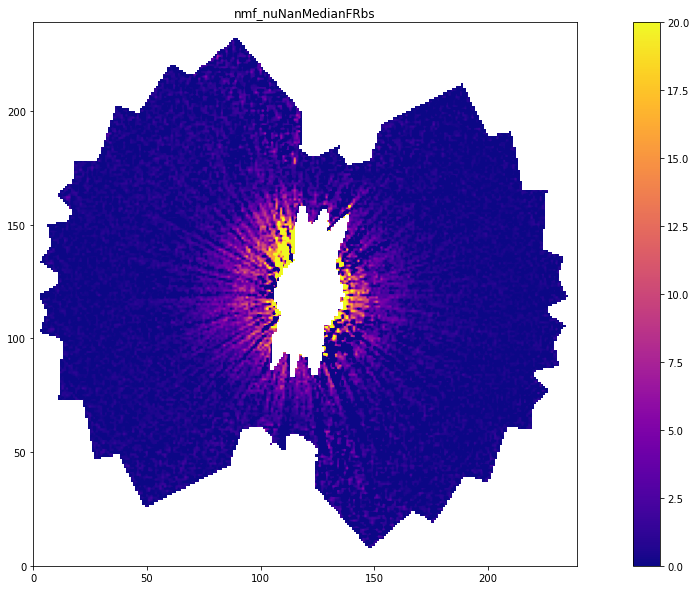

In [15]:
nmf_nuNanMedianFRbs = fits.getdata ( "nmf_nuNanMedianFRbs.fits")
plt.figure(figsize=[20,10])
plt.title("nmf_nuNanMedianFRbs")
plt.imshow      (
                        nmf_nuNanMedianFRbs    ,
                        cmap = "plasma" ,
                        vmax = 20      ,
                        vmin =0
                    )
plt.xlim        ( [ 0, nmf_nuNanMedianFRbs.shape[1] ] ) 
plt.ylim        ( [ 0, nmf_nuNanMedianFRbs.shape[0] ] )
plt.colorbar()

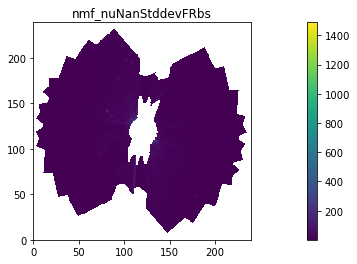

In [16]:
nmf_nuNanStddevFRbs = fits.getdata ( "nmf_nuNanStddevFRbs.fits")
plt.figure(figsize=[20,10])
plt.title("nmf_nuNanStddevFRbs")
plt.imshow      (
                        nmf_nuNanStddevFRbs    ,
                        cmap = "plasma" ,
                        vmax = 2       ,
                        vmin = 0
                    )
plt.imshow      ( nmf_nuNanStddevFRbs )
plt.xlim        ( [ 0, nmf_nuNanStddevFRbs.shape[1] ] ) 
plt.ylim        ( [ 0, nmf_nuNanStddevFRbs.shape[0] ] )
plt.colorbar()

In [17]:
zero_color = 'white'
norm=SymLogNorm(6e-9)
mpl.rcParams['hatch.linewidth'] = 0.2  
plt.rcParams["font.serif"]='serif'
mpl.rcParams["image.origin"]="lower"
semi_sym_cm = LinearSegmentedColormap.from_list('my cmap', ['black',zero_color,'purple'])
PIXELSCL=0.05071*u.arcsecond

In [18]:
nmf_fn="nmf_nuAllResidFRbo.fits"

nmf_cube_2019=fits.open(nmf_fn)

print(nmf_cube_2019[0].data.shape)

(552, 239, 239)


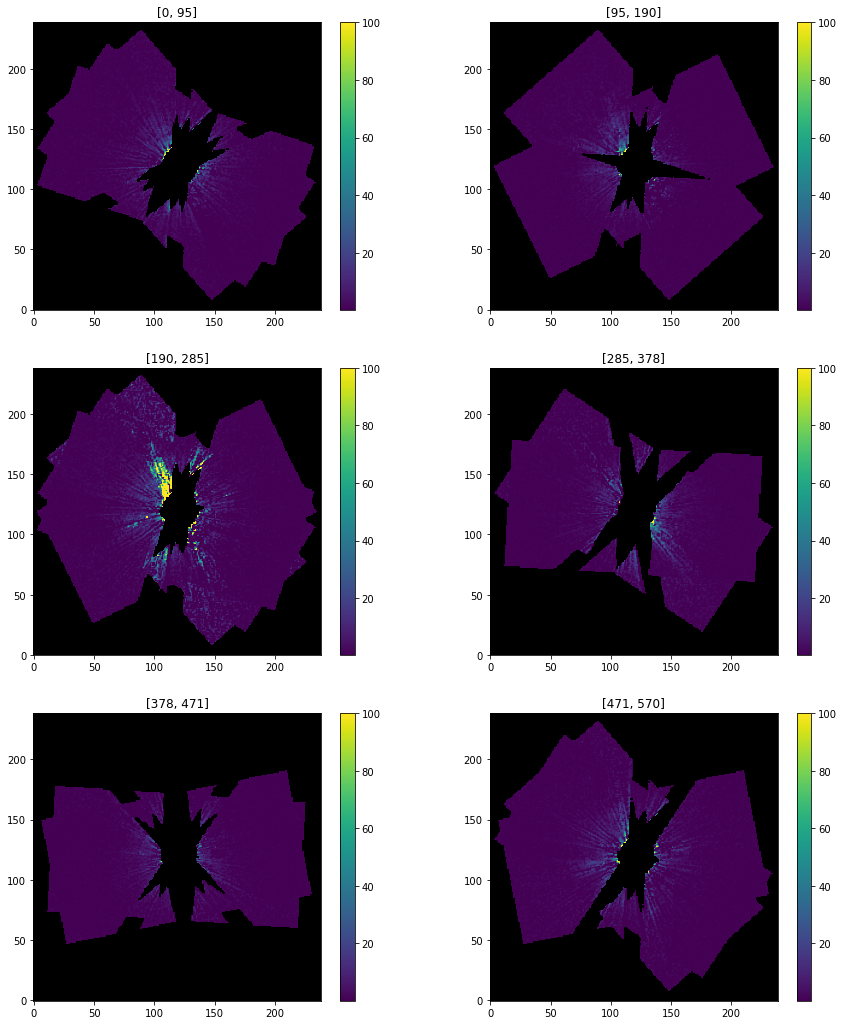

In [19]:
breaks=[0,95,95*2,95*3,95*4-2,95*5-4,95*6]
import matplotlib
plt.figure(figsize=[15,18])
vmin=np.nanmean(nmf_cube_2019[0].data)-np.nanstd(nmf_cube_2019[0].data)*5
vmax=np.nanmean(nmf_cube_2019[0].data)+np.nanstd(nmf_cube_2019[0].data)*5
visit=np.empty([6,nmf_cube_2019[0].data.shape[1],nmf_cube_2019[0].data.shape[2]])
for i in range(1,len(breaks)):
    plt.subplot(int("3"+"2"+str(i)))
    plt.title(str([breaks[i-1],breaks[i]]))
    current_cmap=matplotlib.cm.get_cmap().copy()
    current_cmap.set_bad(color="k")
    visit[i-1,:,:]=np.nanmedian(nmf_cube_2019[0].data[breaks[i-1]:breaks[i],:,:],axis=0,
                           )
    
    plt.imshow(visit[i-1,:,:],    #norm=matplotlib.colors.LogNorm(0.1,100)
               cmap=current_cmap,
               vmin=0.1,vmax=100
              )
    plt.colorbar()

/var/folders/w0/w0glfprn2b7c2dkswb2qrm040000gn/T/ipykernel_6490/3334898790.py:4: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(visit[:3],axis=0),vmax=20,vmin=0,interpolation="nearest",cmap=current_cmap)
/var/folders/w0/w0glfprn2b7c2dkswb2qrm040000gn/T/ipykernel_6490/3334898790.py:7: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(visit[3:],axis=0),vmax=20,vmin=0,interpolation="nearest",cmap=current_cmap)


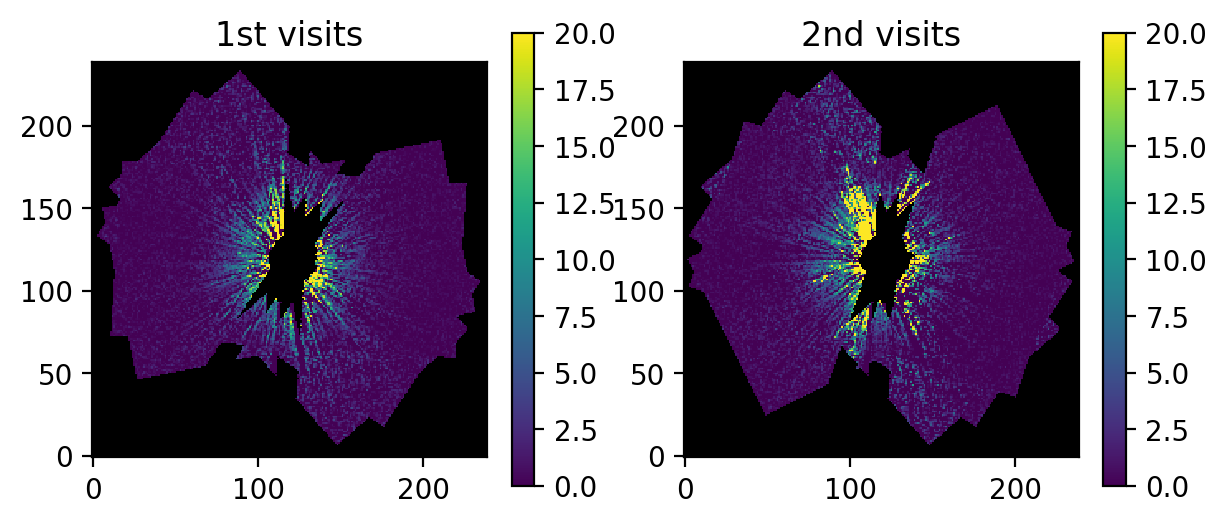

In [20]:
plt.figure(figsize=[7,3],dpi=200)
plt.subplot(122)
plt.title("2nd visits")
plt.imshow(np.nanmean(visit[:3],axis=0),vmax=20,vmin=0,interpolation="nearest",cmap=current_cmap)
plt.colorbar()
plt.subplot(121)
plt.imshow(np.nanmean(visit[3:],axis=0),vmax=20,vmin=0,interpolation="nearest",cmap=current_cmap)
plt.title("1st visits")
plt.colorbar()

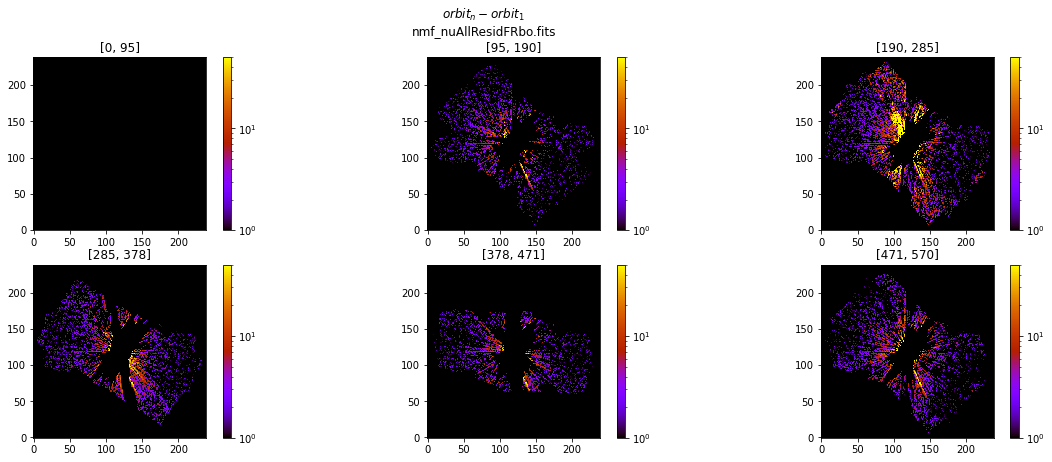

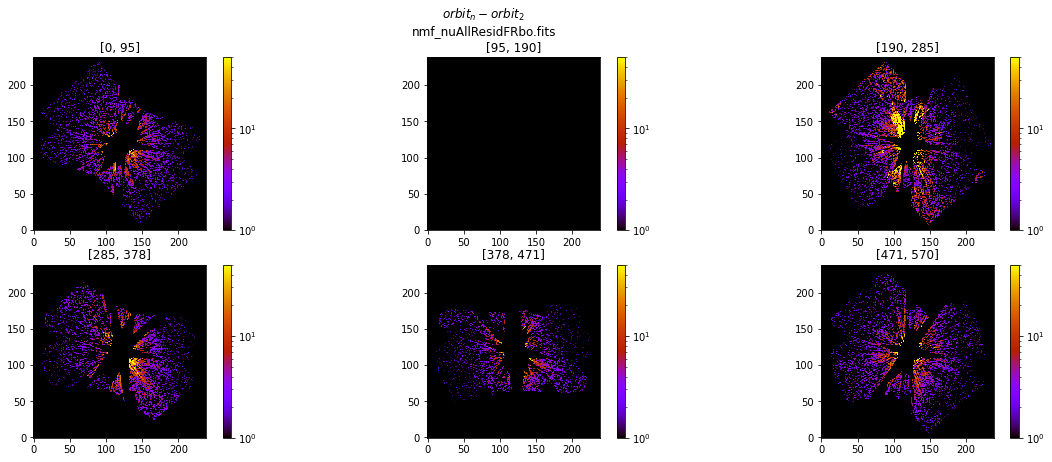

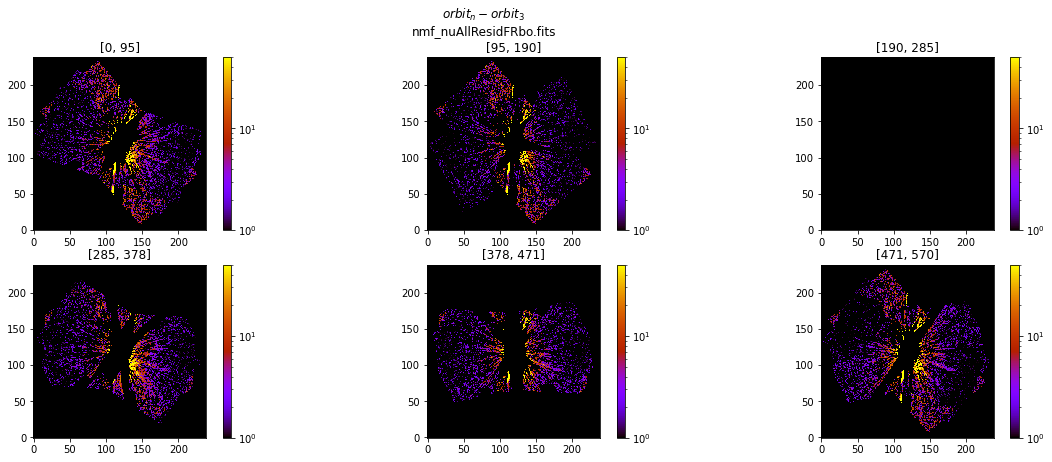

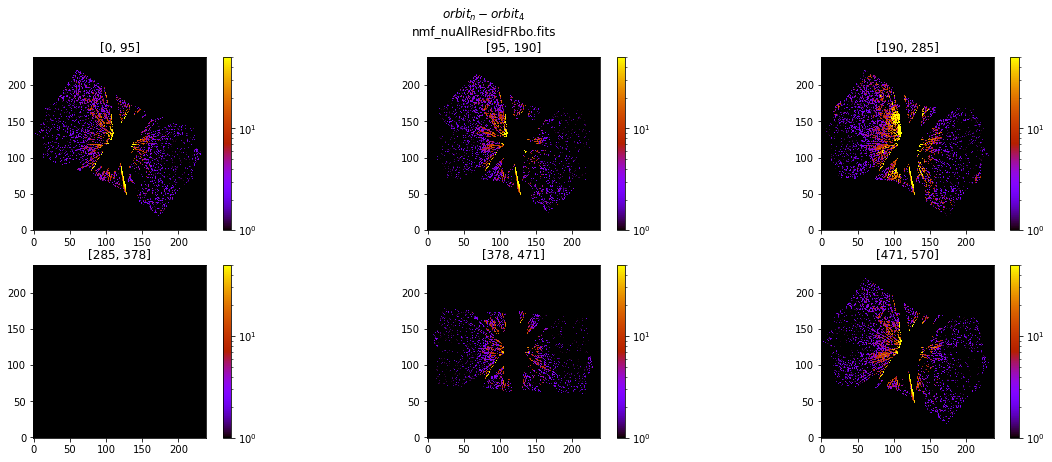

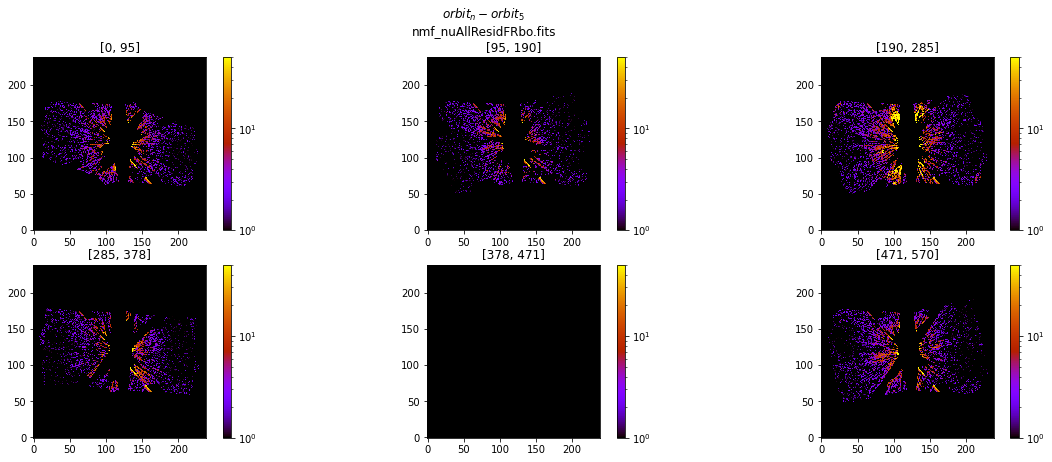

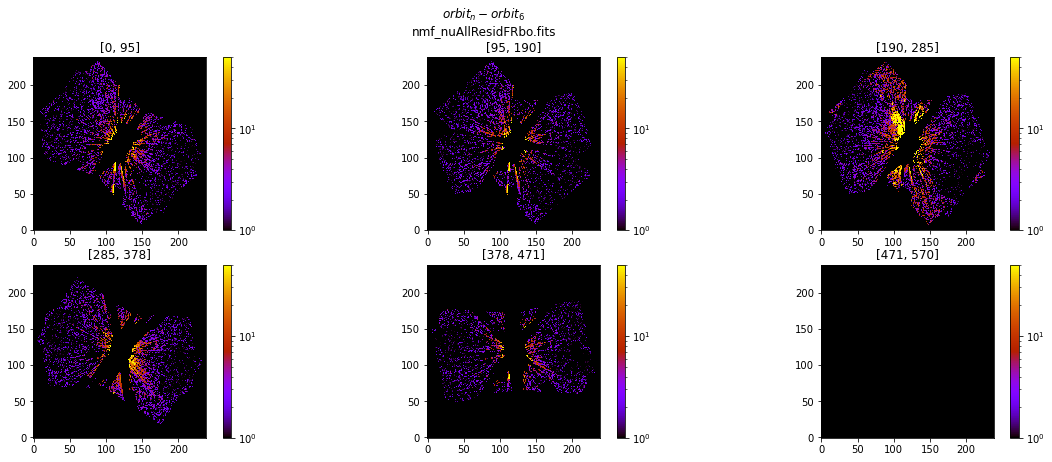

In [21]:
pairset=set()
for j in range(1,len(breaks)):
    plt.figure(figsize=[20,7])

    for i in range(1,len(breaks)):

        plt.subplot(int("2"+"3"+str(i)))
        plt.title(str([breaks[i-1],breaks[i]]))
        current_cmap=matplotlib.cm.gnuplot.copy()#matplotlib.cm.get_cmap()
        current_cmap.set_bad(color="k")
        #print(i)
        delta=visit[i-1,:,:]-visit[j-1,:,:]
        plt.imshow(delta,    norm=matplotlib.colors.LogNorm(1,50),
               cmap=current_cmap,interpolation="nearest",
                  )
        plt.colorbar()
    plt.suptitle("$orbit_n-orbit_{}$".format(j)+"\n"+nmf_fn)

10.81483590420805
n  frames:497


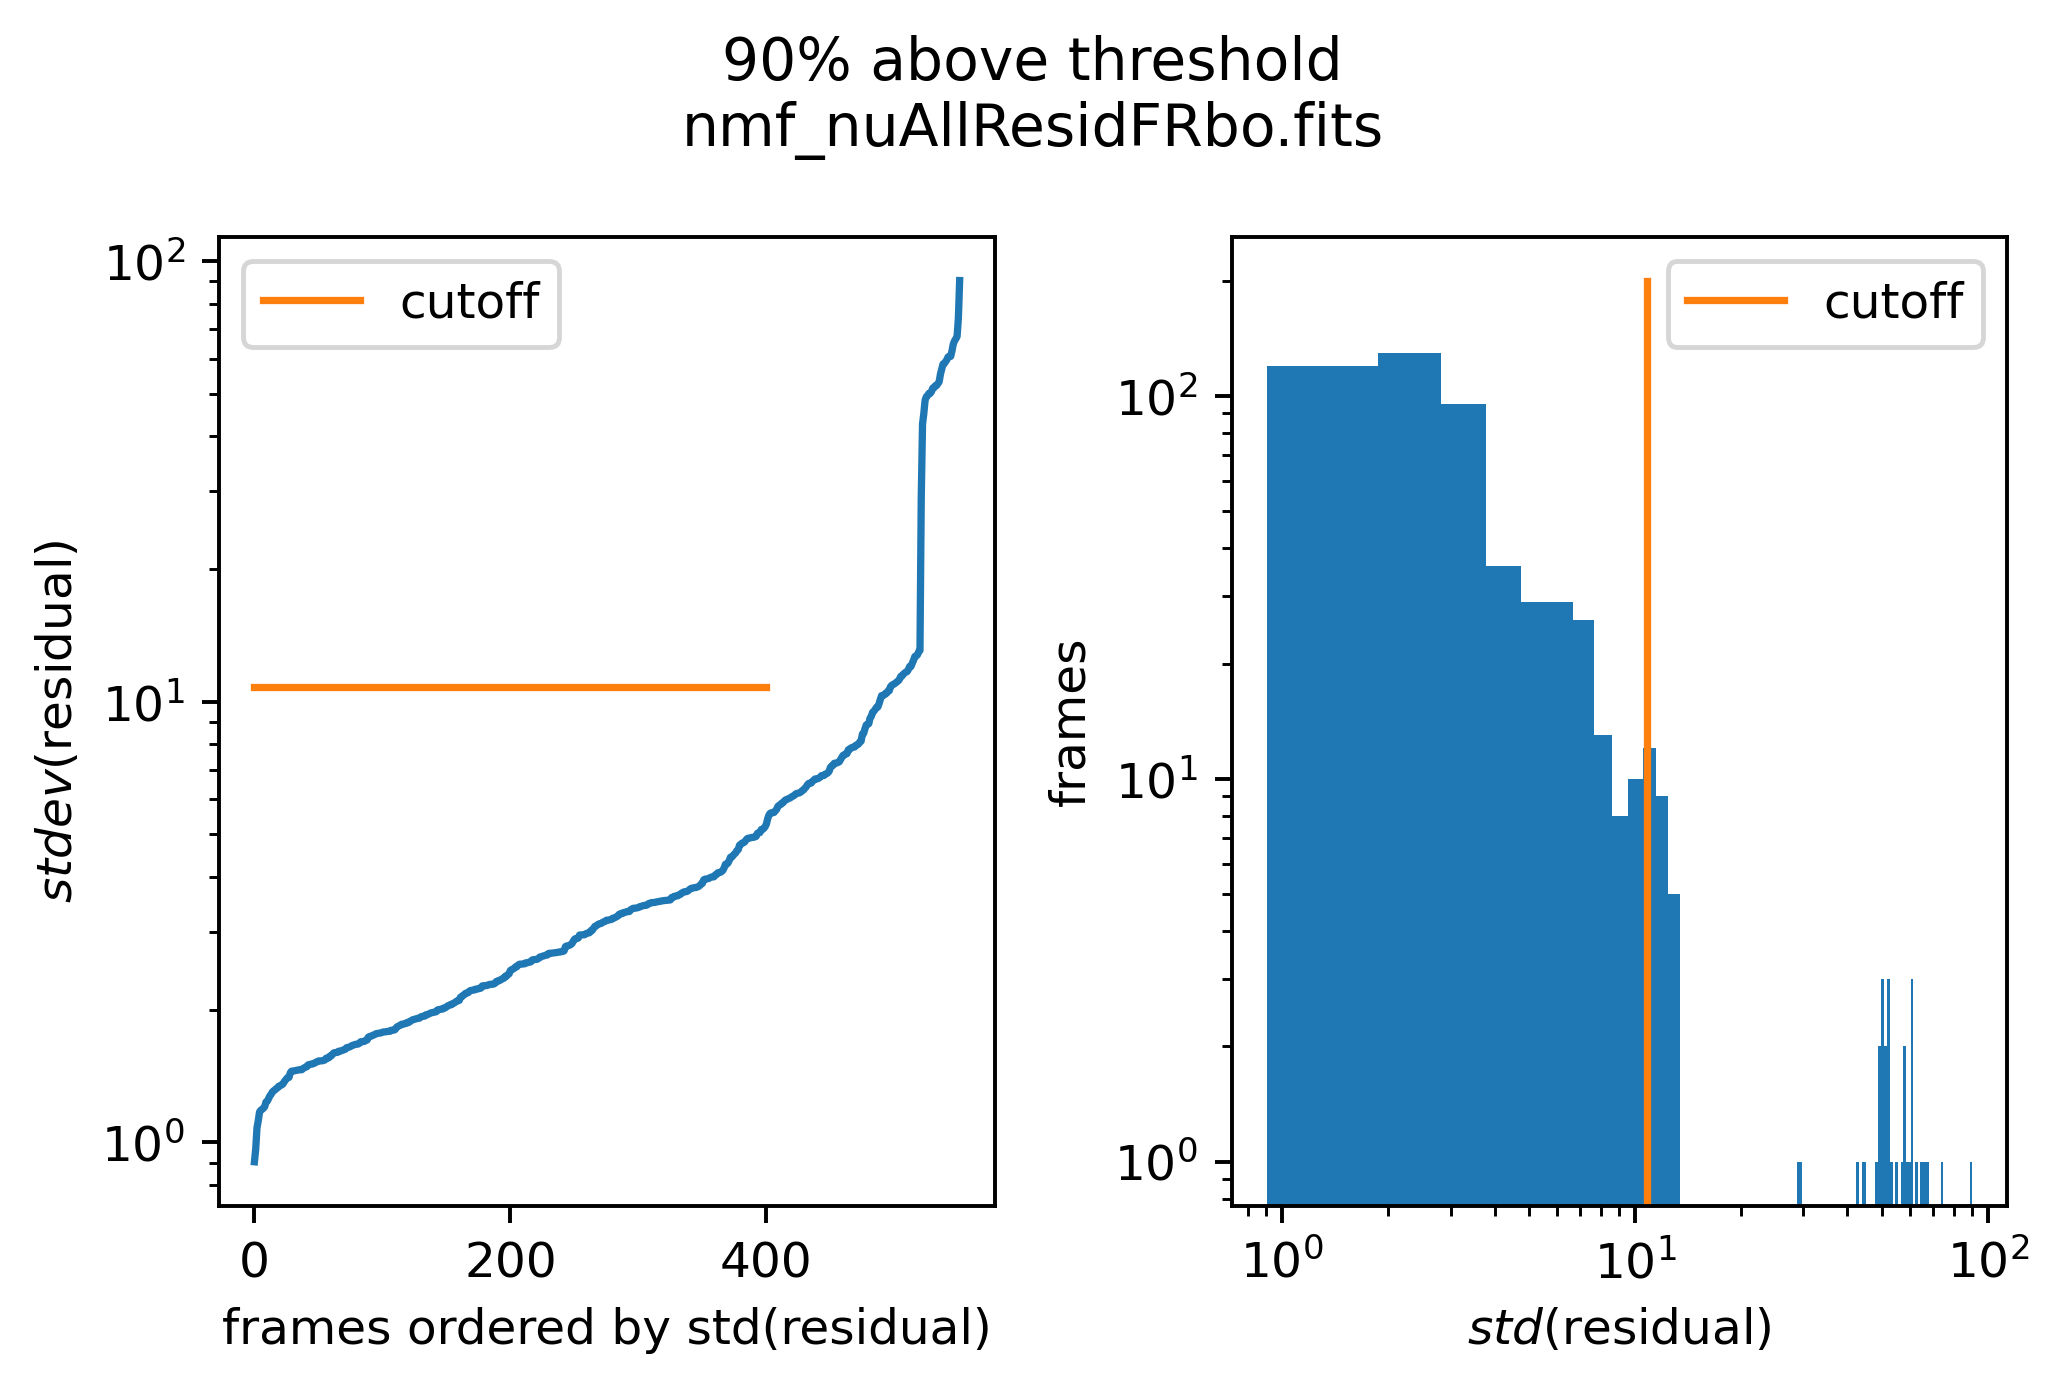

In [22]:
if nmf_fn.find("no_delta") != -1:
    subtracted=nmf_cube_2019[0].data[:,164:-164:,164:-164]#-nmf_cube_2018[0].data[0,:,:]
else:
    subtracted=nmf_cube_2019[0].data[:,:,:]#164:-164:,164:-164]#-nmf_cube_2018[0].data[0,:,:]

sub_std_frm=np.nanstd(np.nanstd(subtracted,axis=2),axis=1)

sub_ordered=sub_std_frm.copy()
sub_ordered.sort()

cutoff=sub_ordered[int(round(len(sub_ordered)*.9))] #counts, %

print(cutoff)

good_frames=np.where(sub_std_frm<cutoff)[0]
print("n  frames:"+str(len(good_frames)))

good_std=np.nanstd(subtracted[good_frames,:,:],axis=0)

bad_frames=np.where(sub_std_frm>cutoff)[0]
bad_std=np.nanstd(subtracted[bad_frames,:,:],axis=0)

bfraction=np.size(bad_frames)/np.size(sub_std_frm)
bad_Median=np.nanmedian(subtracted[bad_frames,:,:],axis=0)


gfraction=np.size(good_frames)/np.size(sub_std_frm)
gfrac_str="{:.2g}".format((np.round(gfraction*100)))

plt.figure(dpi=350)
plt.subplot(121)


#plt.imshow(good_std,vmin=0,vmax=np.nanmax(bad_std),cmap=plt.cm.plasma_r,)
plt.plot(sub_ordered)


plt.plot([0,400],[cutoff,cutoff],label="cutoff")

plt.ylabel("$stdev$(residual)")
#plt.xlabel("frame")
plt.xlabel("frames ordered by std(residual)")
plt.legend()
plt.yscale("log")



plt.subplot(122)


plt.hist(sub_ordered,bins="auto")
plt.ylabel("frames")
plt.plot([cutoff,cutoff],[0,200],label="cutoff")
plt.yscale("log")

plt.xscale("log")

plt.xlabel("$std$(residual)")
plt.legend()
#plt.title("histogram of $stdev$(residual)")
plt.suptitle(gfrac_str+"% above threshold\n"+nmf_fn)
plt.tight_layout()

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


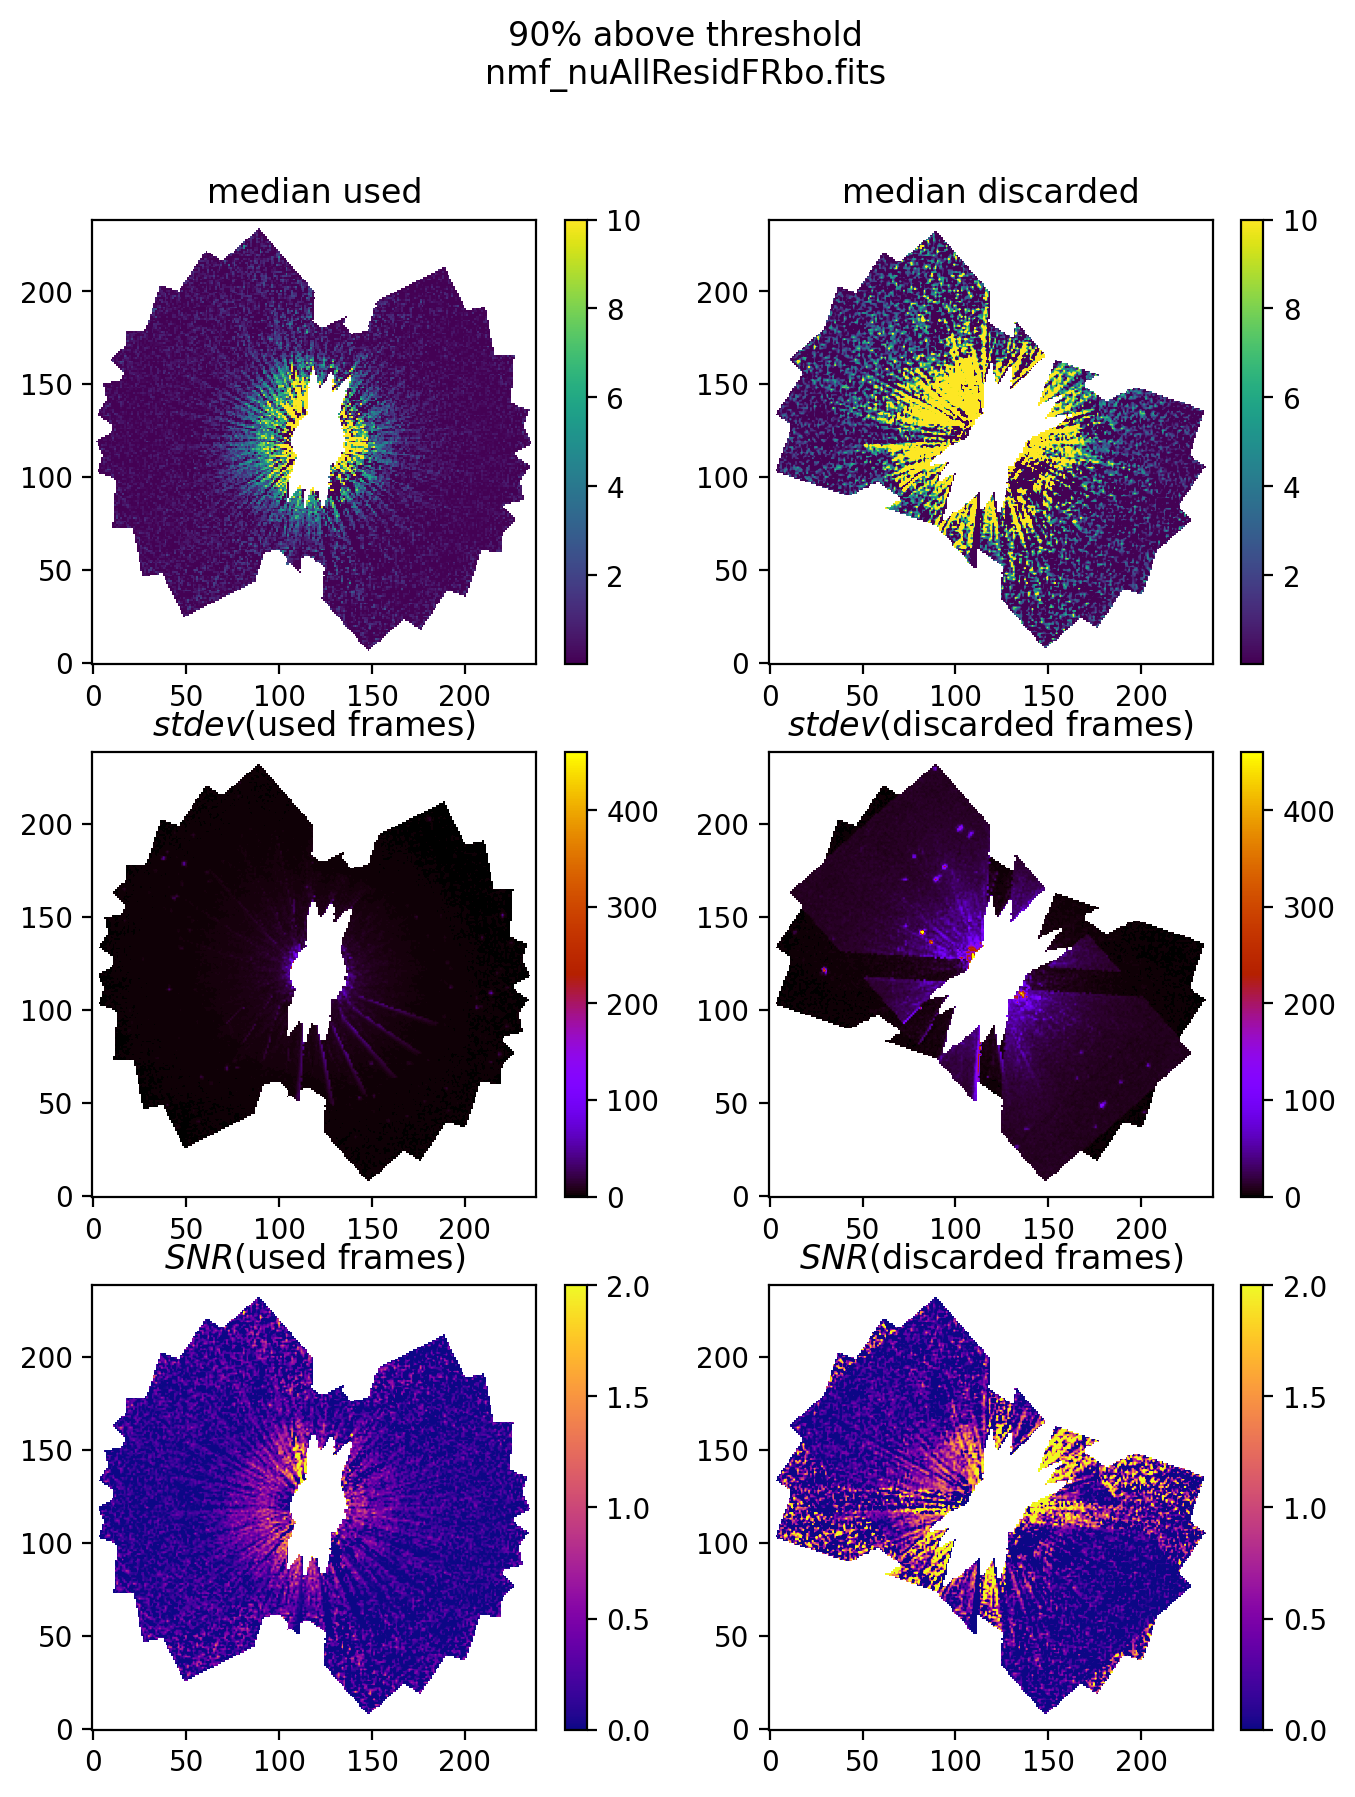

In [23]:
plt.figure(figsize=[8,10],dpi=200)
plt.subplot(321)

plt.suptitle(gfrac_str+"% above threshold\n"+nmf_fn)
plt.title("median used")
good_median=np.nanmedian(subtracted[good_frames,:,:],axis=0)
plt.imshow(good_median,#norm=matplotlib.colors.LogNorm(0.001,good_median.max()),
               #cmap=plt.cm.magma,
           interpolation='nearest',
              vmin=0.01,
           vmax=10)#np.nanmax(good_median))
plt.colorbar()
plt.subplot(322)
plt.title("median discarded")


plt.imshow(bad_Median,#norm=matplotlib.colors.LogNorm(0.001,good_median.max()),
           vmin=0.01,
           vmax=10
               #cmap=plt.cm.magma,
          )#np.nanmax(good_median))
fits.writeto(nmf_fn.replace("/","_")
             +"good_frames{}percent.fits".format(int(np.round(gfraction*100))),
             good_median,overwrite=True)
fits.writeto(nmf_fn.replace("/","_")
             +"bad_frames{}percent.fits".format(int(np.round(bfraction*100))),
             bad_Median,overwrite=True)
fits.writeto(nmf_fn.replace("/","_")
             +"goodSTD_frames{}percent.fits".format(int(np.round(gfraction*100))),
             good_std,
             overwrite=True)

plt.colorbar()
plt.subplot(323)

plt.imshow(good_std,vmin=0,cmap=plt.cm.gnuplot,vmax=np.nanmax(good_median),)

plt.title("$stdev$(used frames)")

plt.colorbar()

plt.subplot(324)
plt.imshow(bad_std,vmin=0,
           vmax=np.nanmax(good_median),
           cmap=plt.cm.gnuplot)
plt.title("$stdev$(discarded frames)")
plt.colorbar()

plt.subplot(325)

plt.imshow(good_median/good_std,vmin=0,vmax=2,cmap=plt.cm.plasma,)
plt.title("$SNR$(used frames)")


plt.colorbar()
plt.subplot(326)
plt.imshow(bad_Median/bad_std,vmin=0,vmax=2,cmap=plt.cm.plasma,)
plt.title("$SNR$(discarded frames)")
plt.colorbar()

In [24]:
def displ_scale(array,ps=.05*u.arcsec,
                d=None,
                ax=None,
                cmap=plt.cm.viridis,
                grid=False,
                cbar=True,
                cbar_label=None,
                xticks=None,
                **kwargs):
    if ax==None:
        ax=plt.subplot(111)
    nx = int(array.shape[1])
    ny= int(array.shape[0])
    halfpix = ps.to(u.arcsec).value*0.5
    extent = ([-(nx/2*ps).to(u.arcsec).value-halfpix,
                (nx/2*ps).to(u.arcsec).value+halfpix,
                -(ny/2*ps).to(u.arcsec).value-halfpix,
                +(ny/2*ps).to(u.arcsec).value+halfpix
              ])
    print(nx,ny,ps,halfpix)
    print(ax.get_xticks())
    print(extent)
        
    try:
        plt.imshow(array.decompose().value,interpolation='nearest',
                   extent=extent,cmap=cmap,**kwargs)
        print(ax.get_xticks())
    except Exception as err:
        print(err)
        plt.imshow(array,interpolation='nearest',
                   cmap=cmap,
                   extent=extent,**kwargs)
    cb=plt.colorbar(format='%.3g')
    
    try:
        if cbar_label is None:
            cb.ax.set_title(array.decompose().unit,fontsize=9)
        else:
            cb.ax.set_title(cbar_label,fontsize=9)
    except Exception as err:
        print(err)
    if grid:
        ax.grid(linewidth=0.1)
    if d is not None:
        axAU = ax.twiny()
        arcsec = ax.get_xticks()
        axAU.set_xticks((arcsec))   
        print(arcsec)
        AU=np.round(arcsec*d,1)
        print(AU)
        axAU.set_xticklabels(AU)
        #ax2.set_xticklabels(AU)
        axAU.set_xlabel("AU")
        axAU.set_xlim(np.array(ax.get_xlim()))

239 239 0.05 arcsec 0.025
[0.  0.2 0.4 0.6 0.8 1. ]
[-6.000000000000001, 6.000000000000001, -6.000000000000001, 6.000000000000001]
'numpy.ndarray' object has no attribute 'decompose'
239 239 0.05 arcsec 0.025
[0.  0.2 0.4 0.6 0.8 1. ]
[-6.000000000000001, 6.000000000000001, -6.000000000000001, 6.000000000000001]
'numpy.ndarray' object has no attribute 'decompose'


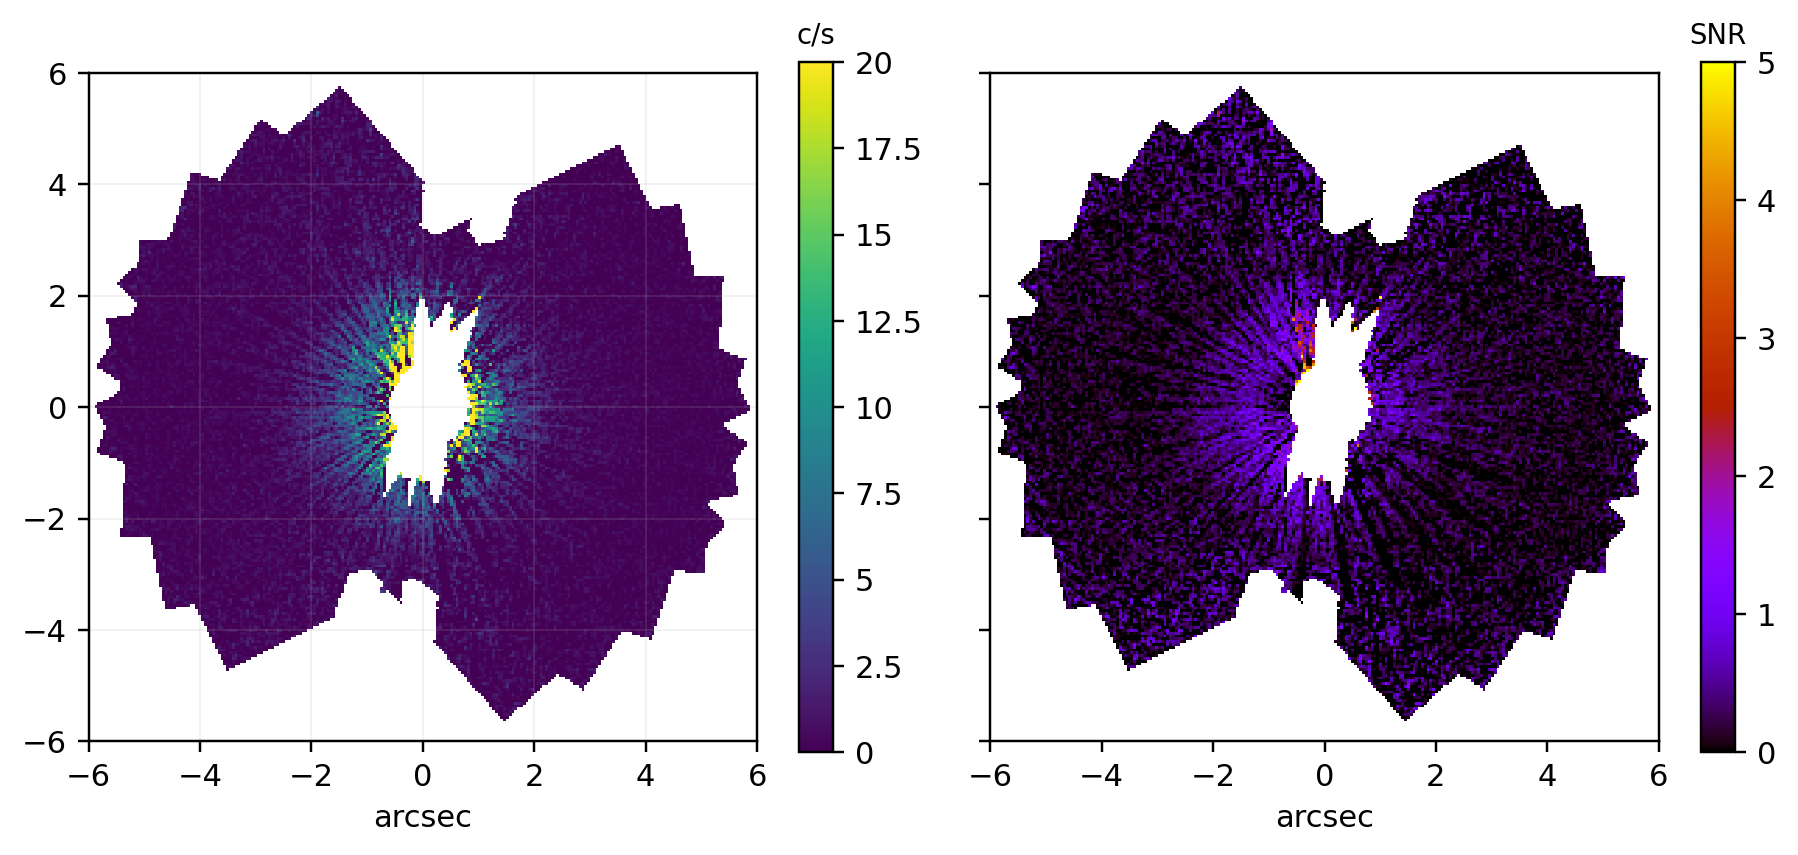

In [25]:
plt.figure(figsize=[8.5,3.8],dpi=220)
ax1=plt.subplot(122)
displ_scale(good_median/good_std,vmin=0,#vmax=2,
            grid=False,
            ax=ax1,
            #d=3.2,
            cbar_label="SNR",
            cmap=plt.cm.gnuplot,
            vmax=5,
           )#np.nanmax(good_median))
#plt.title("$SNR$(used frames)")
#plt.colorbar(label="SNR")
ax1.set_xlabel('arcsec')
ax1.set_yticklabels("")
ax=plt.subplot(121)
if nmf_fn.find("klip") != -1:
    vmin=-1
else:
    vmin=0
    
    #plt.grid()
displ_scale(good_median,#norm=matplotlib.colors.LogNorm(0.001,good_median.max()),
              vmin=0,
            grid=True,
            ax=ax,
            #d=3.2,
            cbar_label="c/s",
            
            cmap="viridis",
           vmax=20)#np.nanmax(good_median))
ax.set_xlabel('arcsec')
#plt.suptitle(nmf_fn)
plt.tight_layout()

In [33]:
hdu = fits.PrimaryHDU(good_median)
hdu.writeto('wbackman.fits',overwrite=True)

In [26]:
hdu = fits.PrimaryHDU(good_median)
hdu.writeto('wobackman.fits')

In [46]:
wbackman = fits.getdata('wbackman.fits')
wobackman = fits.getdata('wobackman.fits')

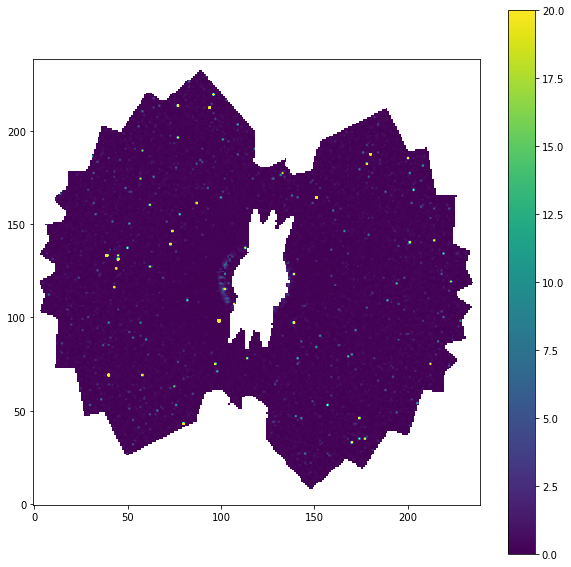

In [47]:
plt.figure(figsize=[10,10])
plt.imshow(wbackman/wobackman,vmin=0,vmax=20)
plt.colorbar()

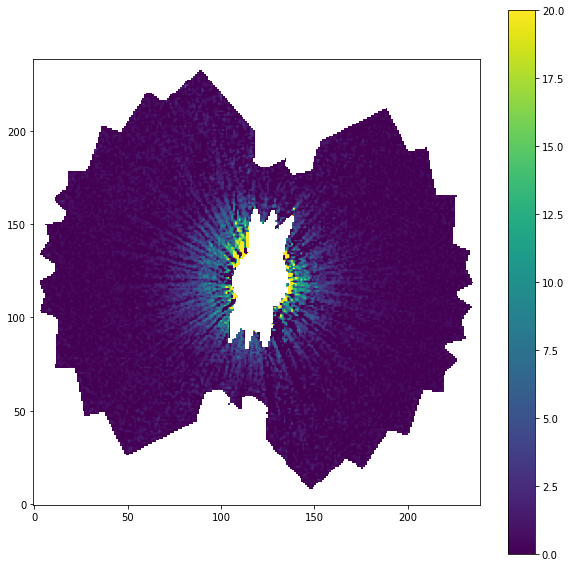

In [49]:
plt.figure(figsize=[10,10])
plt.imshow(wobackman,vmin=0,vmax=20)
plt.colorbar()

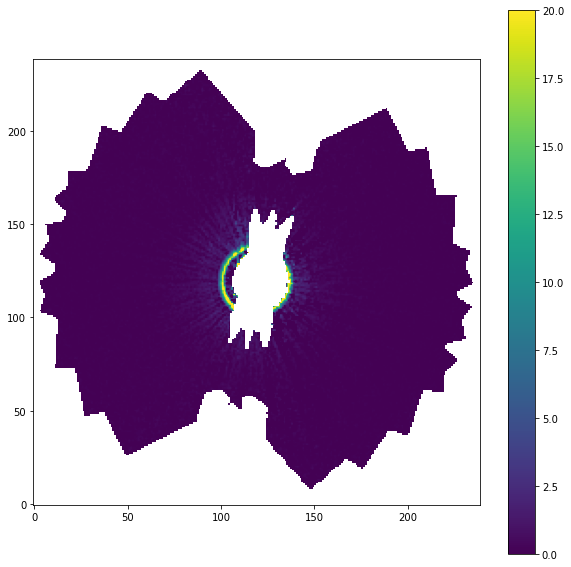

In [50]:
plt.figure(figsize=[10,10])
plt.imshow(wbackman,vmin=0,vmax=20)
plt.colorbar()